In [3]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [4]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Utils

In [5]:

from collections import defaultdict
def reject_outliers(data, m = 4.):
    return data
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(d.shape)
    return data[s<m]

def process_results(results, model_names):
    processed_results = defaultdict(lambda: defaultdict(list))
    for split, split_results in results.items():
        for key, vals in split_results.items():
            model_found = None
            var_found = None
            vals_found = None
            for model_cand_name in model_names:
                if ("_"  + model_cand_name) in key:
                    var_found, model_found = key.split(model_cand_name)
                    model_found = model_cand_name + model_found
                    var_found = var_found[:-1]  # Get rid of the end "_"
                    vals_found = vals
                    break
            if model_found is None:
                continue

            processed_results[var_found][model_found].append(vals_found)
    for var_found, models in processed_results.items():
        for model_found, vals in models.items():
            processed_results[var_found][model_found] = reject_outliers(np.array(vals))
    return processed_results

def get_intervention_accuracies(
    results,
    model_name,
    policy_name=None,
    competence_level=1,
):
    key = f'test_acc_y_{policy_name}_ints'
    if (competence_level is not None) and (competence_level != 1):
        key = f'test_acc_y_{policy_name}_ints_competence_{competence_level}'
        if not key in results:
            key = f'test_acc_y_{policy_name}_ints_co_{competence_level}'
    metric_results = results[key]
    if model_name not in metric_results:
        raise ValueError(
            f'We could not find {model_name} amongst models {list(metric_results.keys())}'
        )
    y_acc_vals = metric_results[model_name]
    y_acc_vals = np.array(y_acc_vals) * 100
    means = np.mean(y_acc_vals, axis=0)
    stds = np.std(y_acc_vals, axis=0)
    return means, stds

# Global Variables

In [6]:
################################################################################
## Global Variables Defining Experiment Flow
################################################################################

GPU = 1
NUM_WORKERS = 8
rc('text', usetex=False)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

# Load Combined Results

In [7]:
RESULTS_DIR = "/anfs/bigdisc/me466/intervention_experiment_results/intervention_policies/cem/results/" #"./results/"
CUB_RESULTS_DIR = os.path.join(
    RESULTS_DIR,
    "cub_interventions",
)
CUB_RESULTS = joblib.load(os.path.join(CUB_RESULTS_DIR, 'results.joblib'))

CUB_SUBSAMPLE_RESULTS_DIR = os.path.join(
    RESULTS_DIR,
    "cub_subsample_0.25_interventions",
)
CUB_SUBSAMPLE_RESULTS = joblib.load(os.path.join(CUB_SUBSAMPLE_RESULTS_DIR, 'results.joblib'))

CHEXPERT_RESULTS_DIR = os.path.join(
    RESULTS_DIR,
    "chexpert_interventions_quarter_longer",
)
CHEXPERT_RESULTS = joblib.load(os.path.join(CHEXPERT_RESULTS_DIR, 'results.joblib'))


CELEBA_RESULTS_DIR = os.path.join(
    RESULTS_DIR,
    "celeba_interventions",
)
CELEBA_RESULTS = joblib.load(os.path.join(CELEBA_RESULTS_DIR, 'results.joblib'))

MNIST_REDUCED_RESULTS_DIR = os.path.join(
    RESULTS_DIR,
    # "mnist_add_final",
    "mnist_add_new",
)
MNIST_REDUCED_RESULTS = joblib.load(os.path.join(MNIST_REDUCED_RESULTS_DIR, 'results.joblib'))

MNIST_RESULTS_DIR = os.path.join(
    RESULTS_DIR,
    "mnist_add_new_complete",
)
MNIST_RESULTS = joblib.load(os.path.join(MNIST_RESULTS_DIR, 'results.joblib'))

DERM_RESULTS_DIR = os.path.join(
    RESULTS_DIR,
    "derm_full_concepts_interventions",
    # "derm_interventions",
)
DERM_RESULTS = joblib.load(os.path.join(DERM_RESULTS_DIR, 'results.joblib'))


In [8]:
sorting_key = 'test_acc_y_group_random_ints'
sorting_fn = lambda x: np.mean([x[len(x)//2] for x in x]) #np.mean
all_processed_results = {}
intcem_var_names = {}
model_configs = defaultdict(dict)
model_names = [
    'ConceptEmbeddingModel',
    'IntAwareConceptEmbeddingModel',
    'ConceptBottleneckModelLogit',
    'ConceptBottleneckModelSigmoid',
    'SequentialConceptBottleneckModel',
    'IndependentConceptBottleneckModel',
]
ALL_DS = [
    ("MNIST-Add", MNIST_RESULTS, MNIST_RESULTS_DIR),
    ("MNIST-Add-Incomp", MNIST_REDUCED_RESULTS, MNIST_REDUCED_RESULTS_DIR),
    ("CelebA", CELEBA_RESULTS, CELEBA_RESULTS_DIR),
    ("CheXpert", CHEXPERT_RESULTS, CHEXPERT_RESULTS_DIR),
    ("CUB", CUB_RESULTS, CUB_RESULTS_DIR),
    ("CUB-Incomp", CUB_SUBSAMPLE_RESULTS, CUB_SUBSAMPLE_RESULTS_DIR),
    ("Derm7-p", DERM_RESULTS, DERM_RESULTS_DIR),
]
for dataset_name, dataset_results, ds_path in ALL_DS:
    print(dataset_name)
    og_processed_results = process_results(dataset_results, model_names)
    models_by_acc = sorted(
        [
            (model_name, sorting_fn(vals)) for model_name, vals in og_processed_results[sorting_key].items() if "IntAware" in model_name
        ],
        key=lambda x: x[1],
        reverse=True,
    )
    print(models_by_acc)
    if models_by_acc:
        intcem_var_names[dataset_name] = models_by_acc[0][0]
    

    all_processed_results[dataset_name] = og_processed_results

MNIST-Add
[('IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 0.9675541639328002), ('IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 0.9670557975769043), ('IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 0.9647496342658997), ('IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 0.9644378900527955), ('IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 0.9599207162857055), ('IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 0.9595122933387756), ('IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 0.957

In [9]:
def filter_results(results, model_configs, ds_path, fun):
    output = copy.deepcopy(results)
    methods_to_remove = []
    for method_name in output['test_acc_y'].keys():
        for arch in ['lambda', 'resnet34', 'resnet18']:
            config_path = os.path.join(
                ds_path,
                f"{method_name}_{arch}_fold_1_experiment_config.joblib",
            )
            if os.path.exists(config_path):
                model_configs[method_name] = joblib.load(config_path)
                break
        if method_name not in model_configs:
            continue
            # raise ValueError(method_name, config_path)
        if fun(model_configs[method_name]):
            methods_to_remove.append(method_name)
    print("Removing", methods_to_remove)
    for method_name in methods_to_remove:
        for metric_name, other_method_name in list(results.items()):
            if method_name in other_method_name:
                del output[metric_name][method_name]
    return output

def _get_single_rollout(config):
    return (
        (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
        (config.get('horizon_rate', 1.005) != 1)
    )

# Dataset Analysis

In [10]:
import datetime
import yaml
reload(yaml)
import io
from contextlib import redirect_stdout
from torchvision.models import resnet18, resnet34, resnet50, densenet121
import re
yaml.add_implicit_resolver("tag:yaml.org,2002:python/name:__main__.c_extractor_arch", re.compile(r'^\d+d\d+$'))
import cem.data.CUB200.cub_loader as cub_data_module
import cem.data.mnist_add as mnist_data_module
import cem.data.celeba_loader as celeba_data_module
ALL_DS_LOADERS = [
    ("MNIST-Add", MNIST_RESULTS, MNIST_RESULTS_DIR, mnist_data_module, '/anfs/bigdisc/me466/'),
    ("MNIST-Add-Incomp", MNIST_REDUCED_RESULTS, MNIST_REDUCED_RESULTS_DIR, mnist_data_module, '/anfs/bigdisc/me466/'),
    ("CUB", CUB_RESULTS, CUB_RESULTS_DIR, cub_data_module, '/homes/me466/UncertaintyIntervention/cem/data/CUB200/'),
    ("CUB-Incomp", CUB_SUBSAMPLE_RESULTS, CUB_SUBSAMPLE_RESULTS_DIR, cub_data_module, '/homes/me466/UncertaintyIntervention/cem/data/CUB200/'),
    ("CelebA", CELEBA_RESULTS, CELEBA_RESULTS_DIR, celeba_data_module, '/anfs/bigdisc/me466'),
]
for dataset_name, dataset_results, ds_path, ds_loader, root_dir in ALL_DS_LOADERS:
    # Iterate over files in directory ds_path
    experiment_configs = []
    for file_name in os.listdir(ds_path):
        found = None
        for arch_name in ["lambda", "resnet18", "resnet34", "resnet50", "densenet121"]:
            if file_name.endswith(f'ConceptEmbeddingModel_{arch_name}_fold_1_experiment_config.joblib'):
                found = file_name
                break
        if not found:
            continue
        # if not file_name.startswith('experiment_'):
        #     continue
        # with open(os.path.join(ds_path, file_name), "r") as f:
        #     experiment_config = yaml.load(f, Loader=yaml.Loader)
        experiment_config = joblib.load(os.path.join(ds_path, found))
        if 'shared_params' not in experiment_config:
            experiment_config['shared_params'] = {}
        # Move all global things into the shared params
        for key, vals in experiment_config.items():
            if key not in ['runs', 'shared_params']:
                experiment_config['shared_params'][key] = vals
        experiment_config['shared_params']['num_workers'] = 6
        experiment_configs.append(experiment_config)
        # experiment_configs.append(
        #     (datetime.strptime(file_name[len("experiment_"):-len("_config.yaml")], '%Y_%m_%d_%H_%M'), experiment_config)
        # )
    # experiment_configs = sorted(experiment_configs, key=lambda x: x[0])
    # print(experiment_configs)
    # experiment_config = experiment_configs[-1][1]
    experiment_config = experiment_configs[-1]
    # print(experiment_config)
    f = io.StringIO()
    with redirect_stdout(f):
        train_dl, val_dl, test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
            ds_loader.generate_data(
                config=experiment_config['shared_params'],
                seed=42,
                output_dataset_vars=True,
                root_dir=root_dir,
            )
    train_samples = len(train_dl.dataset)# * experiment_config['shared_params']['batch_size']
    val_samples = len(val_dl.dataset)# * experiment_config['shared_params']['batch_size']
    test_samples = len(test_dl.dataset)# * experiment_config['shared_params']['batch_size']
    input_shape = train_dl.dataset[0][0].shape
    n_groups = len(concept_map) if concept_map is not None else n_concepts
    print(
        f"\\texttt{{{dataset_name}}} &\n" +
        f"    {train_samples + val_samples} &\n" +
        # f"    ${train_samples + val_samples:.2E}}}$ &\n".replace("E-0", "\\times 10^{-").replace("E+0", "\\times 10^{") +
        f"    {test_samples} &\n" +
        # f"    {test_samples:.2E} &\n" +
        f"    {list(input_shape)} &\n" +
        f"    {n_concepts} &\n" +
        f"    {n_groups} &\n" +
        f"    {n_tasks} \\\\\n"
    )

/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning-1.9.5-py3.8.egg/pytorch_lightning/utilities/seed.py:47: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_fabric.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 42
Global seed set to 42


\texttt{MNIST-Add} &
    12000 &
    10000 &
    [12, 28, 28] &
    72 &
    12 &
    1 \\

\texttt{MNIST-Add-Incomp} &
    12000 &
    10000 &
    [12, 28, 28] &
    54 &
    8 &
    1 \\



Global seed set to 42


FileNotFoundError: [Errno 2] No such file or directory: '/homes/me466/UncertaintyIntervention/cem/data/CUB200/class_attr_data_10/train.pkl'

# Plot All Policies Across All Datasets

Removing []
Removing []
Removing []
Removing []
Removing []
Removing []
Removing []
62.85942646010693 99.58907672559465
65.59928728401975 95.00268645918356
14.606225377019351 70.64587563284911
73.58993505120125 97.70408272743225
49.41881251133552 100.00879267169827
-4.06606145138516 97.14187090093202
31.15375722569857 53.99629856165563


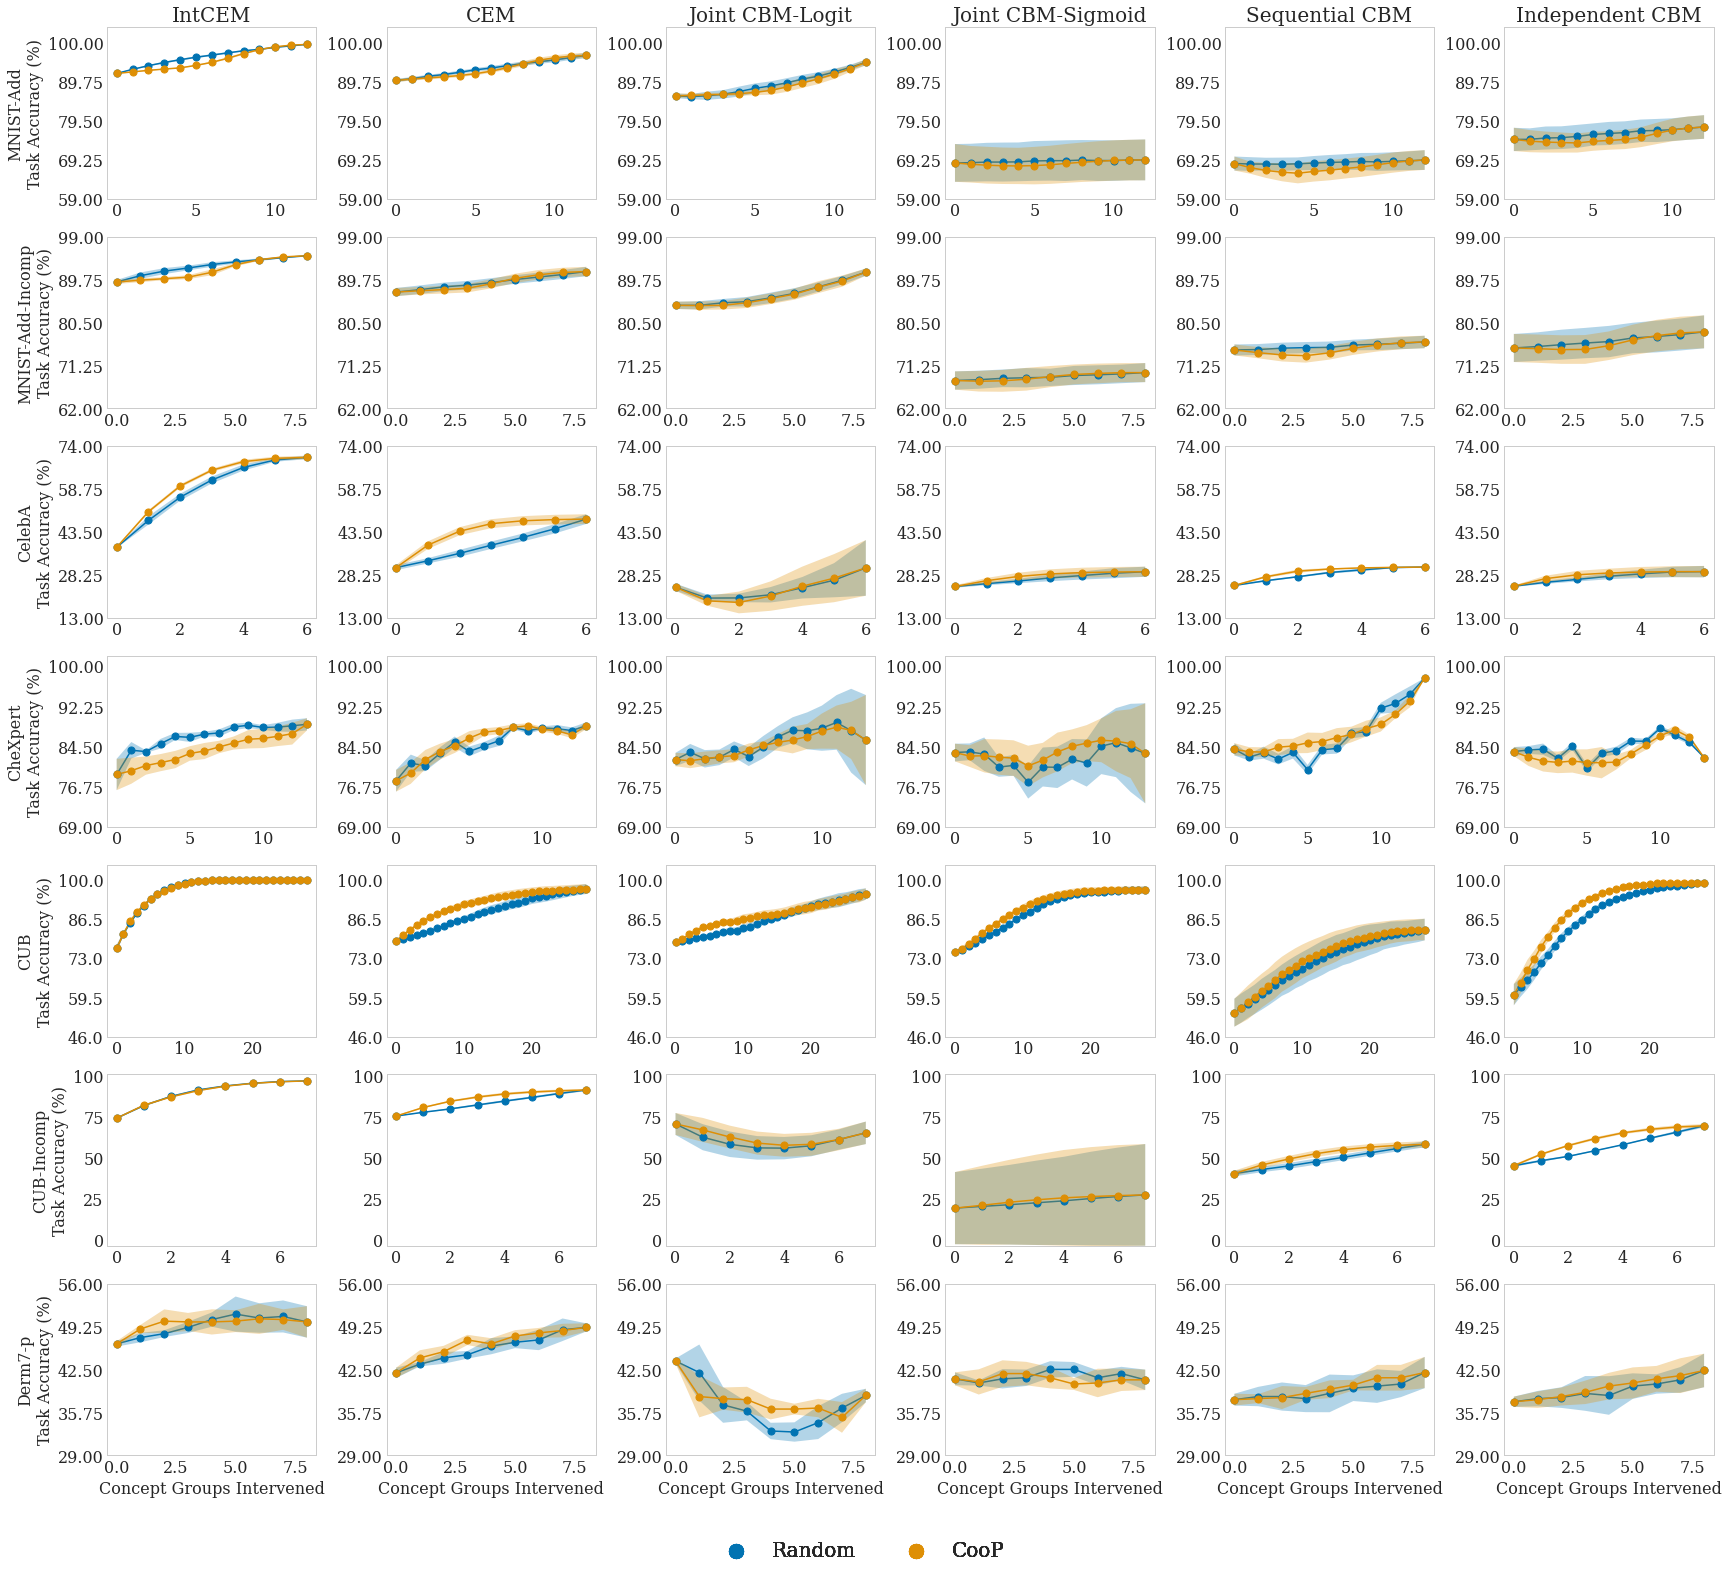

In [12]:

clrs = sns.color_palette("colorblind", 30)
color_map = {}
model_names = [
    'IntAwareConceptEmbeddingModel',
    'ConceptEmbeddingModel',
    'ConceptBottleneckModelLogit',
    'ConceptBottleneckModelSigmoid',
    'SequentialConceptBottleneckModel',
    'IndependentConceptBottleneckModel',
]
policy_names = [
    # ("Skyline (Oracle)", "optimal_greedy_no_prior"),
    ("Random", "group_random"),
    # ("Uncertainty Policy", "group_uncertainty_no_prior"),
    ("CooP", "group_coop_no_prior"),
    # ("Behavioural Cloning", "behavioural_cloning_no_prior"),
]
all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        lambda x: False,
    )
fig, axs = plt.subplots(
    len(all_filtered_results),
    len(model_names),
    figsize=(4*len(model_names), len(all_filtered_results)*3),
    squeeze=False,
)


for dataset_idx, (dataset_name, dataset_results) in enumerate(all_filtered_results.items()):
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }

    # First find the bounds of the current dataset plots
    y_min = 100
    y_max = 0
    for method_idx, method_name in enumerate(model_names):
        if method_name == "IntAwareConceptEmbeddingModel":
            method_name = intcem_var_names[dataset_name]
            method_to_actual_name[method_name] = "IntCEM"
        ax = axs[dataset_idx, method_idx]
        if method_name not in method_to_actual_name:
            continue
        for human_policy_name, policy_name in policy_names:
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
            y_max = max(y_max, np.max(means + stds))
            y_min = min(y_min, np.min(means - stds))
    print(y_min, y_max)
    y_max = int(np.floor(y_max * 1.05))
    y_min = int(np.floor(y_min * 0.95))


    for method_idx, method_name in enumerate(model_names):
        ax = axs[dataset_idx, method_idx]
        if method_name == "IntAwareConceptEmbeddingModel":
            method_name = intcem_var_names[dataset_name]
            method_to_actual_name[method_name] = "IntCEM"
        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        config = model_configs[dataset_name][method_name]
        for human_policy_name, policy_name in policy_names:
            if policy_name == "group_random" and "IntAware" in method_name:
                human_policy_name = "Learnt Policy"
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            method_name = method_to_actual_name.get(method_name, method_name)
            if policy_name not in color_map:
                color_map[policy_name] = clrs[len(color_map)]
            color = color_map[policy_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=50,
                label=human_policy_name,
                color=color,
                zorder=2,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=0.3,
                facecolor=color,
            )
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        if dataset_idx == len(all_processed_results) - 1:
            ax.set_xlabel(f"Concept Groups Intervened", fontsize=16)
        if dataset_idx == 0:
            ax.set_title(method_name, fontsize=20)
        if method_idx == 0:
            ax.set_ylabel(f"{dataset_name}\nTask Accuracy (%)", fontsize=16)
        ax.grid(False)
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(np.linspace(max(y_min, 0), min(y_max, 100), 5))
        handles, labels = ax.get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        fontsize=20,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=2,
        markerscale=2,
    )
plt.tight_layout()
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

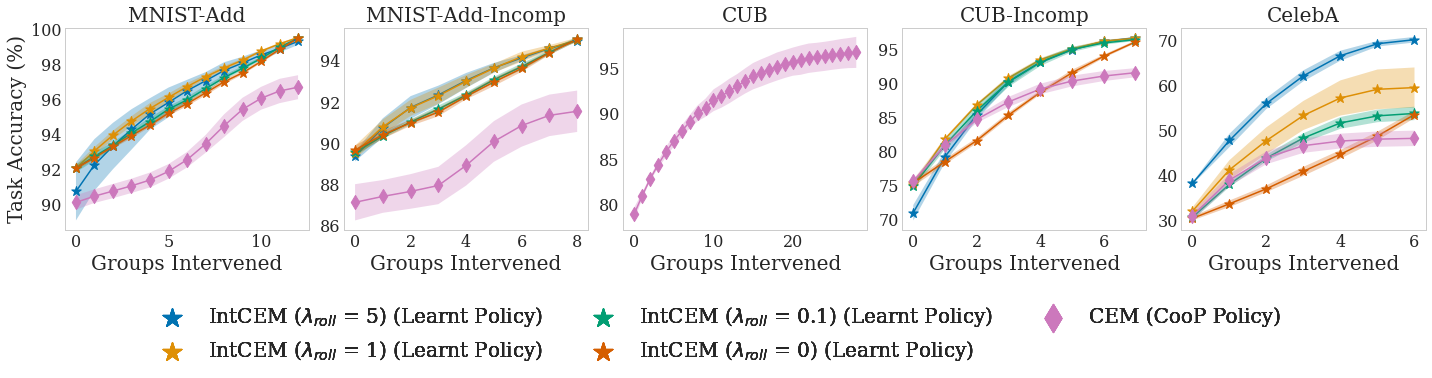

In [10]:

clrs = sns.color_palette("colorblind", 30)
color_map = {}
model_name_to_marker = {
    'IntAwareConceptEmbeddingModel': '*',
    'ConceptBottleneckModelLogit': '.',
    'ConceptBottleneckModelSigmoid': 'x',
    'ConceptEmbeddingModel': 'd',
    'SequentialConceptBottleneckModel': 's',
    'IndependentConceptBottleneckModel': 'o',
}
used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random"),
}
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
all_filtered_results = {}
labels = []
handles = []
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.1) == 1.1) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*4, 4),
    squeeze=False,
)
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    model_names = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ] + [
        'ConceptEmbeddingModel',
        # 'ConceptBottleneckModelLogit',
        # 'ConceptBottleneckModelSigmoid',
        # 'SequentialConceptBottleneckModel',
        # 'IndependentConceptBottleneckModel',
    ]
    print(model_names)
    for method_idx, method_name in enumerate(model_names):
        ax = axs[0, dataset_idx]
        marker = model_name_to_marker.get(method_name,'.')
        human_policy_name, policy_name = used_policies.get(
            method_name,
            ("CooP", "group_coop_no_prior"),
        )
        if method_name.startswith("IntAwareConceptEmbeddingModel"):
            # method_name = intcem_var_names[dataset_name]
            # method_to_actual_name[method_name] = "IntCEM"
            marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
            config = model_configs[dataset_name][method_name]
            # if config['horizon_rate'] != 1 or 'concept_loss_weight' in config['extra_name'] or config.get('num_rollouts',1) != 1:
                # continue
            human_policy_name, policy_name = "Learnt", "group_random"
            print(config['intervention_weight'], config['horizon_rate'], method_name)
            method_to_actual_name[method_name] = "IntCEM ($\\lambda_{roll}$ =" + f" {config['intervention_weight']}"
            # if config['horizon_rate'] != 1:
            #     method_to_actual_name[method_name] += f", horizon = {config['horizon_rate']}"
            # if 'concept_loss_weight' in config['extra_name']:
            #     method_to_actual_name[method_name] += f", $\\lambda_{concept}$ = {config['concept_loss_weight']}"
            # if config.get('num_rollouts',1) != 1:
            #     method_to_actual_name[method_name] += f", rolls = {config['num_rollouts']}"
            method_to_actual_name[method_name] += ")"
        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        config = model_configs[dataset_name][method_name]
        
        if policy_name == "group_random" and "IntAware" in method_name:
            human_policy_name = "Learnt"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        print("\t means =", means)
        print("\t stds =", stds)
        method_name = method_to_actual_name.get(method_name, method_name)
        if method_name not in color_map:
            color_map[method_name] = clrs[len(color_map)]
        color = color_map[method_name]
        x_vals = list(range(0, len(means), 1))
        ax.plot(
            x_vals,
            means,
            c=color,
            zorder=1,
        )
        ax.scatter(
            x_vals,
            means,
            s=100,
            label=f'{method_name} ({human_policy_name} Policy)',
            color=color,
            zorder=2,
            marker=marker,
        )
        ax.fill_between(
            x_vals,
            means - stds,
            means + stds,
            alpha=0.3,
            facecolor=color,
        )
        new_handles, new_labels = ax.get_legend_handles_labels()
        for label, handle in zip(new_labels, new_handles):
            if label not in labels:
                labels.append(label)
                handles.append(handle)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_xlabel(f"Groups Intervened", fontsize=20)
    ax.set_title(dataset_name, fontsize=20)
    if dataset_idx == 0:
        ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
    ax.grid(False)
    # handles, labels = ax.get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        fontsize=20,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=3,
        markerscale=2,
    )
plt.tight_layout()
plt.savefig("figures/intcem_int_weight_results.pdf", bbox_inches='tight')
plt.savefig("figures/intcem_int_weight_results.png", bbox_inches='tight')
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

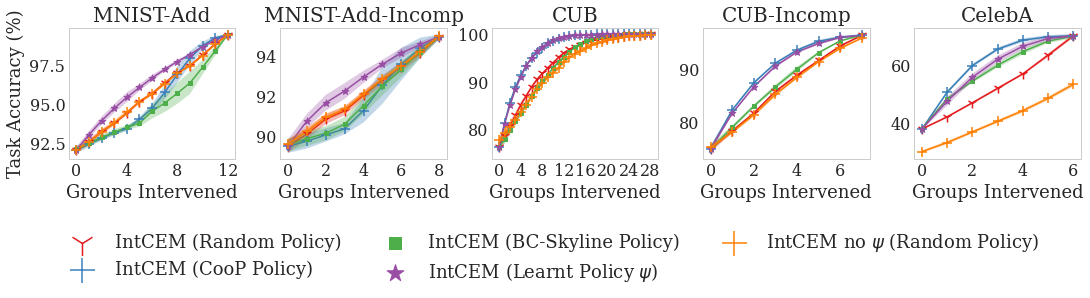

In [13]:

import itertools
clrs = sns.color_palette("Set1", 5)
color_map = {}
model_name_to_marker = {
    'IntAwareConceptEmbeddingModel': '*',
    'ConceptBottleneckModelLogit': '.',
    'ConceptBottleneckModelSigmoid': 'x',
    'ConceptEmbeddingModel': 'd',
    'SequentialConceptBottleneckModel': 's',
    'IndependentConceptBottleneckModel': 'o',
}
used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random"),
}
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
all_filtered_results = {}
labels = []
handles = []
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10)
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10)
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )

width = 3
height = 3
label_size = 18
title_size = 20
legend_size = 18
tick_size = 16
marker_size_large = 100
square_marker_size = 20
marker_size_small = marker_size_large/2
markerscale = 2.5
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*width, height),
    squeeze=False,
)
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    markers = itertools.cycle(('1', '+', 'o', 'd', 's' ,'v'))
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)

    model_names = [sorted_intcem_models[0][1]] + [
        name for name in dataset_results['test_acc_y'].keys()
        if (name.startswith("IntAware") and "_intervention_weight_0_" in name)
    ] + [
        # 'ConceptEmbeddingModel',
        # 'ConceptBottleneckModelLogit',
        # 'ConceptBottleneckModelSigmoid',
        # 'SequentialConceptBottleneckModel',
        # 'IndependentConceptBottleneckModel',
    ]
    print(model_names)
    for method_idx, method_name in enumerate(model_names):
        ax = axs[0, dataset_idx]
        marker = model_name_to_marker.get(method_name,'.')
        human_policy_name, policy_name = used_policies.get(
            method_name,
            ("CooP", "group_coop_no_prior"),
        )
        if method_name.startswith("IntAwareConceptEmbeddingModel"):
            marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
            config = model_configs[dataset_name][method_name]
            print(config['intervention_weight'], config['horizon_rate'], method_name)
            if config['intervention_weight'] != 0:
                human_policy_name, policy_name = "Learnt", "group_random"
                method_to_actual_name[method_name] = "IntCEM"
                # Also the results of following a random trajectory
                og_method_name = method_name
                means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name="group_random_no_prior")
                method_name = method_to_actual_name.get(method_name, method_name)
                if (method_name, "Random") not in color_map:
                    color_map[(method_name, "Random")] = clrs[len(color_map)]
                color = color_map[(method_name, "Random")]
                x_vals = list(range(0, len(means), 1))
                ax.plot(
                    x_vals,
                    means,
                    c=color,
                    zorder=1,
                )
                curr_marker = next(markers)
                ax.scatter(
                    x_vals,
                    means,
                    s=marker_size_large if curr_marker in ['+', 'x', '1'] else marker_size_small,
                    label=f'{method_name} (Random Policy)',
                    color=color,
                    zorder=2,
                    marker=curr_marker,
                )
                ax.fill_between(
                    x_vals,
                    means - stds,
                    means + stds,
                    alpha=0.3,
                    facecolor=color,
                )
                new_handles, new_labels = ax.get_legend_handles_labels()
                for label, handle in zip(new_labels, new_handles):
                    if label not in labels:
                        labels.append(label)
                        handles.append(handle)

                means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name="group_coop_no_prior")
                method_name = method_to_actual_name.get(og_method_name, og_method_name)
                if (method_name, "CooP") not in color_map:
                    color_map[(method_name, "CooP")] = clrs[len(color_map)]
                color = color_map[(method_name, "CooP")]
                x_vals = list(range(0, len(means), 1))
                ax.plot(
                    x_vals,
                    means,
                    c=color,
                    zorder=1,
                )
                curr_marker = next(markers)
                ax.scatter(
                    x_vals,
                    means,
                    s=marker_size_large if curr_marker in ['+', 'x', '1'] else marker_size_small,
                    label=f'{method_name} (CooP Policy)',
                    color=color,
                    zorder=2,
                    marker=curr_marker,
                )
                ax.fill_between(
                    x_vals,
                    means - stds,
                    means + stds,
                    alpha=0.3,
                    facecolor=color,
                )
                new_handles, new_labels = ax.get_legend_handles_labels()
                for label, handle in zip(new_labels, new_handles):
                    if label not in labels:
                        labels.append(label)
                        handles.append(handle)


                means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name="behavioural_cloning_no_prior")
                method_name = method_to_actual_name.get(og_method_name, og_method_name)
                if (method_name, "Behavioural Cloning") not in color_map:
                    color_map[(method_name, "Behavioural Cloning")] = clrs[len(color_map)]
                color = color_map[(method_name, "Behavioural Cloning")]
                x_vals = list(range(0, len(means), 1))
                ax.plot(
                    x_vals,
                    means,
                    c=color,
                    zorder=1,
                )
                curr_marker = "s"
                ax.scatter(
                    x_vals,
                    means,
                    s=square_marker_size,
                    label=f'{method_name} (BC-Skyline Policy)',
                    color=color,
                    zorder=2,
                    marker=curr_marker,
                )
                ax.fill_between(
                    x_vals,
                    means - stds,
                    means + stds,
                    alpha=0.3,
                    facecolor=color,
                )
                new_handles, new_labels = ax.get_legend_handles_labels()
                for label, handle in zip(new_labels, new_handles):
                    if label not in labels:
                        labels.append(label)
                        handles.append(handle)

                method_name = og_method_name
            else:
                human_policy_name, policy_name = "Random", "group_random_no_prior"
                method_to_actual_name[method_name] = "IntCEM no $\psi$"
                marker = "+"

        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        config = model_configs[dataset_name][method_name]

        if policy_name == "group_random" and "IntAware" in method_name:
            human_policy_name = "Learnt"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        print("\t means =", means)
        print("\t stds =", stds)
        method_name = method_to_actual_name.get(method_name, method_name)
        if method_name not in color_map:
            color_map[method_name] = clrs[len(color_map)]
        color = color_map[method_name]
        x_vals = list(range(0, len(means), 1))
        ax.plot(
            x_vals,
            means,
            c=color,
            zorder=1,
        )
        ax.scatter(
            x_vals,
            means,
            s=marker_size_large if marker in ['+', 'x', '1'] else marker_size_small,
            label=f'{method_name} ({human_policy_name} Policy)' if human_policy_name != "Learnt" else f'{method_name} ({human_policy_name} Policy $\psi$)',
            color=color,
            zorder=2,
            marker=marker,
        )
        ax.fill_between(
            x_vals,
            means - stds,
            means + stds,
            alpha=0.3,
            facecolor=color,
        )
        new_handles, new_labels = ax.get_legend_handles_labels()
        for label, handle in zip(new_labels, new_handles):
            if label not in labels:
                labels.append(label)
                handles.append(handle)
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)
    ax.set_xticks(x_vals[::2] if len(x_vals) < 10 else x_vals[::4])
    ax.set_xlabel(f"Groups Intervened", fontsize=label_size)
    ax.set_title(dataset_name, fontsize=title_size)
    if dataset_idx == 0:
        ax.set_ylabel(f"Task Accuracy (%)", fontsize=label_size)
    ax.grid(False)
    # handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=legend_size,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=3,
    markerscale=markerscale,
)
plt.tight_layout()
plt.savefig("figures/intcem_policy_results.pdf", bbox_inches='tight')
plt.savefig("figures/intcem_policy_results.png", bbox_inches='tight')
plt.show()

In [17]:
model_names = [
    'IntAwareConceptEmbeddingModel',
    # 'ConceptEmbeddingModel',
]

policy_names = [
    ("Random", "group_random_no_prior"),
    ("CooP", "group_coop_no_prior"),
    ("Learnt Policy", "group_random"),
    # ("Uncertainty of Concept Prediction (UCP)", "group_uncertainty_no_prior"),
    # ("UCP", "group_uncertainty_no_prior"),
    ("BC-Skyline", "behavioural_cloning_no_prior"),
    # ("Concept Validation Accuracy (CVA)", "global_val_error_no_prior"),
    # ("CVA", "global_val_error_no_prior"),
    # ("Concept Validation Improvement (CVI)", "global_val_improvement_no_prior"),
    # ("CVI", "global_val_improvement_no_prior"),
    # ("Skyline", "optimal_greedy_no_prior"),
]
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
all_filtered_results = {}
labels = []
handles = []
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10)
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10)
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )

n_cols = len(policy_names) * len(model_names)
table_str = r'\begin{tabular}{p{4pt}c|' + ("c" * len(policy_names)) + '|c}\n'
table_str += "{} & {Dataset} &\n"
for human_policy_name, _ in policy_names:
    table_str += f"\t{human_policy_name} &\n"
table_str += f"\tIntCEM no $\psi$ (Random)" + r" \\ \toprule"+ "\n"
for percent in [0.25, 0.5, 0.75, 1]:
    done = False
    for dataset_idx, dataset_name in enumerate(datasets_to_use):
        dataset_results = all_filtered_results[dataset_name]
        method_to_actual_name = {
            'ConceptEmbeddingModel': 'CEM',
            'ConceptBottleneckModelLogit': "Joint CBM-Logit",
            'ConceptBottleneckModelLogit_long': "Joint CBM-Logit",
            'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
            'ConceptBottleneckModelSigmoid_long': "Joint CBM-Sigmoid",
            "ConceptBottleneckModelSigmoid_concept_loss_weight_1": "Joint CBM-Sigmoid",
            'SequentialConceptBottleneckModel': "Sequential CBM",
            'SequentialConceptBottleneckModel_long': "Sequential CBM",
            'IndependentConceptBottleneckModel': "Independent CBM",
            'IndependentConceptBottleneckModel_long': "Independent CBM",
        }
        intcem_models = [
            name for name in dataset_results['test_acc_y'].keys()
            if name.startswith("IntAware")
        ]
        sorted_intcem_models = []
        for method_idx, method_name in enumerate(intcem_models):
            human_policy_name, policy_name = ("Random", "group_random")
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
            area = means[0] * np.trapz(means)
            sorted_intcem_models.append((area, method_name))
            method_name = method_to_actual_name.get(method_name, method_name)
        sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
        used_model_names = [sorted_intcem_models[0][1]] + [
            name for name in dataset_results['test_acc_y'].keys()
            if (name.startswith("IntAware") and "_intervention_weight_0_" in name)
        ] 
        print(used_model_names)
        print(method_to_actual_name)
        if not done:
            table_str += "\t{\parbox[t]{10mm}{\multirow{" + str(len(datasets_to_use)) + "}{*}{\\rotatebox{90}{\\text{" + f"{int(percent*100)}\%" + "}}}}} & \\texttt{" + dataset_name + "} &\n"
            done = True
        else:
            table_str += "{} & \\texttt{" + dataset_name + "} &\n"
        for method_idx, method_name in enumerate(used_model_names):
            og_method_name = method_name
            for human_policy_name, policy_name in policy_names:
                if (
                    og_method_name.startswith("IntAware") and
                    ("_intervention_weight_0_" in og_method_name)
                ):
                    if policy_name != "group_random_no_prior":
                        continue
                    method_to_actual_name[og_method_name] = "IntCEM no $\psi$"
                elif og_method_name.startswith("IntAwareConceptEmbeddingModel"):
                    method_to_actual_name[og_method_name] = "IntCEM"
                if og_method_name not in method_to_actual_name:
                    print("HERE WITH", og_method_name)
                    continue
                means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
                method_name = method_to_actual_name.get(og_method_name, og_method_name)
                idx = int(np.floor((len(means) - 1) * percent))
                table_str += f"    {means[idx]:.2f} ± {stds[idx]:.2f} &\n"
                print(og_method_name, human_policy_name, dataset_name, percent)
        table_str = table_str [:-2] + " \\\\\n"
    table_str = table_str [:-2] + " \\\\ \hline\n"
print(table_str)

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

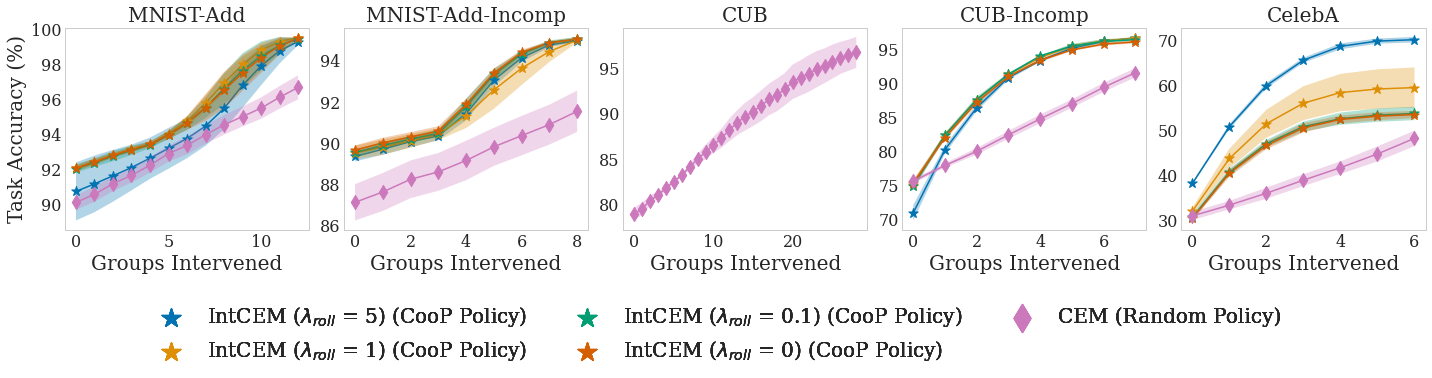

In [16]:

clrs = sns.color_palette("colorblind", 30)
color_map = {}
model_name_to_marker = {
    'IntAwareConceptEmbeddingModel': '*',
    'ConceptBottleneckModelLogit': '.',
    'ConceptBottleneckModelSigmoid': 'x',
    'ConceptEmbeddingModel': 'd',
    'SequentialConceptBottleneckModel': 's',
    'IndependentConceptBottleneckModel': 'o',
}
used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random_no_prior"),
    'ConceptEmbeddingModel': ("Random", "group_random_no_prior"),
}
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
all_filtered_results = {}
labels = []
handles = []
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.1) == 1.1) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*4, 4),
    squeeze=False,
)
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    model_names = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ] + [
        'ConceptEmbeddingModel',
        # 'ConceptBottleneckModelLogit',
        # 'ConceptBottleneckModelSigmoid',
        # 'SequentialConceptBottleneckModel',
        # 'IndependentConceptBottleneckModel',
    ]
    print(model_names)
    for method_idx, method_name in enumerate(model_names):
        ax = axs[0, dataset_idx]
        marker = model_name_to_marker.get(method_name,'.')
        human_policy_name, policy_name = used_policies.get(
            method_name,
            ("CooP", "group_coop_no_prior"),
        )
        if method_name.startswith("IntAwareConceptEmbeddingModel"):
            # method_name = intcem_var_names[dataset_name]
            # method_to_actual_name[method_name] = "IntCEM"
            marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
            config = model_configs[dataset_name][method_name]
            print(config['intervention_weight'], config['horizon_rate'], method_name)
            method_to_actual_name[method_name] = "IntCEM ($\\lambda_{roll}$ =" + f" {config['intervention_weight']}"
            method_to_actual_name[method_name] += ")"
        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        config = model_configs[dataset_name][method_name]
        
        if policy_name == "group_random" and "IntAware" in method_name:
            human_policy_name = "Learnt"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        print("\t means =", means)
        print("\t stds =", stds)
        method_name = method_to_actual_name.get(method_name, method_name)
        if method_name not in color_map:
            color_map[method_name] = clrs[len(color_map)]
        color = color_map[method_name]
        x_vals = list(range(0, len(means), 1))
        ax.plot(
            x_vals,
            means,
            c=color,
            zorder=1,
        )
        ax.scatter(
            x_vals,
            means,
            s=100,
            label=f'{method_name} ({human_policy_name} Policy)',
            color=color,
            zorder=2,
            marker=marker,
        )
        ax.fill_between(
            x_vals,
            means - stds,
            means + stds,
            alpha=0.3,
            facecolor=color,
        )
        new_handles, new_labels = ax.get_legend_handles_labels()
        for label, handle in zip(new_labels, new_handles):
            if label not in labels:
                labels.append(label)
                handles.append(handle)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_xlabel(f"Groups Intervened", fontsize=20)
    ax.set_title(dataset_name, fontsize=20)
    if dataset_idx == 0:
        ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
    ax.grid(False)
    # handles, labels = ax.get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        fontsize=20,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=3,
        markerscale=2,
    )
plt.tight_layout()
plt.savefig("figures/intcem_int_weight_random_results.pdf", bbox_inches='tight')
plt.savefig("figures/intcem_int_weight_random_results.png", bbox_inches='tight')
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

IndexError: list index out of range

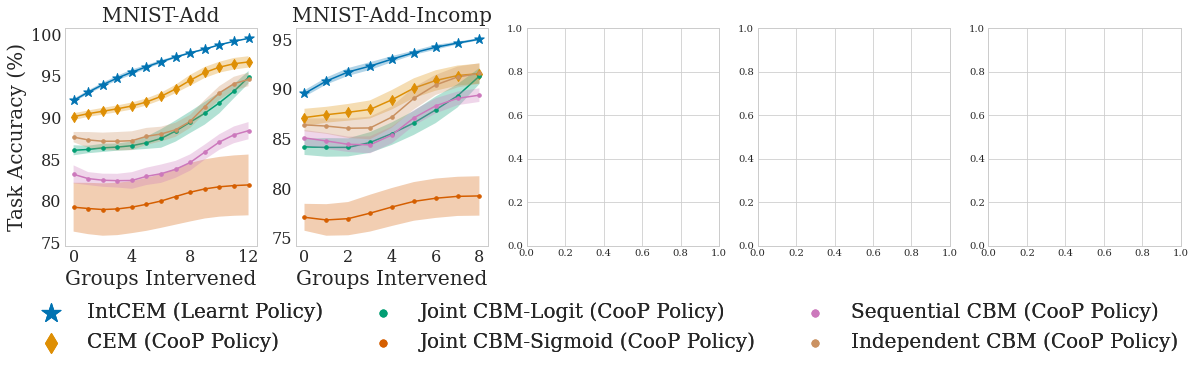

In [17]:

clrs = sns.color_palette("colorblind", 15)
color_map = {}
model_name_to_marker = {
    'IntAwareConceptEmbeddingModel': '*',
    'ConceptBottleneckModelLogit': '.',
    'ConceptBottleneckModelSigmoid': 'x',
    'ConceptEmbeddingModel': 'd',
    'SequentialConceptBottleneckModel': 's',
    'IndependentConceptBottleneckModel': 'o',
}
used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random"),
}
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.1) == 1.1) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*4, 4),
    squeeze=False,
)
labels = []
handles = []
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelLogit_long': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'ConceptBottleneckModelSigmoid_long': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'SequentialConceptBottleneckModel_long': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
        'IndependentConceptBottleneckModel_long': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    if "MNIST" in dataset_name:
        model_names = [sorted_intcem_models[0][1]] + [
            'ConceptEmbeddingModel',
            'ConceptBottleneckModelLogit_long',
            'ConceptBottleneckModelSigmoid_long',
            'SequentialConceptBottleneckModel_long',
            'IndependentConceptBottleneckModel_long',
        ]
    else:
        model_names = [sorted_intcem_models[0][1]] + [
            'ConceptEmbeddingModel',
            'ConceptBottleneckModelLogit',
            'ConceptBottleneckModelSigmoid',
            'SequentialConceptBottleneckModel',
            'IndependentConceptBottleneckModel',
        ]
    
    print(model_names)
    for method_idx, method_name in enumerate(model_names):
        ax = axs[0, dataset_idx]
        marker = model_name_to_marker.get(method_name,'.')
        human_policy_name, policy_name = used_policies.get(
            method_name,
            ("CooP", "group_coop_no_prior"),
        )
        if method_name.startswith("IntAwareConceptEmbeddingModel"):
            marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
            human_policy_name, policy_name = "Learnt", "group_random"
            print(config['intervention_weight'], config['horizon_rate'], method_name)
            method_to_actual_name[method_name] = "IntCEM"
        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        if policy_name == "group_random" and "IntAware" in method_name:
            human_policy_name = "Learnt"
        means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
        method_name = method_to_actual_name.get(method_name, method_name)
        print("For", dataset_name, "and method", og_method_name)
        print("\tmeans =", means)
        print("\tstds =", stds)
        if method_name not in color_map:
            color_map[method_name] = clrs[len(color_map)]
        color = color_map[method_name]
        x_vals = list(range(0, len(means), 1))
        ax.plot(
            x_vals,
            means,
            c=color,
            zorder=1,
        )
        ax.scatter(
            x_vals,
            means,
            s=100 if marker in ["+", "*"] else 50,
            label=f'{method_name} ({human_policy_name} Policy)',
            color=color,
            zorder=2,
            marker=marker,
        )
        ax.fill_between(
            x_vals,
            means - stds,
            means + stds,
            alpha=0.3,
            facecolor=color,
        )
        new_handles, new_labels = ax.get_legend_handles_labels()
        for label, handle in zip(new_labels, new_handles):
            if label not in labels:
                labels.append(label)
                handles.append(handle)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.set_xticks(x_vals[::2] if len(x_vals) < 10 else x_vals[::4])
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_xlabel(f"Groups Intervened", fontsize=20)
    ax.set_title(dataset_name, fontsize=20)
    if dataset_idx == 0:
        ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
    ax.grid(False)
    # handles, labels = ax.get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        fontsize=20,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=3,
        markerscale=2,
    )
plt.savefig("figures/intervention_results.pdf", bbox_inches='tight')
plt.savefig("figures/intervention_results.png", bbox_inches='tight')
plt.tight_layout()
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

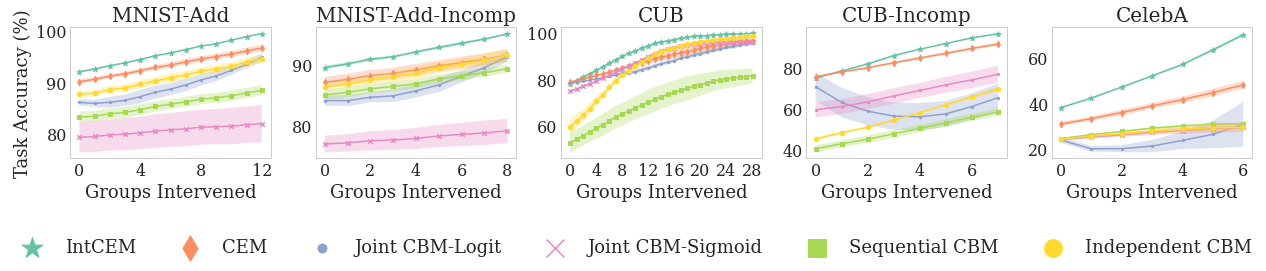

In [ ]:

clrs = sns.color_palette("Set2", 15)
color_map = {}
model_name_to_marker = {
    'IntAwareConceptEmbeddingModel': '*',
    'ConceptBottleneckModelLogit': '.',
    'ConceptBottleneckModelLogit_long': '.',
    'ConceptBottleneckModelSigmoid': 'x',
    'ConceptBottleneckModelSigmoid_long': 'x',
    'ConceptEmbeddingModel': 'd',
    'SequentialConceptBottleneckModel': 's',
    'SequentialConceptBottleneckModel_long': 's',
    'IndependentConceptBottleneckModel': 'o',
    'IndependentConceptBottleneckModel_long': 'o',
}
used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random_no_prior"),
}
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    if dataset_name == "CUB-Incomp":
        def _current_filter(config):
            return (
                (config['architecture'] == 'ConceptBottleneckModel') and 
                (
                    ("Sigmoid" in config['extra_name']) and
                    ("Sigmoid_concept" not in config['extra_name'])
                )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )
width = 3.5
height = 3
label_size = 18
title_size = 20
legend_size = 18
tick_size = 16
marker_size_large = 30
marker_size_small = marker_size_large/1.5
markerscale = 4
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*width, height),
    squeeze=False,
)
labels = []
handles = []
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelLogit_long': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'ConceptBottleneckModelSigmoid_long': "Joint CBM-Sigmoid",
        "ConceptBottleneckModelSigmoid_concept_loss_weight_1": "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'SequentialConceptBottleneckModel_long': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
        'IndependentConceptBottleneckModel_long': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
        human_policy_name, policy_name = ("Random", "group_random")
        config = model_configs[dataset_name][method_name]
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = means[0] * np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    if "MNIST" in dataset_name:
        model_names = [sorted_intcem_models[0][1]] + [
            'ConceptEmbeddingModel',
            'ConceptBottleneckModelLogit_long',
            'ConceptBottleneckModelSigmoid_long',
            'SequentialConceptBottleneckModel_long',
            'IndependentConceptBottleneckModel_long',
        ]
    else:
        model_names = [sorted_intcem_models[0][1]] + [
            'ConceptEmbeddingModel',
            'ConceptBottleneckModelLogit',
            'ConceptBottleneckModelSigmoid' if dataset_name != 'CUB-Incomp' else 'ConceptBottleneckModelSigmoid_concept_loss_weight_1',
            'SequentialConceptBottleneckModel',
            'IndependentConceptBottleneckModel',
        ]
    
    print(model_names)
    for method_idx, method_name in enumerate(model_names):
        ax = axs[0, dataset_idx]
        marker = model_name_to_marker.get(method_name,'.')
        human_policy_name, policy_name = used_policies.get(
            method_name,
            ("Random", "group_random_no_prior"),
        )
        if method_name.startswith("IntAwareConceptEmbeddingModel"):
            marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
            print(config['intervention_weight'], config['horizon_rate'], method_name)
            method_to_actual_name[method_name] = "IntCEM"
        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
        method_name = method_to_actual_name.get(method_name, method_name)
        print("For", dataset_name, "and method", og_method_name)
        print("\tmeans =", means)
        print("\tstds =", stds)
        if method_name not in color_map:
            color_map[method_name] = clrs[len(color_map)]
        color = color_map[method_name]
        x_vals = list(range(0, len(means), 1))
        ax.plot(
            x_vals,
            means,
            c=color,
            zorder=1,
        )
        ax.scatter(
            x_vals,
            means,
            s=marker_size_large if marker in ["+", "*"] else marker_size_small,
            label=f'{method_name}', # ({human_policy_name} Policy)',
            color=color,
            zorder=2,
            marker=marker,
        )
        ax.fill_between(
            x_vals,
            means - stds,
            means + stds,
            alpha=0.3,
            facecolor=color,
        )
        new_handles, new_labels = ax.get_legend_handles_labels()
        for label, handle in zip(new_labels, new_handles):
            if label not in labels:
                labels.append(label)
                handles.append(handle)
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.set_xticks(x_vals[::2] if len(x_vals) < 10 else x_vals[::4])
    ax.yaxis.set_tick_params(labelsize=tick_size)
    ax.set_xlabel(f"Groups Intervened", fontsize=label_size)
    ax.set_title(dataset_name, fontsize=title_size)
    if dataset_idx == 0:
        ax.set_ylabel(f"Task Accuracy (%)", fontsize=label_size)
    ax.grid(False)
    # handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=legend_size,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.05),
    ncol=6,
    markerscale=markerscale,
)
plt.tight_layout()
plt.savefig("figures/intervention_results_with_random.pdf", bbox_inches='tight')
plt.savefig("figures/intervention_results_with_random.png", bbox_inches='tight')
plt.show()

In [11]:

used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random_no_prior"),
}
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    if dataset_name == "CUB-Incomp":
        def _current_filter(config):
            return (
                (config['architecture'] == 'ConceptBottleneckModel') and 
                (
                    ("Sigmoid" in config['extra_name']) and
                    ("Sigmoid_concept" not in config['extra_name'])
                )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )

strs = []
for percent in [0.25, 0.5, 0.75, 1]:
    table_str = ""
    for dataset_idx, dataset_name in enumerate(datasets_to_use):
        dataset_results = all_filtered_results[dataset_name]
        method_to_actual_name = {
            'ConceptEmbeddingModel': 'CEM',
            'ConceptBottleneckModelLogit': "Joint CBM-Logit",
            'ConceptBottleneckModelLogit_long': "Joint CBM-Logit",
            'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
            'ConceptBottleneckModelSigmoid_long': "Joint CBM-Sigmoid",
            "ConceptBottleneckModelSigmoid_concept_loss_weight_1": "Joint CBM-Sigmoid",
            'SequentialConceptBottleneckModel': "Sequential CBM",
            'SequentialConceptBottleneckModel_long': "Sequential CBM",
            'IndependentConceptBottleneckModel': "Independent CBM",
            'IndependentConceptBottleneckModel_long': "Independent CBM",
        }
        intcem_models = [
            name for name in dataset_results['test_acc_y'].keys()
            if name.startswith("IntAware")
        ]
        sorted_intcem_models = []
        for method_idx, method_name in enumerate(intcem_models):
            human_policy_name, policy_name = ("Random", "group_random")
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
            area = means[0] * np.trapz(means)
            sorted_intcem_models.append((area, method_name))
            method_name = method_to_actual_name.get(method_name, method_name)
        sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
        if "MNIST" in dataset_name:
            model_names = [sorted_intcem_models[0][1]] + [
                'ConceptEmbeddingModel',
                'ConceptBottleneckModelLogit_long',
                'ConceptBottleneckModelSigmoid_long',
                'SequentialConceptBottleneckModel_long',
                'IndependentConceptBottleneckModel_long',
            ]
        else:
            model_names = [sorted_intcem_models[0][1]] + [
                'ConceptEmbeddingModel',
                'ConceptBottleneckModelSigmoid' if dataset_name != 'CUB-Incomp' else 'ConceptBottleneckModelSigmoid_concept_loss_weight_1',
                'ConceptBottleneckModelLogit',
                'IndependentConceptBottleneckModel',
                'SequentialConceptBottleneckModel',
            ]
        if table_str == "":
            table_str = "{\parbox[t]{10mm}{\multirow{5}{*}{\\rotatebox{90}{\\text{" + f"{int(percent*100)}\%" + "}}}}} & \\texttt{" + dataset_name + "} &\n"
        else:
            table_str += "{} & \\texttt{" + dataset_name + "} &\n"
        for method_idx, method_name in enumerate(model_names):
            human_policy_name, policy_name = used_policies.get(
                method_name,
                ("Random", "group_random_no_prior"),
            )
            if method_name.startswith("IntAwareConceptEmbeddingModel"):
                method_to_actual_name[method_name] = "IntCEM (Random)"
            if method_name not in method_to_actual_name:
                continue
            og_method_name = method_name
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            method_name = method_to_actual_name.get(method_name, method_name)
            # print(f"[Percent {int(percent*100)}%] For", dataset_name, "and method", method_name)
            idx = int(np.floor((len(means) - 1) * percent))
            # print(f"\tvalue = {means[idx]:.2f} ± {stds[idx]:.2f}")
            table_str += f"    {means[idx]:.2f} ± {stds[idx]:.2f} &\n"
        method_name = model_names[0]
        human_policy_name, policy_name = used_policies.get(
            method_name,
            ("Learnt Policy $\psi$", "group_random"),
        )
        if method_name.startswith("IntAwareConceptEmbeddingModel"):
            method_to_actual_name[method_name] = "IntCEM (Learnt Policy $\psi$)"
        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
        method_name = method_to_actual_name.get(method_name, method_name)
        # print(f"[Percent {int(percent*100)}%] For", dataset_name, "and method", method_name)
        idx = int(np.floor((len(means) - 1) * percent))
        # print(f"\tvalue = {means[idx]:.2f} ± {stds[idx]:.2f}")
        table_str += f"    {means[idx]:.2f} ± {stds[idx]:.2f} \\\\"
    table_str += " \hline\n"
    strs.append(table_str)
    print(table_str)

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

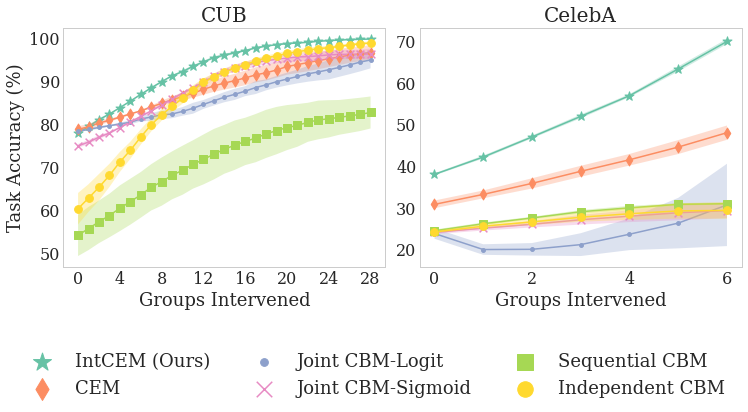

In [18]:

clrs = sns.color_palette("Set2", 15)
color_map = {}
model_name_to_marker = {
    'IntAwareConceptEmbeddingModel': '*',
    'ConceptBottleneckModelLogit': '.',
    'ConceptBottleneckModelLogit_long': '.',
    'ConceptBottleneckModelSigmoid': 'x',
    'ConceptBottleneckModelSigmoid_long': 'x',
    'ConceptEmbeddingModel': 'd',
    'SequentialConceptBottleneckModel': 's',
    'SequentialConceptBottleneckModel_long': 's',
    'IndependentConceptBottleneckModel': 'o',
    'IndependentConceptBottleneckModel_long': 'o',
}
used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random_no_prior"),
}
datasets_to_use = [
    # "MNIST-Add",
    # "MNIST-Add-Incomp",
    "CUB",
    # "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    if dataset_name == "CUB-Incomp":
        def _current_filter(config):
            return (
                (config['architecture'] == 'ConceptBottleneckModel') and 
                (
                    ("Sigmoid" in config['extra_name']) and
                    ("Sigmoid_concept" not in config['extra_name'])
                )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )
width = 3.5 * 1.5
height = 3 * 1.5
label_size = 18
title_size = 20
legend_size = 18
tick_size = 16
marker_size_large = 30 * 3
marker_size_small = marker_size_large/1.5
markerscale = 2
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*width, height),
    squeeze=False,
)
labels = []
handles = []
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelLogit_long': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'ConceptBottleneckModelSigmoid_long': "Joint CBM-Sigmoid",
        "ConceptBottleneckModelSigmoid_concept_loss_weight_1": "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'SequentialConceptBottleneckModel_long': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
        'IndependentConceptBottleneckModel_long': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
        human_policy_name, policy_name = ("Random", "group_random")
        config = model_configs[dataset_name][method_name]
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = means[0] * np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    if "MNIST" in dataset_name:
        model_names = [sorted_intcem_models[0][1]] + [
            'ConceptEmbeddingModel',
            'ConceptBottleneckModelLogit_long',
            'ConceptBottleneckModelSigmoid_long',
            'SequentialConceptBottleneckModel_long',
            'IndependentConceptBottleneckModel_long',
        ]
    else:
        model_names = [sorted_intcem_models[0][1]] + [
            'ConceptEmbeddingModel',
            'ConceptBottleneckModelLogit',
            'ConceptBottleneckModelSigmoid' if dataset_name != 'CUB-Incomp' else 'ConceptBottleneckModelSigmoid_concept_loss_weight_1',
            'SequentialConceptBottleneckModel',
            'IndependentConceptBottleneckModel',
        ]
    
    print(model_names)
    for method_idx, method_name in enumerate(model_names):
        ax = axs[0, dataset_idx]
        marker = model_name_to_marker.get(method_name,'.')
        human_policy_name, policy_name = used_policies.get(
            method_name,
            ("Random", "group_random_no_prior"),
        )
        if method_name.startswith("IntAwareConceptEmbeddingModel"):
            marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
            print(config['intervention_weight'], config['horizon_rate'], method_name)
            method_to_actual_name[method_name] = "IntCEM (Ours)"
        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
        method_name = method_to_actual_name.get(method_name, method_name)
        print("For", dataset_name, "and method", og_method_name)
        print("\tmeans =", means)
        print("\tstds =", stds)
        if method_name not in color_map:
            color_map[method_name] = clrs[len(color_map)]
        color = color_map[method_name]
        x_vals = list(range(0, len(means), 1))
        ax.plot(
            x_vals,
            means,
            c=color,
            zorder=1,
        )
        ax.scatter(
            x_vals,
            means,
            s=marker_size_large if marker in ["+", "*"] else marker_size_small,
            label=f'{method_name}', # ({human_policy_name} Policy)',
            color=color,
            zorder=2,
            marker=marker,
        )
        ax.fill_between(
            x_vals,
            means - stds,
            means + stds,
            alpha=0.3,
            facecolor=color,
        )
        new_handles, new_labels = ax.get_legend_handles_labels()
        for label, handle in zip(new_labels, new_handles):
            if label not in labels:
                labels.append(label)
                handles.append(handle)
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.set_xticks(x_vals[::2] if len(x_vals) < 10 else x_vals[::4])
    ax.yaxis.set_tick_params(labelsize=tick_size)
    ax.set_xlabel(f"Groups Intervened", fontsize=label_size)
    ax.set_title(dataset_name, fontsize=title_size)
    if dataset_idx == 0:
        ax.set_ylabel(f"Task Accuracy (%)", fontsize=label_size)
    ax.grid(False)
    # handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=legend_size,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.05),
    ncol=3,
    markerscale=markerscale,
)
plt.tight_layout()
plt.savefig("figures/intervention_results_with_random_smaller.pdf", bbox_inches='tight')
plt.savefig("figures/intervention_results_with_random_smaller.png", bbox_inches='tight')
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

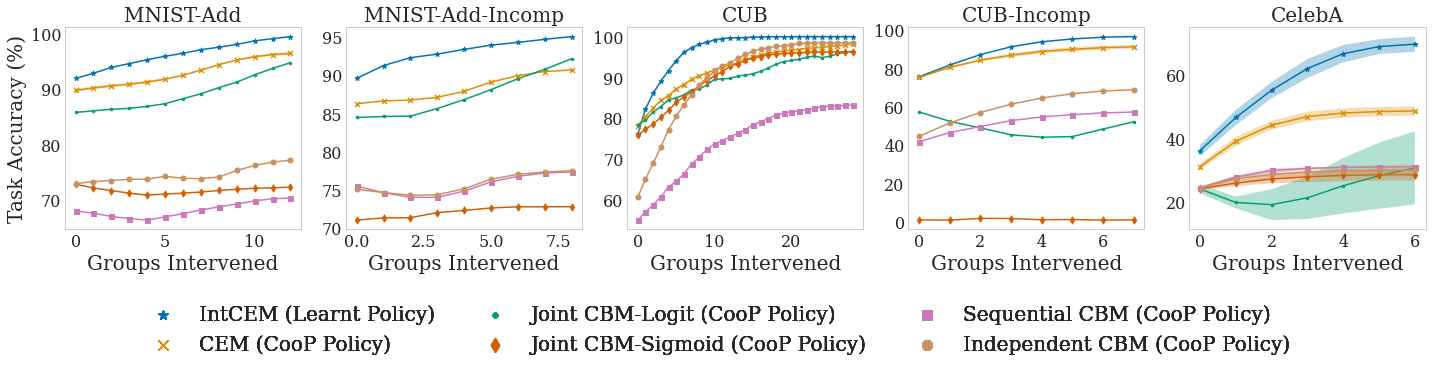

In [ ]:

clrs = sns.color_palette("colorblind", 30)
color_map = {}
model_name_to_marker = {
    'IntAwareConceptEmbeddingModel': '*',
    'ConceptBottleneckModelLogit': '.',
    'ConceptBottleneckModelSigmoid': 'd',
    'ConceptEmbeddingModel': 'x',
    'SequentialConceptBottleneckModel': 's',
    'IndependentConceptBottleneckModel': 'o',
}
used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random"),
}
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.1) == 1.1) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*4, 4),
    squeeze=False,
)
labels = []
handles = []
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    model_names = [sorted_intcem_models[0][1]] + [
        'ConceptEmbeddingModel',
        'ConceptBottleneckModelLogit',
        'ConceptBottleneckModelSigmoid',
        'SequentialConceptBottleneckModel',
        'IndependentConceptBottleneckModel',
    ]
    
    print(model_names)
    for method_idx, method_name in enumerate(model_names):
        ax = axs[0, dataset_idx]
        marker = model_name_to_marker.get(method_name,'.')
        human_policy_name, policy_name = used_policies.get(
            method_name,
            ("CooP", "group_coop_no_prior"),
        )
        if method_name.startswith("IntAwareConceptEmbeddingModel"):
            marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
            human_policy_name, policy_name = "Learnt", "group_random"
            print(config['intervention_weight'], config['horizon_rate'], method_name)
            method_to_actual_name[method_name] = "IntCEM"
        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        if policy_name == "group_random" and "IntAware" in method_name:
            human_policy_name = "Learnt"
        means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
        method_name = method_to_actual_name.get(method_name, method_name)
        if method_name not in color_map:
            color_map[method_name] = clrs[len(color_map)]
        color = color_map[method_name]
        x_vals = list(range(0, len(means), 1))
        ax.plot(
            x_vals,
            means,
            c=color,
            zorder=1,
        )
        ax.scatter(
            x_vals,
            means,
            s=25,
            label=f'{method_name} ({human_policy_name} Policy)',
            color=color,
            zorder=2,
            marker=marker,
        )
        ax.fill_between(
            x_vals,
            means - stds,
            means + stds,
            alpha=0.3,
            facecolor=color,
        )
        new_handles, new_labels = ax.get_legend_handles_labels()
        for label, handle in zip(new_labels, new_handles):
            if label not in labels:
                labels.append(label)
                handles.append(handle)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_xlabel(f"Groups Intervened", fontsize=20)
    ax.set_title(dataset_name, fontsize=20)
    if dataset_idx == 0:
        ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
    ax.grid(False)
    # handles, labels = ax.get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        fontsize=20,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=3,
        markerscale=2,
    )
plt.tight_layout()
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

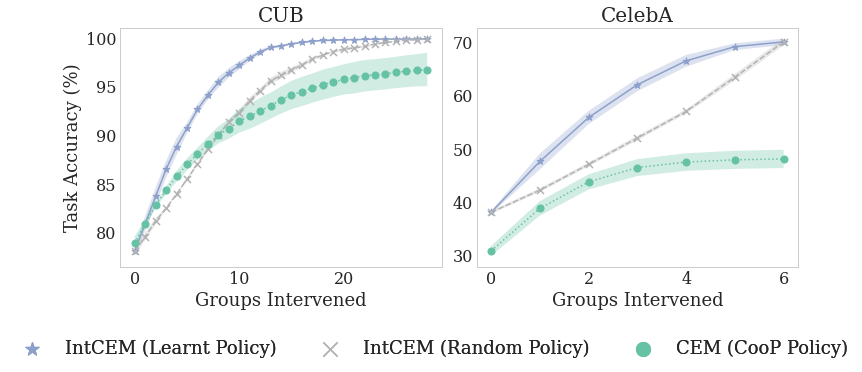

In [29]:

# clrs = sns.color_palette("colorblind", 30)
# color_map = {}
model_names = [
    'IntAwareConceptEmbeddingModel',
    'ConceptEmbeddingModel',
]
datasets_to_use = [
    # "MNIST-Add",
    # "MNIST-Add-Incomp",
    "CUB",
    # "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]

all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    if dataset_name == "CUB-Incomp":
        def _current_filter(config):
            return (
                (config['architecture'] == 'ConceptBottleneckModel') and 
                (
                    ("Sigmoid" in config['extra_name']) and
                    ("Sigmoid_concept" not in config['extra_name'])
                )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )

width = 3.5 * 1.5
height = 3 * 1.5
label_size = 18
title_size = 20
legend_size = 18
tick_size = 16
marker_size_large = 30 * 3
marker_size_small = marker_size_large/1.5
markerscale = 2
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*width, height),
    squeeze=False,
)
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = means[0] * np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    model_names = [sorted_intcem_models[0][1]] + [
        'ConceptEmbeddingModel',
        # 'ConceptBottleneckModelLogit',
        # 'ConceptBottleneckModelSigmoid',
        # 'SequentialConceptBottleneckModel',
        # 'IndependentConceptBottleneckModel',
    ]
    for method_idx, method_name in enumerate(model_names):
        ax = axs[0, dataset_idx]
        if method_name.startswith("IntAwareConceptEmbeddingModel"):
            human_policy_name, policy_name = "Learnt", "group_random"
            method_to_actual_name[method_name] = "IntCEM"
            marker = "*"
            if ("IntCEM", policy_name) not in color_map:
                color_map[("IntCEM", policy_name)] = clrs[len(color_map)]
            color = color_map[("IntCEM", policy_name)]
        else:
            human_policy_name, policy_name = "CooP", "group_coop_no_prior"
            marker = "o"
            if method_name not in color_map:
                color_map[method_name] = clrs[len(color_map)]
            color = color_map[method_name]

        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
        method_name = method_to_actual_name.get(method_name, method_name)
        
        x_vals = list(range(0, len(means), 1))
        ax.plot(
            x_vals,
            means,
            "-" if method_name.startswith("IntCEM") else ":",
            c=color,
            zorder=1,
        )
        ax.scatter(
            x_vals,
            means,
            s=50,
            label=f'{method_name} ({human_policy_name} Policy)',
            color=color,
            zorder=2,
            marker=marker,
        )
        ax.fill_between(
            x_vals,
            means - stds,
            means + stds,
            alpha=0.3,
            facecolor=color,
        )
        if method_name.startswith("IntCEM"):
            marker = "x"
            human_policy_name, policy_name = "Random", "group_random_no_prior"
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            method_name = method_to_actual_name.get(method_name, method_name)
            if method_name not in color_map:
                color_map[method_name] = clrs[len(color_map)]
            color = color_map[method_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                "--",
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=50,
                label=f'{method_name} ({human_policy_name} Policy)',
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=0.3,
                facecolor=color,
            )

    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.yaxis.set_tick_params(labelsize=tick_size)
    ax.set_xlabel(f"Groups Intervened", fontsize=label_size)
    ax.set_title(dataset_name, fontsize=title_size)
    if dataset_idx == 0:
        ax.set_ylabel(f"Task Accuracy (%)", fontsize=label_size)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        fontsize=legend_size,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=3,
        markerscale=markerscale,
    )
plt.savefig("figures/random_policy_intcem.pdf", bbox_inches='tight')
plt.savefig("figures/random_policy_intcem.png", bbox_inches='tight')
plt.tight_layout()
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

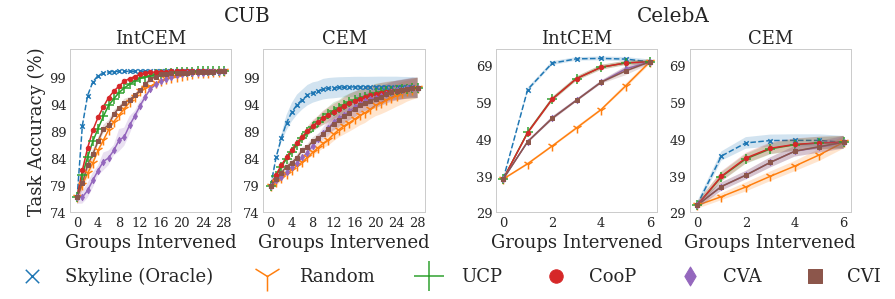

In [ ]:

import itertools
import matplotlib.gridspec as gridspec


clrs = sns.color_palette("tab10", 6)
color_map = {}
model_names = [
    'IntAwareConceptEmbeddingModel',
    'ConceptEmbeddingModel',
]
datasets_to_use = [
    # "MNIST-Add",
    # "MNIST-Add-Incomp",
    "CUB",
    # "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
policy_names = [
    ("Skyline (Oracle)", "optimal_greedy_no_prior"),
    # ("Learnt Policy", "group_random"),
    ("Random", "group_random_no_prior"),
    # ("Uncertainty of Concept Prediction (UCP)", "group_uncertainty_no_prior"),
    ("UCP", "group_uncertainty_no_prior"),
    ("CooP", "group_coop_no_prior"),
    # ("Behavioural Cloning", "behavioural_cloning_no_prior"),
    # ("Concept Validation Accuracy (CVA)", "global_val_error_no_prior"),
    ("CVA", "global_val_error_no_prior"),
    # ("Concept Validation Improvement (CVI)", "global_val_improvement_no_prior"),
    ("CVI", "global_val_improvement_no_prior"),
]

all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )

width = 3.5
height = 3
label_size = 18 + 2 - 2
title_size = 20 + 2 - 4
ds_title_size = 20 + 2 - 2
legend_size = 18
tick_size = 16 + 2 - 5
marker_size_large = 100
marker_size_small = 20
n_cols = 6
markerscale = 3
alpha = 0.2
fig = plt.figure(figsize=(len(datasets_to_use)*width*2, height))
# fig, axs = plt.subplots(
#     1,
#     len(datasets_to_use)*2,
#     figsize=(len(datasets_to_use)*width*2, height),
#     squeeze=False,
# )
gs = gridspec.GridSpec(1, len(datasets_to_use), figure=fig)


for dataset_idx, dataset_name in enumerate(datasets_to_use):
    curr_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[dataset_idx])
    over_ax = fig.add_subplot(curr_grid[:, :])
    over_ax.set_title(dataset_name+"\n", fontsize=ds_title_size)
    over_ax.xaxis.set_tick_params(labelbottom=False)
    over_ax.yaxis.set_tick_params(labelleft=False)
    over_ax.set_xticks([])
    over_ax.set_yticks([])
    over_ax.grid(False)
    over_ax.spines['top'].set_visible(False)
    over_ax.spines['right'].set_visible(False)
    over_ax.spines['bottom'].set_visible(False)
    over_ax.spines['left'].set_visible(False)

    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    model_names = [sorted_intcem_models[0][1]]
    # First find the bounds of the current dataset plots
    y_min = 100
    y_max = 0
    for method_idx, method_name in enumerate(model_names + ['ConceptEmbeddingModel']):
        for human_policy_name, policy_name in policy_names:
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
            y_max = max(y_max, np.max(means + stds))
            y_min = min(y_min, np.min(means - stds))
    print(y_min, y_max)
    y_max = int(np.floor(y_max * 1.02))
    y_min = int(np.floor(y_min * 0.98))
    print("For dataset", dataset_name, "we have y_min =", y_min, "and y_max =", y_max)
    # y_min = max(y_min - (y_min % 5), 0)
    # y_max = min(y_max + (5 - (y_max % 5)), 100)
    markers = itertools.cycle(('1', '+', 'o', 'd', 's' ,'v')) 
    # ax = axs[0, dataset_idx*len(datasets_to_use)]
    ax = fig.add_subplot(curr_grid[:, 0])

    for human_policy_name, policy_name in policy_names:
        for method_idx, method_name in enumerate(model_names):
            if method_name.startswith("IntAwareConceptEmbeddingModel"):
                method_to_actual_name[method_name] = "IntCEM"
            if (not method_name.startswith("IntAware")) and policy_name == "group_random":
                continue
            if method_name not in method_to_actual_name:
                continue
            print(method_name, policy_name)
            og_method_name = method_name
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            print("For dataset", dataset_name, "we selected method", og_method_name)
            print("\tWith policy", policy_name, "we got:")
            print("\t\tmeans:", means)
            print("\t\tstds:", stds)
            method_name = method_to_actual_name.get(method_name, method_name)
            if policy_name not in color_map:
                color_map[policy_name] = clrs[len(color_map)]
            line = "-"
            if human_policy_name == "Skyline (Oracle)":
                marker = "x"
                line = "--"
            else:
                marker = next(markers)
            color = color_map[policy_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                line,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=marker_size_large if marker in ["+", "*","1"] else marker_size_small,
                label=f'{human_policy_name}',
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=alpha,
                facecolor=color,
            )
        ax.xaxis.set_tick_params(labelsize=tick_size)
        ax.yaxis.set_tick_params(labelsize=tick_size)
        ax.set_ylim(y_min, y_max*1.02)
        ax.set_yticks(np.arange(y_min, y_max+1, 10 if len(x_vals) <= 7 else 5))
        ax.set_xticks(list(range(0, x_vals[-1] + 1, 2 if len(x_vals) <= 7 else 4)))
        ax.set_xlabel(f"Groups Intervened", fontsize=label_size)
        ax.set_title(f'{method_name}', fontsize=title_size)
        if dataset_idx == 0:
            ax.set_ylabel(f"Task Accuracy (%)", fontsize=label_size)
        ax.grid(False)
    model_names =  [
        'ConceptEmbeddingModel',
    ]
    markers = itertools.cycle(('1', '+', 'o', 'd', 's' ,'v')) 
    print("model_names =", model_names)
    # ax = axs[0, dataset_idx*len(datasets_to_use) + 1 ]
    ax = fig.add_subplot(curr_grid[:, 1])
    for human_policy_name, policy_name in policy_names:
        for method_idx, method_name in enumerate(model_names):
            if method_name.startswith("IntAwareConceptEmbeddingModel"):
                method_to_actual_name[method_name] = "IntCEM"
            if (not method_name.startswith("IntAware")) and policy_name == "group_random":
                continue
            if method_name not in method_to_actual_name:
                continue
            print(method_name, policy_name)
            og_method_name = method_name
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            print("For dataset", dataset_name, "we selected method", og_method_name)
            print("\tWith policy", policy_name, "we got:")
            print("\t\tmeans:", means)
            print("\t\tstds:", stds)
            method_name = method_to_actual_name.get(method_name, method_name)
            if policy_name not in color_map:
                color_map[policy_name] = clrs[len(color_map)]
            line = "-"
            if human_policy_name == "Skyline (Oracle)":
                marker = "x"
                line = "--"
            else:
                marker = next(markers)
            print("with", method_name,"and", policy_name, "marker is", marker)
            color = color_map[policy_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                line,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=marker_size_large if marker in ["+", "*","1"] else marker_size_small,
                label=f'{human_policy_name}',
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=alpha,
                facecolor=color,
            )
        ax.xaxis.set_tick_params(labelsize=tick_size)
        ax.yaxis.set_tick_params(labelsize=tick_size)
        ax.set_ylim(y_min, y_max*1.02)
        ax.set_yticks(np.arange(y_min, y_max+1, 10 if len(x_vals) <= 7 else 5))
        ax.set_xticks(list(range(0, x_vals[-1] + 1, 2 if len(x_vals) <= 7 else 4)))
        ax.set_xlabel(f"Groups Intervened", fontsize=label_size)
        ax.set_title(f'{method_name}', fontsize=title_size)
        ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=legend_size,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.05),
    ncol=n_cols,
    markerscale=markerscale,
)
plt.savefig("figures/all_policies_with_cem.pdf", bbox_inches='tight')
plt.savefig("figures/all_policies_with_cem.png", bbox_inches='tight')
# plt.tight_layout()
plt.show()

In [47]:

model_names = [
    'IntAwareConceptEmbeddingModel',
    'ConceptEmbeddingModel',
]
method_to_actual_name = {
    'ConceptEmbeddingModel': 'CEM',
    'ConceptBottleneckModelLogit': "Joint CBM-Logit",
    'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
    'SequentialConceptBottleneckModel': "Sequential CBM",
    'IndependentConceptBottleneckModel': "Independent CBM",
}
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
policy_names = [
    # ("Learnt Policy", "group_random"),
    # ("Random", "group_random_no_prior"),
    # ("Uncertainty of Concept Prediction (UCP)", "group_uncertainty_no_prior"),
    ("UCP", "group_uncertainty_no_prior"),
    ("CooP", "group_coop_no_prior"),
    # ("Behavioural Cloning", "behavioural_cloning_no_prior"),
    # ("Concept Validation Accuracy (CVA)", "global_val_error_no_prior"),
    ("CVA", "global_val_error_no_prior"),
    # ("Concept Validation Improvement (CVI)", "global_val_improvement_no_prior"),
    ("CVI", "global_val_improvement_no_prior"),
    ("Skyline", "optimal_greedy_no_prior"),
]

all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )

n_cols = len(policy_names) * len(model_names)
table_str = r'\begin{tabular}{p{4pt}c|' + "|".join(["c" * len(model_names) for _ in policy_names]) + '}\n'
table_str += "{} & {Dataset} &\n"
for human_policy_name, _ in policy_names:
    for method_name in model_names:
        if method_name.startswith("IntAwareConceptEmbeddingModel"):
            method_to_actual_name[method_name] = "IntCEM"
        if method_name not in method_to_actual_name:
            continue
        method_name = method_to_actual_name[method_name]
        table_str += f"\t{method_name} ({human_policy_name}) &\n"
table_str = table_str[:-2] + r" \\ \toprule"+ "\n"
for percent in [0.25, 0.5, 0.75, 1]:
    done = False
    for dataset_idx, dataset_name in enumerate(datasets_to_use):
        dataset_results = all_filtered_results[dataset_name]
        method_to_actual_name = {
            'ConceptEmbeddingModel': 'CEM',
            'ConceptBottleneckModelLogit': "Joint CBM-Logit",
            'ConceptBottleneckModelLogit_long': "Joint CBM-Logit",
            'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
            'ConceptBottleneckModelSigmoid_long': "Joint CBM-Sigmoid",
            "ConceptBottleneckModelSigmoid_concept_loss_weight_1": "Joint CBM-Sigmoid",
            'SequentialConceptBottleneckModel': "Sequential CBM",
            'SequentialConceptBottleneckModel_long': "Sequential CBM",
            'IndependentConceptBottleneckModel': "Independent CBM",
            'IndependentConceptBottleneckModel_long': "Independent CBM",
        }
        intcem_models = [
            name for name in dataset_results['test_acc_y'].keys()
            if name.startswith("IntAware")
        ]
        sorted_intcem_models = []
        for method_idx, method_name in enumerate(intcem_models):
            human_policy_name, policy_name = ("Random", "group_random")
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
            area = means[0] * np.trapz(means)
            sorted_intcem_models.append((area, method_name))
            method_name = method_to_actual_name.get(method_name, method_name)
        sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
        used_model_names = [
            sorted_intcem_models[0][1]
            if method_name.startswith("IntAwareConceptEmbeddingModel")
            else method_name
            for method_name in model_names
        ]
        print(used_model_names)
        print(method_to_actual_name)
        if not done:
            table_str += "\t{\parbox[t]{10mm}{\multirow{" + str(len(datasets_to_use)) + "}{*}{\\rotatebox{90}{\\text{" + f"{int(percent*100)}\%" + "}}}}} & \\texttt{" + dataset_name + "} &\n"
            done = True
        else:
            table_str += "{} & \\texttt{" + dataset_name + "} &\n"
        for human_policy_name, policy_name in policy_names:
            for method_idx, method_name in enumerate(used_model_names):
                og_method_name = method_name
                if og_method_name.startswith("IntAwareConceptEmbeddingModel"):
                    method_to_actual_name[og_method_name] = "IntCEM"
                if og_method_name not in method_to_actual_name:
                    print("HERE WITH", og_method_name)
                    continue
                means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
                method_name = method_to_actual_name.get(og_method_name, og_method_name)
                idx = int(np.floor((len(means) - 1) * percent))
                table_str += f"    {means[idx]:.2f} ± {stds[idx]:.2f} &\n"
                print(og_method_name, human_policy_name, dataset_name, percent)
        table_str = table_str [:-2] + " \\\\\n"
    table_str = table_str [:-2] + " \\\\ \hline\n"
print(table_str)

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

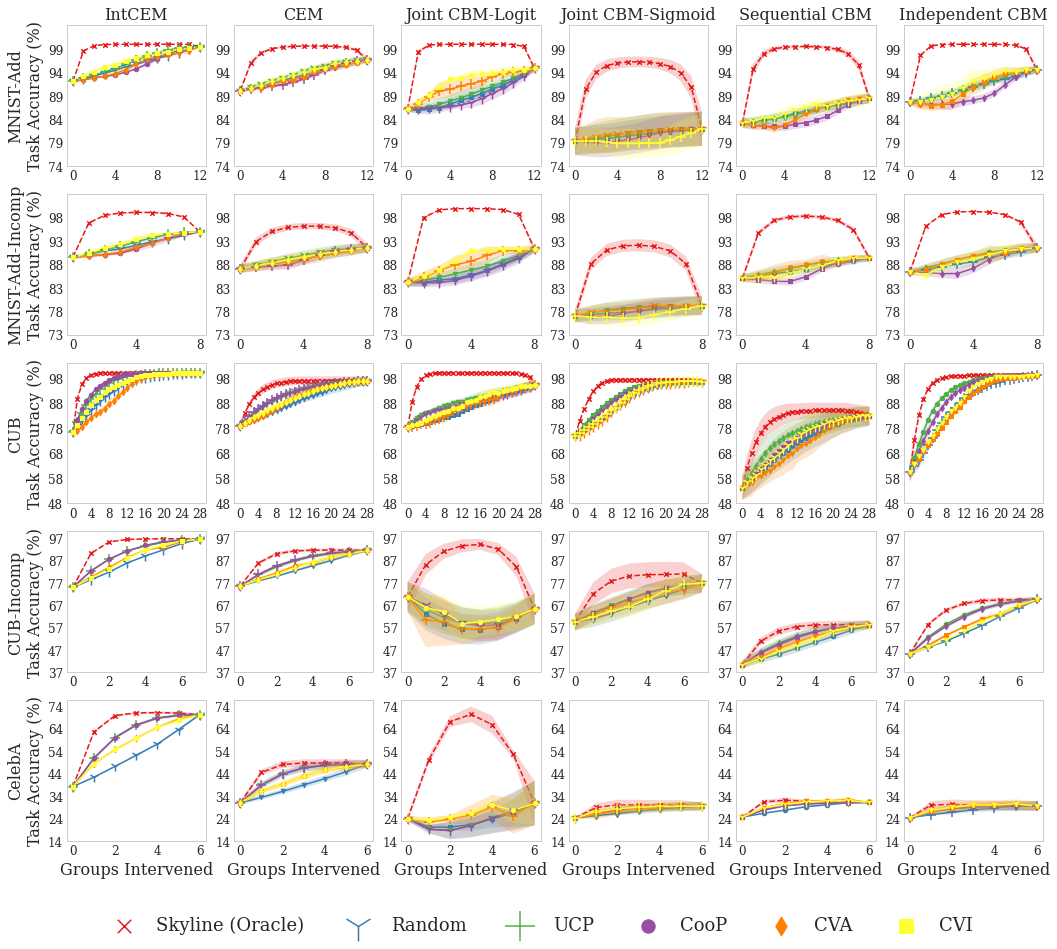

In [27]:

import itertools
import matplotlib.gridspec as gridspec


clrs = sns.color_palette("Set1", 6)
color_map = {}
model_names = [
    'ConceptEmbeddingModel',
    'ConceptBottleneckModelLogit',
    'ConceptBottleneckModelSigmoid',
    'IndependentConceptBottleneckModel',
    'SequentialConceptBottleneckModel',
]
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
policy_names = [
    ("Skyline (Oracle)", "optimal_greedy_no_prior"),
    # ("Learnt Policy", "group_random"),
    ("Random", "group_random_no_prior"),
    # ("Uncertainty of Concept Prediction (UCP)", "group_uncertainty_no_prior"),
    ("UCP", "group_uncertainty_no_prior"),
    ("CooP", "group_coop_no_prior"),
    # ("Behavioural Cloning", "behavioural_cloning_no_prior"),
    # ("Concept Validation Accuracy (CVA)", "global_val_error_no_prior"),
    ("CVA", "global_val_error_no_prior"),
    # ("Concept Validation Improvement (CVI)", "global_val_improvement_no_prior"),
    ("CVI", "global_val_improvement_no_prior"),
]

all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )

width = 3.5
height = 3
label_size = 16
title_size = 16
ds_title_size = 16
legend_size = 18
tick_size = 12
marker_size_large = 100
marker_size_small = 20
n_cols = 6
markerscale = 3
alpha = 0.2
fig, axs = plt.subplots(
    len(datasets_to_use),
    len(model_names) + 1,
    figsize=(len(datasets_to_use)*width, height*len(model_names)),
    squeeze=False,
)


for dataset_idx, dataset_name in enumerate(datasets_to_use):
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelLogit_long': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'ConceptBottleneckModelSigmoid_long': "Joint CBM-Sigmoid",
        'ConceptBottleneckModelSigmoid_concept_loss_weight_1': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'SequentialConceptBottleneckModel_long': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
        'IndependentConceptBottleneckModel_long': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    used_method_names = [sorted_intcem_models[0][1]] + model_names
    if "MNIST" in dataset_name:
        used_method_names = [sorted_intcem_models[0][1]] + [
            'ConceptEmbeddingModel',
            'ConceptBottleneckModelLogit_long',
            'ConceptBottleneckModelSigmoid_long',
            'SequentialConceptBottleneckModel_long',
            'IndependentConceptBottleneckModel_long',
        ]
    else:
        used_method_names = [sorted_intcem_models[0][1]] + [
            'ConceptEmbeddingModel',
            'ConceptBottleneckModelLogit',
            'ConceptBottleneckModelSigmoid'+ ("_concept_loss_weight_1" if dataset_name == "CUB-Incomp" else ""),
            'SequentialConceptBottleneckModel',
            'IndependentConceptBottleneckModel',
        ]
    # First find the bounds of the current dataset plots
    y_min = 100
    y_max = 0
    for method_idx, method_name in enumerate(used_method_names):
        for human_policy_name, policy_name in policy_names:
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
            y_max = max(y_max, np.max(means + stds))
            y_min = min(y_min, np.min(means - stds))
    print(y_min, y_max)
    y_max = int(np.floor(y_max * 1.02))
    y_min = int(np.floor(y_min * 0.98))
    print("For dataset", dataset_name, "we have y_min =", y_min, "and y_max =", y_max)
    # y_min = max(y_min - (y_min % 5), 0)
    # y_max = min(y_max + (5 - (y_max % 5)), 100)
    markers = itertools.cycle(('1', '+', 'o', 'd', 's' ,'v')) 
    for method_idx, method_name in enumerate(used_method_names):
        ax = axs[dataset_idx, method_idx]
        og_method_name = method_name
        for human_policy_name, policy_name in policy_names:
            if og_method_name.startswith("IntAwareConceptEmbeddingModel"):
                method_to_actual_name[og_method_name] = "IntCEM"
            if og_method_name not in method_to_actual_name:
                continue
            print(og_method_name, policy_name)
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            print("For dataset", dataset_name, "we selected method", og_method_name)
            print("\tWith policy", policy_name, "we got:")
            print("\t\tmeans:", means)
            print("\t\tstds:", stds)
            method_name = method_to_actual_name.get(og_method_name, og_method_name)
            if policy_name not in color_map:
                color_map[policy_name] = clrs[len(color_map)]
            line = "-"
            if human_policy_name == "Skyline (Oracle)":
                marker = "x"
                line = "--"
            else:
                marker = next(markers)
            color = color_map[policy_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                line,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=marker_size_large if marker in ["+", "*","1"] else marker_size_small,
                label=f'{human_policy_name}',
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=alpha,
                facecolor=color,
            )
            ax.xaxis.set_tick_params(labelsize=tick_size)
            ax.yaxis.set_tick_params(labelsize=tick_size)
            ax.set_ylim(y_min, y_max*1.02)
            ax.set_yticks(np.arange(y_min, y_max+1, 10 if (y_max - y_min) >= 35 else 5))
            ax.set_xticks(list(range(0, x_vals[-1] + 1, 2 if len(x_vals) <= 8 else 4)))
            if dataset_idx == len(datasets_to_use) - 1:
                ax.set_xlabel(f"Groups Intervened", fontsize=label_size)
            if dataset_idx == 0:
                ax.set_title(f'{method_name}', fontsize=title_size)
            if method_idx == 0:
                ax.set_ylabel(f"{dataset_name}\nTask Accuracy (%)", fontsize=label_size)
            ax.grid(False)
        if og_method_name.startswith("IntAwareConceptEmbeddingModel"):
            handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=legend_size,
    loc='upper center',
    bbox_to_anchor=(0.5,0.07),
    ncol=n_cols,
    markerscale=markerscale,
)
plt.savefig("figures/all_policies_all_tasks.pdf", bbox_inches='tight')
plt.savefig("figures/all_policies_all_tasks.png", bbox_inches='tight')
# plt.tight_layout()
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

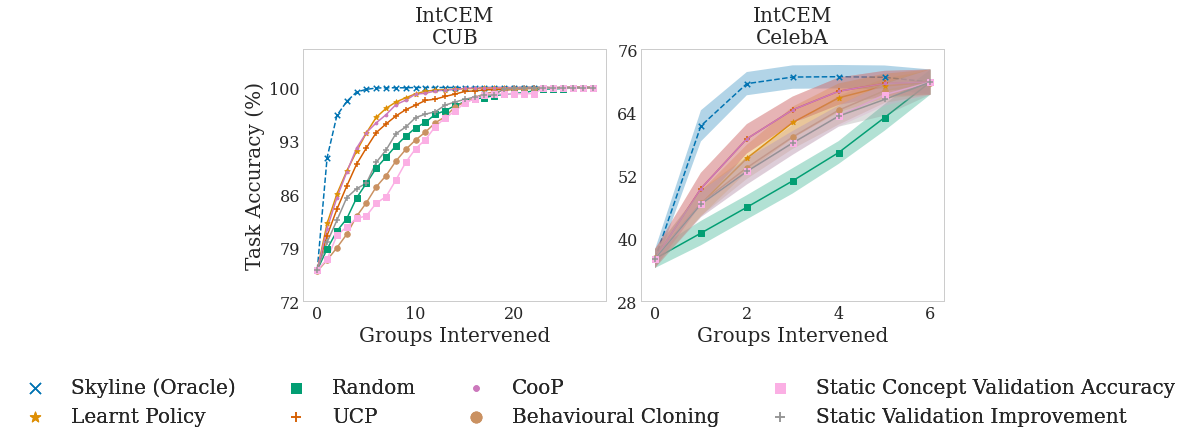

In [ ]:

import itertools

clrs = sns.color_palette("colorblind", 8)
color_map = {}
model_names = [
    'IntAwareConceptEmbeddingModel',
    'ConceptEmbeddingModel',
]
datasets_to_use = [
    # "MNIST-Add",
    # "MNIST-Add-Incomp",
    "CUB",
    # "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
policy_names = [
    ("Skyline (Oracle)", "optimal_greedy_no_prior"),
    ("Learnt Policy", "group_random"),
    ("Random", "group_random_no_prior"),
    ("UCP", "group_uncertainty_no_prior"),
    ("CooP", "group_coop_no_prior"),
    ("Behavioural Cloning", "behavioural_cloning_no_prior"),
    ("Static Concept Validation Accuracy", "global_val_error_no_prior"),
    ("Static Validation Improvement", "global_val_improvement_no_prior"),
]

all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.1) == 1.1) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )
    
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*5, 5),
    squeeze=False,
)
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    model_names = [sorted_intcem_models[0][1]]
    # First find the bounds of the current dataset plots
    y_min = 100
    y_max = 0
    for method_idx, method_name in enumerate(model_names + ['ConceptEmbeddingModel']):
        for human_policy_name, policy_name in policy_names:
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
            y_max = max(y_max, np.max(means + stds))
            y_min = min(y_min, np.min(means - stds))
    print(y_min, y_max)
    y_max = int(np.floor(y_max * 1.05))
    y_min = int(np.floor(y_min * 0.95))
    print("model_names =", model_names)
    markers = itertools.cycle((',', '+', '.', 'o')) 
    for human_policy_name, policy_name in policy_names:
        for method_idx, method_name in enumerate(model_names):
            if method_name.startswith("IntAwareConceptEmbeddingModel"):
                method_to_actual_name[method_name] = "IntCEM"
            if (not method_name.startswith("IntAware")) and policy_name == "group_random":
                continue
            ax = axs[0, dataset_idx]
            if method_name not in method_to_actual_name:
                continue
            print(method_name, policy_name)
            og_method_name = method_name
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            method_name = method_to_actual_name.get(method_name, method_name)
            if policy_name not in color_map:
                color_map[policy_name] = clrs[len(color_map)]
            line = "-"
            if human_policy_name == "Learnt Policy":
                marker = "*"
            elif human_policy_name == "Skyline (Oracle)":
                marker = "x"
                line = "--"
            else:
                marker = next(markers)
            color = color_map[policy_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                line,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=30,
                label=f'{human_policy_name}',
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=0.3,
                facecolor=color,
            )
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(np.linspace(max(y_min, 0), min(y_max, 100), 5))
        ax.set_xlabel(f"Groups Intervened", fontsize=20)
        ax.set_title(f'{method_name}\n{dataset_name}', fontsize=20)
        if dataset_idx == 0:
            ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
        ax.grid(False)
    handles, labels = axs[0,0].get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        fontsize=20,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=4,
        markerscale=2,
    )
plt.savefig("figures/all_policies_just_intcem.pdf", bbox_inches='tight')
plt.savefig("figures/all_policies_just_intcem.png", bbox_inches='tight')
plt.tight_layout()
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

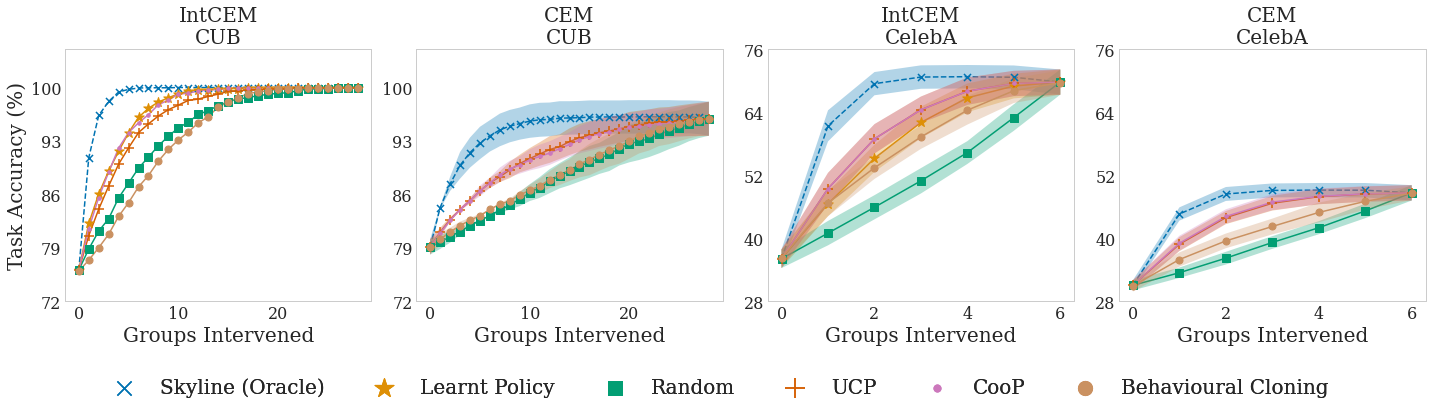

In [ ]:

import itertools

clrs = sns.color_palette("colorblind", 8)
color_map = {}
model_names = [
    'IntAwareConceptEmbeddingModel',
    'ConceptEmbeddingModel',
]
datasets_to_use = [
    # "MNIST-Add",
    # "MNIST-Add-Incomp",
    "CUB",
    # "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
policy_names = [
    ("Skyline (Oracle)", "optimal_greedy_no_prior"),
    ("Learnt Policy", "group_random"),
    ("Random", "group_random_no_prior"),
    ("UCP", "group_uncertainty_no_prior"),
    ("CooP", "group_coop_no_prior"),
    ("Behavioural Cloning", "behavioural_cloning_no_prior"),
    # ("Static Concept Validation Accuracy", "global_val_error_no_prior"),
    # ("Static Validation Improvement", "global_val_improvement_no_prior"),
]

all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.1) == 1.1) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )
    
fig, axs = plt.subplots(
    1,
    len(datasets_to_use)*2,
    figsize=(len(datasets_to_use)*5*2, 5),
    squeeze=False,
)
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    model_names = [sorted_intcem_models[0][1]]
    # First find the bounds of the current dataset plots
    y_min = 100
    y_max = 0
    for method_idx, method_name in enumerate(model_names + ['ConceptEmbeddingModel']):
        for human_policy_name, policy_name in policy_names:
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
            y_max = max(y_max, np.max(means + stds))
            y_min = min(y_min, np.min(means - stds))
    print(y_min, y_max)
    y_max = int(np.floor(y_max * 1.05))
    y_min = int(np.floor(y_min * 0.95))
    print("model_names =", model_names)
    markers = itertools.cycle((',', '+', '.', 'o')) 
    for human_policy_name, policy_name in policy_names:
        for method_idx, method_name in enumerate(model_names):
            if method_name.startswith("IntAwareConceptEmbeddingModel"):
                method_to_actual_name[method_name] = "IntCEM"
            if (not method_name.startswith("IntAware")) and policy_name == "group_random":
                continue
            ax = axs[0, dataset_idx*len(datasets_to_use)]
            if method_name not in method_to_actual_name:
                continue
            print(method_name, policy_name)
            og_method_name = method_name
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            method_name = method_to_actual_name.get(method_name, method_name)
            if policy_name not in color_map:
                color_map[policy_name] = clrs[len(color_map)]
            line = "-"
            if human_policy_name == "Learnt Policy":
                marker = "*"
            elif human_policy_name == "Skyline (Oracle)":
                marker = "x"
                line = "--"
            else:
                marker = next(markers)
            color = color_map[policy_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                line,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=100 if marker in ["+", "*"] else 50,
                label=f'{human_policy_name}',
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=0.3,
                facecolor=color,
            )
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(np.linspace(max(y_min, 0), min(y_max, 100), 5))
        ax.set_xlabel(f"Groups Intervened", fontsize=20)
        ax.set_title(f'{method_name}\n{dataset_name}', fontsize=20)
        if dataset_idx == 0:
            ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
        ax.grid(False)
    
    model_names =  [
        'ConceptEmbeddingModel',
    ]
    print("model_names =", model_names)
    markers = itertools.cycle((',', '+', '.', 'o')) 
    for human_policy_name, policy_name in policy_names:
        for method_idx, method_name in enumerate(model_names):
            if method_name.startswith("IntAwareConceptEmbeddingModel"):
                method_to_actual_name[method_name] = "IntCEM"
            if (not method_name.startswith("IntAware")) and policy_name == "group_random":
                continue
            ax = axs[0, dataset_idx*len(datasets_to_use) + 1 ]
            if method_name not in method_to_actual_name:
                continue
            print(method_name, policy_name)
            og_method_name = method_name
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            method_name = method_to_actual_name.get(method_name, method_name)
            if policy_name not in color_map:
                color_map[policy_name] = clrs[len(color_map)]
            line = "-"
            if human_policy_name == "Learnt Policy":
                marker = "*"
            elif human_policy_name == "Skyline (Oracle)":
                marker = "x"
                line = "--"
            else:
                marker = next(markers)
            color = color_map[policy_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                line,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=100 if marker in ["+", "*"] else 50,
                label=f'{human_policy_name}',
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=0.3,
                facecolor=color,
            )
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(np.linspace(max(y_min, 0), min(y_max, 100), 5))
        ax.set_xlabel(f"Groups Intervened", fontsize=20)
        ax.set_title(f'{method_name}\n{dataset_name}', fontsize=20)
        ax.grid(False)
    handles, labels = axs[0,0].get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        fontsize=20,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=6,
        markerscale=2,
    )
plt.savefig("figures/dynamic_policies_with_cem.pdf", bbox_inches='tight')
plt.savefig("figures/dynamic_policies_with_cem.png", bbox_inches='tight')
plt.tight_layout()
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

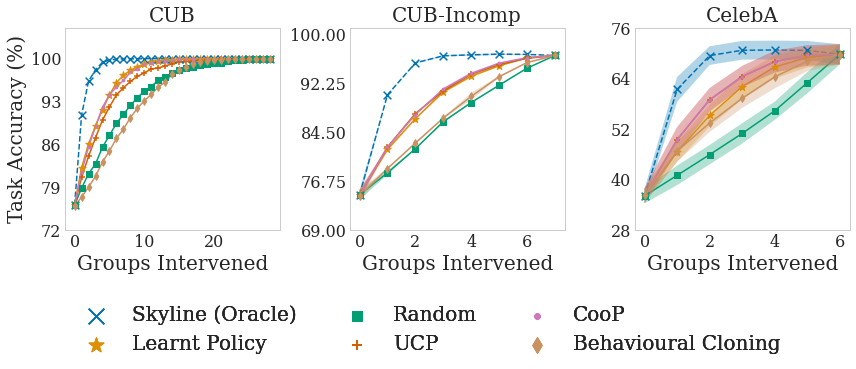

In [ ]:

import itertools

clrs = sns.color_palette("colorblind", 8)
color_map = {}
model_names = [
    'IntAwareConceptEmbeddingModel',
    'ConceptEmbeddingModel',
]
datasets_to_use = [
    # "MNIST-Add",
    # "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
policy_names = [
    ("Skyline (Oracle)", "optimal_greedy_no_prior"),
    ("Learnt Policy", "group_random"),
    ("Random", "group_random_no_prior"),
    ("UCP", "group_uncertainty_no_prior"),
    ("CooP", "group_coop_no_prior"),
    ("Behavioural Cloning", "behavioural_cloning_no_prior"),
    # ("Static Concept Validation Accuracy", "global_val_error_no_prior"),
    # ("Static Validation Improvement", "global_val_improvement_no_prior"),
]

all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.1) == 1.1) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )
    
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*4, 4),
    squeeze=False,
)
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    model_names = [sorted_intcem_models[0][1]]
    # First find the bounds of the current dataset plots
    y_min = 100
    y_max = 0
    for method_idx, method_name in enumerate(model_names + ['ConceptEmbeddingModel']):
        for human_policy_name, policy_name in policy_names:
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
            y_max = max(y_max, np.max(means + stds))
            y_min = min(y_min, np.min(means - stds))
    print(y_min, y_max)
    y_max = int(np.floor(y_max * 1.05))
    y_min = int(np.floor(y_min * 0.95))
    print("model_names =", model_names)
    markers = itertools.cycle((',', '+', '.', 'd')) 
    for human_policy_name, policy_name in policy_names:
        for method_idx, method_name in enumerate(model_names):
            if method_name.startswith("IntAwareConceptEmbeddingModel"):
                method_to_actual_name[method_name] = "IntCEM"
            if (not method_name.startswith("IntAware")) and policy_name == "group_random":
                continue
            ax = axs[0, dataset_idx]
            if method_name not in method_to_actual_name:
                continue
            print(method_name, policy_name)
            og_method_name = method_name
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            method_name = method_to_actual_name.get(method_name, method_name)
            if policy_name not in color_map:
                color_map[policy_name] = clrs[len(color_map)]
            line = "-"
            if human_policy_name == "Learnt Policy":
                marker = "*"
            elif human_policy_name == "Skyline (Oracle)":
                marker = "x"
                line = "--"
            else:
                marker = next(markers)
            color = color_map[policy_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                line,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=60 if marker in ["*", "x"] else 30,
                label=f'{human_policy_name}',
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=0.3,
                facecolor=color,
            )
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(np.linspace(max(y_min, 0), min(y_max, 100), 5))
        ax.set_xlabel(f"Groups Intervened", fontsize=20)
        ax.set_title(f'{dataset_name}', fontsize=20)
        if dataset_idx == 0:
            ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
        ax.grid(False)
    handles, labels = axs[0,0].get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        fontsize=20,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=3,
        markerscale=2,
    )
plt.savefig("figures/dynamic_policies_just_intcem.pdf", bbox_inches='tight')
plt.savefig("figures/dynamic_policies_just_intcem.png", bbox_inches='tight')
plt.tight_layout()
plt.show()

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

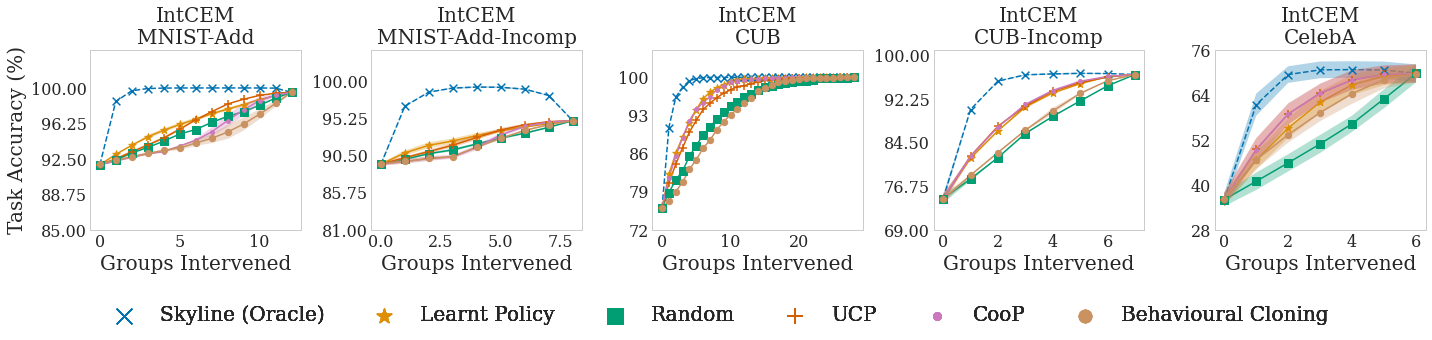

In [ ]:

import itertools

clrs = sns.color_palette("colorblind", 8)
color_map = {}
model_names = [
    'IntAwareConceptEmbeddingModel',
    'ConceptEmbeddingModel',
]
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
policy_names = [
    ("Skyline (Oracle)", "optimal_greedy_no_prior"),
    ("Learnt Policy", "group_random"),
    ("Random", "group_random_no_prior"),
    ("UCP", "group_uncertainty_no_prior"),
    ("CooP", "group_coop_no_prior"),
    ("Behavioural Cloning", "behavioural_cloning_no_prior"),
    # ("Static Concept Validation Accuracy", "global_val_error_no_prior"),
    # ("Static Validation Improvement", "global_val_improvement_no_prior"),
]

all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.1) == 1.1) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )
    
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*4, 4),
    squeeze=False,
)
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    
    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    model_names = [sorted_intcem_models[0][1]]
    # First find the bounds of the current dataset plots
    y_min = 100
    y_max = 0
    for method_idx, method_name in enumerate(model_names + ['ConceptEmbeddingModel']):
        for human_policy_name, policy_name in policy_names:
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
            y_max = max(y_max, np.max(means + stds))
            y_min = min(y_min, np.min(means - stds))
    print(y_min, y_max)
    y_max = int(np.floor(y_max * 1.05))
    y_min = int(np.floor(y_min * 0.95))
    print("model_names =", model_names)
    markers = itertools.cycle((',', '+', '.', 'o')) 
    for human_policy_name, policy_name in policy_names:
        for method_idx, method_name in enumerate(model_names):
            if method_name.startswith("IntAwareConceptEmbeddingModel"):
                method_to_actual_name[method_name] = "IntCEM"
            if (not method_name.startswith("IntAware")) and policy_name == "group_random":
                continue
            ax = axs[0, dataset_idx]
            if method_name not in method_to_actual_name:
                continue
            print(method_name, policy_name)
            og_method_name = method_name
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
            method_name = method_to_actual_name.get(method_name, method_name)
            if policy_name not in color_map:
                color_map[policy_name] = clrs[len(color_map)]
            line = "-"
            if human_policy_name == "Learnt Policy":
                marker = "*"
            elif human_policy_name == "Skyline (Oracle)":
                marker = "x"
                line = "--"
            else:
                marker = next(markers)
            color = color_map[policy_name]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                line,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=60 if marker != "o" else 40,
                label=f'{human_policy_name}',
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=0.3,
                facecolor=color,
            )
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.set_ylim(y_min, y_max)
        ax.set_yticks(np.linspace(max(y_min, 0), min(y_max, 100), 5))
        ax.set_xlabel(f"Groups Intervened", fontsize=20)
        ax.set_title(f'{method_name}\n{dataset_name}', fontsize=20)
        if dataset_idx == 0:
            ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
        ax.grid(False)
    handles, labels = axs[0,0].get_legend_handles_labels()
    lgd = fig.legend(
        handles,
        labels,
        fontsize=20,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=6,
        markerscale=2,
    )
plt.savefig("figures/dynamic_policies_just_intcem_all_datasets.pdf", bbox_inches='tight')
plt.savefig("figures/dynamic_policies_just_intcem_all_datasets.png", bbox_inches='tight')
plt.tight_layout()
plt.show()

LastOnly_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_tau_1_max_horizon_28_task_discount_1.1_uniform_distr_True
LastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_28_task_discount_1.05_uniform_distr_True_no_horizon
LastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_28_task_discount_1.05_uniform_distr_True_no_horizon
LastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_28_task_discount_1.05_uniform_distr_True_no_horizon


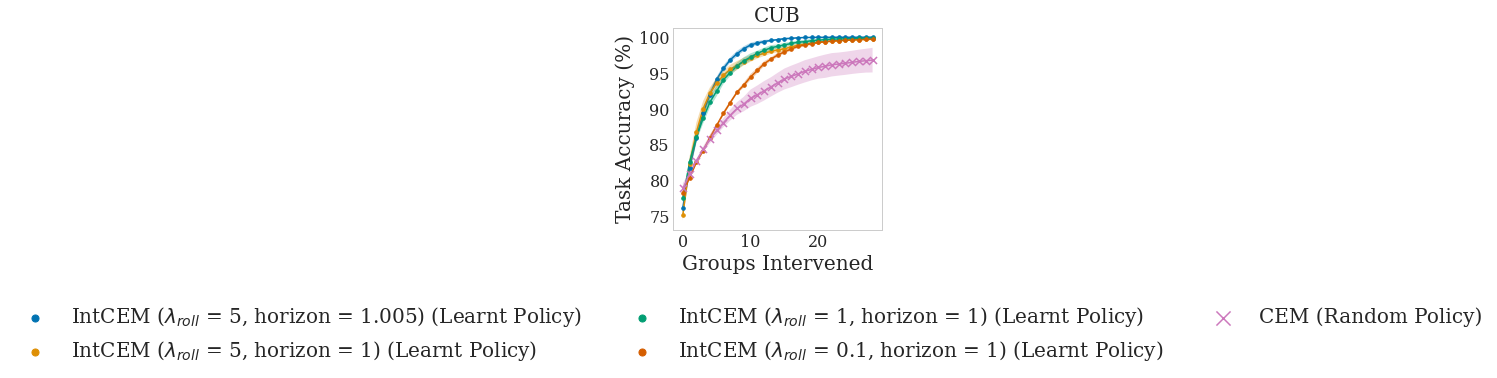

In [ ]:

clrs = sns.color_palette("colorblind", 30)
color_map = {}

datasets_to_use = [
    # "MNIST-ADD",
    # "MNIST-ADD-INCOMP",
    "CUB",
    # "CUB-INCOMP",
    # "CheXpert",
    # "CelebA",
    # "Derm7-p",
]
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*4, 4),
    squeeze=False,
)
for dataset_idx, dataset_name in enumerate(datasets_to_use):
    dataset_results = all_processed_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    model_names = []
    for key, vals in dataset_results['test_acc_y'].items():
        if key.startswith('IntAwareConceptEmbeddingModel'):
            model_names.append(key)
    for method_idx, method_name in enumerate(model_names):
        ax = axs[0, dataset_idx]
        marker = model_name_to_marker.get(method_name,'.')
        human_policy_name, policy_name = "Learnt", "group_random"
        if method_name not in model_configs[dataset_name]:
            c
        config = model_configs[dataset_name][method_name]
        print(config['extra_name'])
        method_to_actual_name[method_name] = "IntCEM ($\\lambda_{roll}$ =" + f" {config['intervention_weight']}, horizon = {config['horizon_rate']})"
        if method_name not in method_to_actual_name:
            continue
        og_method_name = method_name
        means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
        method_name = method_to_actual_name.get(method_name, method_name)
        if (method_name, policy_name) not in color_map:
            color_map[(method_name, policy_name)] = clrs[len(color_map)]
        color = color_map[(method_name, policy_name)]
        x_vals = list(range(0, len(means), 1))
        ax.plot(
            x_vals,
            means,
            c=color,
            zorder=1,
        )
        ax.scatter(
            x_vals,
            means,
            s=50,
            label=f'{method_name} ({human_policy_name} Policy)',
            color=color,
            zorder=2,
            marker=marker,
        )
        ax.fill_between(
            x_vals,
            means - stds,
            means + stds,
            alpha=0.3,
            facecolor=color,
        )

    og_method_name = method_name = "ConceptEmbeddingModel"
    human_policy_name, policy_name = "Random", "group_coop_no_prior"
    means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name)
    method_name = method_to_actual_name.get(method_name, method_name)
    if method_name not in color_map:
        color_map[method_name] = clrs[len(color_map)]
    color = color_map[method_name]
    x_vals = list(range(0, len(means), 1))
    ax.plot(
        x_vals,
        means,
        c=color,
        zorder=1,
    )
    ax.scatter(
        x_vals,
        means,
        s=50,
        label=f'{method_name} ({human_policy_name} Policy)',
        color=color,
        zorder=2,
        marker="x",
    )
    ax.fill_between(
        x_vals,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=color,
    )
    handles, labels = ax.get_legend_handles_labels()

    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.set_xlabel(f"Groups Intervened", fontsize=20)
    ax.set_title(dataset_name, fontsize=20)
    if dataset_idx == 0:
        ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
    ax.grid(False)
    lgd = fig.legend(
        handles,
        labels,
        fontsize=20,
        loc='upper center',
        bbox_to_anchor=(0.5,-0.01),
        ncol=3,
        markerscale=2,
    )
plt.tight_layout()
plt.show()

# Adversarial Interventions

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

<Figure size 1512x216 with 0 Axes>

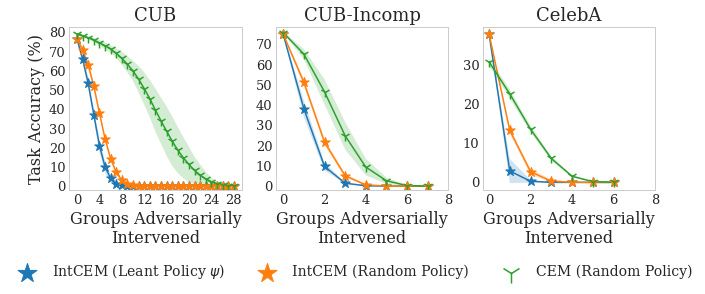

In [20]:

import itertools
import matplotlib.gridspec as gridspec


clrs = sns.color_palette("tab10", 6)
color_map = {}
model_names = [
    'IntAwareConceptEmbeddingModel',
    'ConceptEmbeddingModel',
]
datasets_to_use = [
    # "MNIST-Add",
    # "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    # "CheXpert",
    "CelebA",
    # "Derm7-p",
]
policy_names = [
    # ("Skyline (Oracle)", "optimal_greedy_no_prior"),
    ("Learnt", "group_random"),
    ("Random", "group_random_no_prior"),
    # ("Uncertainty of Concept Prediction (UCP)", "group_uncertainty_no_prior"),
    # ("UCP", "group_uncertainty_no_prior"),
    # ("CooP", "group_coop_no_prior"),
    # ("Behavioural Cloning", "behavioural_cloning_no_prior"),
    # ("Concept Validation Accuracy (CVA)", "global_val_error_no_prior"),
    # ("CVA", "global_val_error_no_prior"),
    # ("Concept Validation Improvement (CVI)", "global_val_improvement_no_prior"),
    # ("CVI", "global_val_improvement_no_prior"),
]

all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )

width = 3.5
height = 3
label_size = 16
title_size = 20 + 2 - 4
ds_title_size = 20 + 2 - 2
legend_size = 14
tick_size = 16 + 2 - 5
marker_size_large = 100
marker_size_small = 20
n_cols = 6
markerscale = 2
alpha = 0.2
fig = plt.figure(figsize=(len(datasets_to_use)*width*2, height))
fig, axs = plt.subplots(
    1,
    len(datasets_to_use),
    figsize=(len(datasets_to_use)*width, height),
    squeeze=False,
)


for dataset_idx, dataset_name in enumerate(datasets_to_use):
    # curr_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[dataset_idx])
    # over_ax = fig.add_subplot(curr_grid[:, :])
    # over_ax.set_title(dataset_name+"\n", fontsize=ds_title_size)
    # over_ax.xaxis.set_tick_params(labelbottom=False)
    # over_ax.yaxis.set_tick_params(labelleft=False)
    # over_ax.set_xticks([])
    # over_ax.set_yticks([])
    # over_ax.grid(False)
    # over_ax.spines['top'].set_visible(False)
    # over_ax.spines['right'].set_visible(False)
    # over_ax.spines['bottom'].set_visible(False)
    # over_ax.spines['left'].set_visible(False)

    dataset_results = all_filtered_results[dataset_name]
    method_to_actual_name = {
        'ConceptEmbeddingModel': 'CEM',
        'ConceptBottleneckModelLogit': "Joint CBM-Logit",
        'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
        'SequentialConceptBottleneckModel': "Sequential CBM",
        'IndependentConceptBottleneckModel': "Independent CBM",
    }
    intcem_models = [
        name for name in dataset_results['test_acc_y'].keys()
        if name.startswith("IntAware")
    ]
    sorted_intcem_models = []
    for method_idx, method_name in enumerate(intcem_models):
        config = model_configs[dataset_name][method_name]
        human_policy_name, policy_name = "Learnt", "group_random"
        means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
        area = np.trapz(means)
        sorted_intcem_models.append((area, method_name))
        method_name = method_to_actual_name.get(method_name, method_name)
    sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
    model_names = [sorted_intcem_models[0][1]] + ['ConceptEmbeddingModel']
    # First find the bounds of the current dataset plots
    y_min = 100
    y_max = 0
    for method_idx, method_name in enumerate(model_names):
        for human_policy_name, policy_name in policy_names:
            means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name, competence_level=0)
            y_max = max(y_max, np.max(means + stds))
            y_min = min(y_min, np.min(means - stds))
    print(y_min, y_max)
    y_max = min(int(np.floor(y_max * 1.02)), 100)
    y_min = max(int(np.floor(y_min * 0.98)), 0)
    print("For dataset", dataset_name, "we have y_min =", y_min, "and y_max =", y_max)
    # y_min = max(y_min - (y_min % 5), 0)
    # y_max = min(y_max + (5 - (y_max % 5)), 100)
    markers = itertools.cycle(('1', '+', 'o', 'd', 's' ,'v')) 
    ax = axs[0, dataset_idx]

    for human_policy_name, policy_name in policy_names:
        for method_idx, method_name in enumerate(model_names):
            if method_name.startswith("IntAwareConceptEmbeddingModel"):
                method_to_actual_name[method_name] = "IntCEM"
            if (not method_name.startswith("IntAware")) and policy_name == "group_random":
                continue
            if method_name not in method_to_actual_name:
                continue
            print(method_name, policy_name)
            og_method_name = method_name
            means, stds = get_intervention_accuracies(dataset_results, og_method_name, policy_name=policy_name, competence_level=0)
            print("For dataset", dataset_name, "we selected method", og_method_name)
            print("\tWith policy", policy_name, "we got:")
            print("\t\tmeans:", means)
            print("\t\tstds:", stds)
            method_name = method_to_actual_name.get(method_name, method_name)
            if (method_name, policy_name) not in color_map:
                color_map[(method_name, policy_name)] = clrs[len(color_map)]
            line = "-"
            if human_policy_name == "Skyline (Oracle)":
                marker = "x"
                line = "--"
            elif method_name == "IntCEM":
                marker = "*"
            else:
                marker = next(markers)
            print("with", method_name,"and", policy_name, "marker is", marker)
            color = color_map[(method_name, policy_name)]
            x_vals = list(range(0, len(means), 1))
            ax.plot(
                x_vals,
                means,
                line,
                c=color,
                zorder=1,
            )
            ax.scatter(
                x_vals,
                means,
                s=marker_size_large if marker in ["+", "*","1"] else marker_size_small,
                label=f'{method_name} ({human_policy_name} Policy)' if human_policy_name != "Learnt" else f'{method_name} (Leant Policy $\psi$)',
                color=color,
                zorder=2,
                marker=marker,
            )
            ax.fill_between(
                x_vals,
                means - stds,
                means + stds,
                alpha=alpha,
                facecolor=color,
            )
            handles, labels = ax.get_legend_handles_labels()
        ax.xaxis.set_tick_params(labelsize=tick_size)
        ax.yaxis.set_tick_params(labelsize=tick_size)
        ax.set_ylim(y_min - 2, y_max*1.02)
        ax.set_yticks(np.arange(y_min, y_max+1, 10))
        ax.set_xticks(list(range(0, x_vals[-1] + 3, 2 if len(x_vals) < 12 else 4)))
        ax.set_xlabel(f"Groups Adversarially\nIntervened", fontsize=label_size)
        if dataset_idx == 0:
            ax.set_ylabel(f"Task Accuracy (%)", fontsize=label_size)
        ax.set_title(f'{dataset_name}', fontsize=title_size)
        ax.grid(False)

lgd = fig.legend(
    handles,
    labels,
    fontsize=legend_size,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=n_cols,
    markerscale=markerscale,
)
plt.savefig("figures/adversarial_random_with_cem.pdf", bbox_inches='tight')
plt.savefig("figures/adversarial_random_with_cem.png", bbox_inches='tight')
# plt.tight_layout()
plt.show()

# Compute Time Study

In [68]:
all_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    if dataset_name == "CUB-Incomp":
        def _current_filter(config):
            return (
                (config['architecture'] == 'ConceptBottleneckModel') and 
                (
                    ("Sigmoid" in config['extra_name']) and
                    ("Sigmoid_concept" not in config['extra_name'])
                )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    all_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

In [ ]:
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    "CelebA",
]
intcem_name = "IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1"
policy_names = [
    ("Random", "group_random_no_prior"),
    ("Learnt Policy", "group_random"),
    ("CooP", "group_coop_no_prior"),
    ("UCP", "group_uncertainty_no_prior"),
    ("Skyline (Oracle)", "optimal_greedy_no_prior"),
    # ("Behavioural Cloning", "behavioural_cloning_no_prior"),
]
for ds_name in datasets_to_use:
    print(f'\\texttt{{{ds_name}}} &')
    for idx, (human_name, policy_name) in enumerate(policy_names):
        vals = all_filtered_results[ds_name][f'avg_int_time_{policy_name}_ints'][intcem_name]
        mean, std = 10**3 * np.mean(vals), 10**3 * np.std(vals)
        # print("\tFor policy", human_name, "we have:", f"${mean:.2E}}} ± {std:.2E}}}$".replace("E-0", "\\times 10^{-").replace("E+0", "\\times 10^{"))
        end = " &" if idx != len(policy_names) - 1 else " \\\\"
        # print(f"${mean:.2E}}} ± {std:.2E}}}$".replace("E-0", "\\times 10^{-").replace("E+0", "\\times 10^{") + end)
        print(f"    {mean:.2f} ± {std:.2f}" + end)

\texttt{MNIST-Add} &
    0.38 ± 0.02 &
    0.37 ± 0.02 &
    0.56 ± 0.03 &
    0.40 ± 0.04 &
    0.44 ± 0.03 \\
\texttt{MNIST-Add-Incomp} &
    0.33 ± 0.02 &
    0.32 ± 0.01 &
    0.43 ± 0.04 &
    0.31 ± 0.00 &
    0.35 ± 0.01 \\
\texttt{CUB} &
    2.91 ± 0.13 &
    2.90 ± 0.20 &
    4.77 ± 0.10 &
    2.92 ± 0.09 &
    4.54 ± 0.09 \\
\texttt{CUB-Incomp} &
    3.19 ± 0.39 &
    3.10 ± 0.35 &
    5.38 ± 0.85 &
    3.08 ± 0.51 &
    4.73 ± 0.27 \\
\texttt{CelebA} &
    0.70 ± 0.01 &
    0.76 ± 0.04 &
    0.73 ± 0.02 &
    0.68 ± 0.06 &
    0.76 ± 0.06 \\


In [80]:
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    "CelebA",
]
intcem_name = "IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1"
policy_names = [
    # ("Random", "group_random_no_prior"),
    # ("Learnt Policy", "group_random"),
    ("CooP", "group_coop_no_prior"),
    # ("UCP", "group_uncertainty_no_prior"),
    # ("Skyline (Oracle)", "optimal_greedy_no_prior"),
    # ("Behavioural Cloning", "behavioural_cloning_no_prior"),
]
for ds_name in datasets_to_use:
    print(f'\\texttt{{{ds_name}}} &')
    for idx, (human_name, policy_name) in enumerate(policy_names):
        vals = all_filtered_results[ds_name][f'construction_time_{policy_name}_ints'][intcem_name]
        mean, std = np.mean(vals), np.std(vals)
        # print("\tFor policy", human_name, "we have:", f"${mean:.2E}}} ± {std:.2E}}}$".replace("E-0", "\\times 10^{-").replace("E+0", "\\times 10^{"))
        end = " &" if idx != len(policy_names) - 1 else " \\\\"
        # print(f"${mean:.2E}}} ± {std:.2E}}}$".replace("E-0", "\\times 10^{-").replace("E+0", "\\times 10^{") + end)
        print(f"    {mean:.2f} ± {std:.2f}" + end)

\texttt{MNIST-Add} &
    161.07 ± 7.22 \\
\texttt{MNIST-Add-Incomp} &
    96.92 ± 6.39 \\
\texttt{CUB} &
    1844.64 ± 0.00 \\
\texttt{CUB-Incomp} &
    380.26 ± 42.32 \\
\texttt{CelebA} &
    96.54 ± 3.41 \\


In [ ]:
datasets_to_use = [
    "MNIST-Add",
    "MNIST-Add-Incomp",
    "CUB",
    "CUB-Incomp",
    "CelebA",
]
intcem_name = "IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1"
for ds_name in datasets_to_use:
    print(f'\\texttt{{{ds_name}}} &')
    for idx, (human_name, policy_name) in enumerate(policy_names):
        vals = all_filtered_results[ds_name][f'training_epochs'][intcem_name]
        mean, std = np.mean(vals), np.std(vals)
        # print("\tFor policy", human_name, "we have:", f"${mean:.2E}}} ± {std:.2E}}}$".replace("E-0", "\\times 10^{-").replace("E+0", "\\times 10^{"))
        end = " &" if idx != len(policy_names) - 1 else " \\\\"
        print(f"    ${mean:.2f}\% $\pm {std:.2f}\%$" + end)

\texttt{MNIST-Add} &
    $192.60\% $\pm 9.91\%$ &
    $192.60\% $\pm 9.91\%$ &
    $192.60\% $\pm 9.91\%$ &
    $192.60\% $\pm 9.91\%$ &
    $192.60\% $\pm 9.91\%$ \\
\texttt{MNIST-Add-Incomp} &
    $169.80\% $\pm 11.91\%$ &
    $169.80\% $\pm 11.91\%$ &
    $169.80\% $\pm 11.91\%$ &
    $169.80\% $\pm 11.91\%$ &
    $169.80\% $\pm 11.91\%$ \\
\texttt{CUB} &
    $187.00\% $\pm 22.93\%$ &
    $187.00\% $\pm 22.93\%$ &
    $187.00\% $\pm 22.93\%$ &
    $187.00\% $\pm 22.93\%$ &
    $187.00\% $\pm 22.93\%$ \\
\texttt{CUB-Incomp} &
    $136.00\% $\pm 36.82\%$ &
    $136.00\% $\pm 36.82\%$ &
    $136.00\% $\pm 36.82\%$ &
    $136.00\% $\pm 36.82\%$ &
    $136.00\% $\pm 36.82\%$ \\
\texttt{CelebA} &
    $86.00\% $\pm 11.66\%$ &
    $86.00\% $\pm 11.66\%$ &
    $86.00\% $\pm 11.66\%$ &
    $86.00\% $\pm 11.66\%$ &
    $86.00\% $\pm 11.66\%$ \\


In [ ]:
COMPUTE_RESOURCES_DIR = os.path.join(
    RESULTS_DIR,
    "cub_compute_resources/",
)
COMPUTE_RESOURCES_RESULTS = joblib.load(os.path.join(COMPUTE_RESOURCES_DIR, 'results.joblib'))

compute_resources_model_configs = defaultdict(dict)
model_names = [
    'ConceptEmbeddingModel',
    'IntAwareConceptEmbeddingModel',
    'ConceptBottleneckModelLogit',
    'ConceptBottleneckModelSigmoid',
    'SequentialConceptBottleneckModel',
    'IndependentConceptBottleneckModel',
]

compute_resources_results = process_results(COMPUTE_RESOURCES_RESULTS, model_names)

In [ ]:
compute_resources_results['training_time']['ConceptEmbeddingModel']

array([8804.61605883, 6881.47090054, 5545.95265555])

In [ ]:
model_names = [
    ("Joint CBM-Sigmoid", 'ConceptBottleneckModelSigmoid'),
    ("Joint CBM-Logit", 'ConceptBottleneckModelLogit'),
    ("Sequential CBM", 'SequentialConceptBottleneckModel'),
    ("Independent CBM", 'IndependentConceptBottleneckModel'),
    ("CEM", 'ConceptEmbeddingModel'),
    ("IntCEM", 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1'),
]
metrics = [
    'time_per_epoch',
    # 'training_time',
    'training_epochs',
    'num_non_trainable_params',
]
for real_name, model in model_names:
    print(f'{real_name} &')
    for idx, metric_name in enumerate(metrics):
        if metric_name == "time_per_epoch":
            vals = compute_resources_results['training_time'][model].copy()
            vals /= compute_resources_results['training_epochs'][model]
        else:
            vals = compute_resources_results[metric_name][model]
        mean, std = np.mean(vals), np.std(vals)
        end = " &" if idx != len(metrics) - 1 else " \\\\"
        if metric_name in ["training_time", "time_per_epoch", "training_epochs"]:
            print(f"    {mean:.2f} ± {std:.2f}" + end)
        else:
            print(f"    ${int(mean):.2E}}}$".replace("E-0", "\\times 10^{-").replace("E+0", "\\times 10^{") + end)
        

Joint CBM-Sigmoid &
    37.75 ± 1.99 &
    225.67 ± 27.18 &
    $2.14\times 10^{7}$ \\
Joint CBM-Logit &
    36.76 ± 0.70 &
    210.67 ± 22.48 &
    $2.14\times 10^{7}$ \\
Sequential CBM &
    31.08 ± 1.17 &
    284.67 ± 28.67 &
    $2.14\times 10^{7}$ \\
Independent CBM &
    31.07 ± 1.16 &
    284.67 ± 28.67 &
    $2.14\times 10^{7}$ \\
CEM &
    40.77 ± 0.48 &
    174.00 ± 34.88 &
    $2.57\times 10^{7}$ \\
IntCEM &
    64.89 ± 0.44 &
    224.00 ± 26.77 &
    $2.60\times 10^{7}$ \\


# Ablation Studies

In [16]:
CUB_CONDITIONS_ABL_DIR = os.path.join(
    RESULTS_DIR,
    "cub_conditions_ablations",
)
CUB_CONDITIONS_ABL_RESULTS = joblib.load(os.path.join(CUB_CONDITIONS_ABL_DIR, 'results.joblib'))


CUB_ROLLOUTS_ABL_DIR = os.path.join(
    RESULTS_DIR,
    "cub_rollout_ablations",
)
CUB_ROLLOUTS_ABL_RESULTS = joblib.load(os.path.join(CUB_ROLLOUTS_ABL_DIR, 'results.joblib'))

CUB_LOSS_WEIGHT_ABL_DIR = os.path.join(
    RESULTS_DIR,
    "cub_loss_weight_ablations",
)
CUB_LOSS_WEIGHT_ABL_RESULTS = joblib.load(os.path.join(CUB_LOSS_WEIGHT_ABL_DIR, 'results.joblib'))

In [17]:
sorting_key = 'test_acc_y_group_random_ints'
sorting_fn = lambda x: np.mean([x[len(x)//2] for x in x]) #np.mean
ablation_results = {}
abl_model_configs = defaultdict(dict)
model_names = [
    'ConceptEmbeddingModel',
    'IntAwareConceptEmbeddingModel',
    'ConceptBottleneckModelLogit',
    'ConceptBottleneckModelSigmoid',
    'SequentialConceptBottleneckModel',
    'IndependentConceptBottleneckModel',
]
ALL_ABL = [
    ("conditions", CUB_CONDITIONS_ABL_RESULTS, CUB_CONDITIONS_ABL_DIR),
    ("rollout", CUB_ROLLOUTS_ABL_RESULTS, CUB_ROLLOUTS_ABL_DIR),
    ("loss_weight", CUB_LOSS_WEIGHT_ABL_RESULTS, CUB_LOSS_WEIGHT_ABL_DIR),
]
for dataset_name, dataset_results, ds_path in ALL_ABL:
    print(dataset_name)
    og_processed_results = process_results(dataset_results, model_names)
    models_by_acc = sorted(
        [
            (model_name, sorting_fn(vals)) for model_name, vals in og_processed_results[sorting_key].items() if "IntAware" in model_name
        ],
        key=lambda x: x[1],
        reverse=True,
    )
    print(models_by_acc)
    ablation_results[dataset_name] = og_processed_results

conditions
[('IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.25', 0.9978138303992635), ('IntAwareConceptEmbeddingModelint_model_layers_ablation_[128, 128, 64, 64]', 0.9975837072833965), ('IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1.5', 0.9973535841675295), ('IntAwareConceptEmbeddingModelintervention_task_discount_ablation_0.9', 0.9973535841675295), ('IntAwareConceptEmbeddingModelint_model_layers_ablation_[64, 64, 32, 32]', 0.9971234610516627), ('IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1', 0.9970083994937292), ('IntAwareConceptEmbeddingModelintervention_task_discount_ablation_2', 0.9968933379357957), ('IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.5', 0.9968933379357957), ('IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1.1', 0.9964330917040617), ('IntAwareConceptEmbeddingModelint_model_layers_ablation_[32, 32, 16, 16]', 0.9957427223564608), ('IntAwareConceptEmbeddingModelintervent

In [18]:
other_filtered_results = {}
for dataset_name, _, ds_path in ALL_DS:
    if dataset_name == "CelebA":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    if dataset_name == "CUB-Incomp":
        def _current_filter(config):
            return (
                (config['architecture'] == 'ConceptBottleneckModel') and 
                (
                    ("Sigmoid" in config['extra_name']) and
                    ("Sigmoid_concept" not in config['extra_name'])
                )
            )
    elif dataset_name == "CUB":
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5]) or
                #     (config.get('num_rollouts', 1) == 10) 
                # )
            )
    else:
        def _current_filter(config):
            return (
                (config['architecture'] == 'IntAwareConceptEmbeddingModel') and 
                (
                    # (config.get('horizon_rate', 1) == 1) and
                    # # (config.get('num_rollouts', 1) != 1) or
                    (config.get('intervention_task_discount', 1.5) == 1.5) or
                    ("Retry" not in config['extra_name'])
                )
                # (
                #     (config.get('horizon_rate', 1.005) != 1) or
                #     (not config.get('intervention_weight') in [0.1, 1, 5])
                # )
            )
    other_filtered_results[dataset_name] = filter_results(
        all_processed_results[dataset_name],
        model_configs[dataset_name],
        ds_path,
        _current_filter,
    )

Removing ['IntAwareConceptEmbeddingModelRetry_intervention_weight_5_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0.1_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_0_horizon_rate_1.005_intervention_discount_1_task_discount_1.5', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_5_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_distr_True_no_horizon', 'IntAwareConceptEmbeddingModelLastOnly_intervention_weight_0.1_horizon_rate_1_intervention_discount_1.05_tau_1_max_horizon_13_task_discount_1.05_uniform_d

## $\lambda_\text{roll}$ Ablation

In [19]:
intervention_weight_model_configs = defaultdict(dict)
intervention_weight_results = filter_results(
    ablation_results['loss_weight'],
    intervention_weight_model_configs,
    CUB_LOSS_WEIGHT_ABL_DIR,
    lambda config: not ("intervention_weight_ablation" in config['extra_name']),
)
intervention_weight_results['test_acc_y']

Removing ['IntAwareConceptEmbeddingModelconcept_loss_ablation_10', 'IntAwareConceptEmbeddingModelconcept_loss_ablation_5', 'IntAwareConceptEmbeddingModelconcept_loss_ablation_1', 'IntAwareConceptEmbeddingModelconcept_loss_ablation_0.1', 'IntAwareConceptEmbeddingModelconcept_loss_ablation_0']


defaultdict(list,
            {'IntAwareConceptEmbeddingModelintervention_weight_ablation_10': array([0.29841214, 0.32171211, 0.35640317]),
             'IntAwareConceptEmbeddingModelintervention_weight_ablation_5': array([0.73507077, 0.72350705, 0.74956852]),
             'IntAwareConceptEmbeddingModelintervention_weight_ablation_1': array([0.76993442, 0.77821887, 0.77062476]),
             'IntAwareConceptEmbeddingModelintervention_weight_ablation_0.1': array([0.78011739, 0.77321368, 0.77890921]),
             'IntAwareConceptEmbeddingModelintervention_weight_ablation_0': array([0.77373147, 0.77390403, 0.77856404])})

['IntAwareConceptEmbeddingModelintervention_weight_ablation_10', 'IntAwareConceptEmbeddingModelintervention_weight_ablation_5', 'IntAwareConceptEmbeddingModelintervention_weight_ablation_1', 'IntAwareConceptEmbeddingModelintervention_weight_ablation_0.1', 'IntAwareConceptEmbeddingModelintervention_weight_ablation_0', 'ConceptEmbeddingModel']
1.5 IntAwareConceptEmbeddingModelintervention_weight_ablation_10
	 means = [32.21723622 51.20239328 65.73466805 77.04521919 85.16856518 90.17374295
 93.24588655 95.69669773 97.05442412 97.94039811 98.71131055 99.19456909
 99.52824761 99.71234611 99.82740766 99.88493844 99.94246922 99.98849384
 99.98849384 99.98849384 99.98849384 99.98849384 99.98849384 99.98849384
 99.98849384 99.98849384 99.98849384 99.98849384 99.98849384]
	 stds = [2.57347206 3.74429474 3.03479085 2.0034593  0.76945132 0.39991134
 0.49809828 0.86426473 0.67661675 0.44055206 0.43693102 0.33860175
 0.19795939 0.11734023 0.10161962 0.06508865 0.03254432 0.01627216
 0.01627216 0.016

/tmp/ipykernel_3461383/2778054865.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  colors = np.array(colors)[sort_idx]


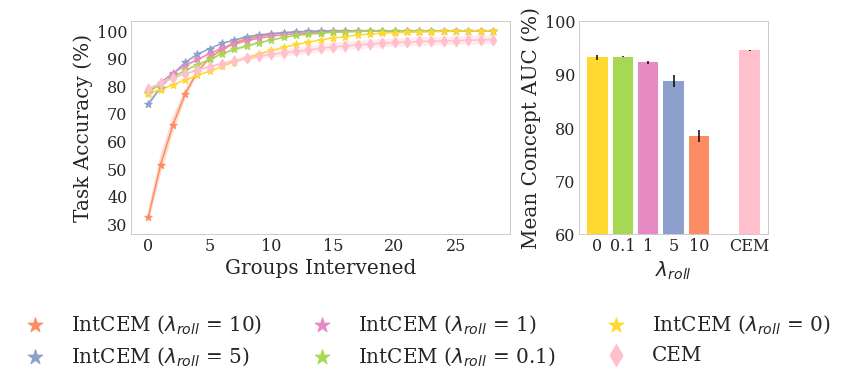

In [20]:
clrs = sns.color_palette("Set2", 10)
color_map = {"CEM": "pink"}
fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 4),
    squeeze=True,
    gridspec_kw={'width_ratios': [2, 1]}
)
method_to_actual_name = {
    'ConceptEmbeddingModel': 'CEM',
    'ConceptBottleneckModelLogit': "Joint CBM-Logit",
    'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
    'SequentialConceptBottleneckModel': "Sequential CBM",
    'IndependentConceptBottleneckModel': "Independent CBM",
}
model_names = [
    name for name in intervention_weight_results['test_acc_y'].keys()
    if name.startswith("IntAware")
] + ['ConceptEmbeddingModel']
print(model_names)
handles = []
labels = []

# First draw the interventions
ax = axs[0]
for method_idx, method_name in enumerate(model_names):
    marker = model_name_to_marker.get(method_name,'.')
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        human_policy_name, policy_name = "Learnt", "group_random"
        marker = "*"
        config = intervention_weight_model_configs[method_name]
        print(config['intervention_task_discount'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($\\lambda_{roll}$ =" + f" {config['intervention_weight']}"
        method_to_actual_name[method_name] += ")"
        used_results = intervention_weight_results
        key = config['intervention_weight']
    else:
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        used_results = other_filtered_results["CUB"]
        key = "CEM"
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    config = intervention_weight_model_configs[method_name]
    
    if policy_name == "group_random" and "IntAware" in method_name:
        human_policy_name = "Learnt"
    means, stds = get_intervention_accuracies(used_results, method_name, policy_name=policy_name)
    print("\t means =", means)
    print("\t stds =", stds)
    method_name = method_to_actual_name.get(method_name, method_name)
    if key not in color_map:
        color_map[key] = clrs[len(color_map)]
    color = color_map[key]
    x_vals = list(range(0, len(means), 1))
    ax.plot(
        x_vals,
        means,
        c=color,
        zorder=1,
    )
    ax.scatter(
        x_vals,
        means,
        s=60,
        label=f'{method_name}',
        color=color,
        zorder=2,
        marker=marker,
    )
    ax.fill_between(
        x_vals,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=color,
    )
handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_yticks(np.arange(30, 101, 10))
ax.set_xlabel(f"Groups Intervened", fontsize=20)
# ax.set_title("IntCEM $\\lambda_{roll}$ Ablation (CUB)", fontsize=20)
ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
ax.grid(False)

# Then draw the concept mean accuracies
ax = axs[1]
means = []
stds = []
colors = []
names = []
for method_idx, method_name in enumerate(model_names):
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        config = intervention_weight_model_configs[method_name]
        print(config['intervention_task_discount'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($\\lambda_{roll}$ =" + f" {config['intervention_weight']}"
        method_to_actual_name[method_name] += ")"
        names.append(str(config['intervention_weight']))
        used_results = intervention_weight_results
        key = config['intervention_weight']
    else:
        means.append(0)
        stds.append(0)
        colors.append("red")
        names.append("")
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        names.append('CEM')
        used_results = other_filtered_results["CUB"]
        key = "CEM"
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    vals = used_results['test_auc_c'][og_method_name]
    mean, std = np.mean(vals, axis=0), np.std(vals, axis=0)
    means.append(mean * 100)
    stds.append(std * 100)
    method_name = method_to_actual_name.get(method_name, method_name)
    if key not in color_map:
        color_map[key] = clrs[len(color_map)]
    colors.append(color_map[key])
x_vals = list(range(0, len(means), 1))
sort_idx = np.argsort(list(map(lambda x: float(x) if x not in ['', 'CEM'] else float("inf"), names)))
means = np.array(means)[sort_idx]
stds = np.array(stds)[sort_idx]
colors = np.array(colors)[sort_idx]
names = np.array(names)[sort_idx]
print("means = ", means)
ax.bar(
    range(len(means)),
    means,
    zorder=1,
    yerr=2*np.array(stds),
    tick_label=names,
    color=colors,
)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_yticks(np.arange(50, 101, 10))
ax.set_ylim((60,100))
ax.set_xlabel("$\\lambda_{roll}$", fontsize=20)
# ax.set_title("Concept Performance", fontsize=20)
ax.set_ylabel(f"Mean Concept AUC (%)", fontsize=20)
ax.grid(False)

# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=20,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=3,
    markerscale=2,
)
plt.tight_layout()
plt.savefig("figures/intervention_weight_ablation.pdf", bbox_inches='tight')
plt.savefig("figures/intervention_weight_ablation.png", bbox_inches='tight')
plt.show()

## $\lambda_\text{concept}$ Ablation

In [21]:
concept_weight_model_configs = defaultdict(dict)
concept_weight_results = filter_results(
    ablation_results['loss_weight'],
    concept_weight_model_configs,
    CUB_LOSS_WEIGHT_ABL_DIR,
    lambda config: not ("concept_loss_ablation" in config['extra_name']),
)
concept_weight_results['test_acc_y']

Removing ['IntAwareConceptEmbeddingModelintervention_weight_ablation_10', 'IntAwareConceptEmbeddingModelintervention_weight_ablation_5', 'IntAwareConceptEmbeddingModelintervention_weight_ablation_1', 'IntAwareConceptEmbeddingModelintervention_weight_ablation_0.1', 'IntAwareConceptEmbeddingModelintervention_weight_ablation_0']


defaultdict(list,
            {'IntAwareConceptEmbeddingModelconcept_loss_ablation_10': array([0.75975144, 0.76717293, 0.75871593]),
             'IntAwareConceptEmbeddingModelconcept_loss_ablation_5': array([0.73679668, 0.75871593, 0.75491887]),
             'IntAwareConceptEmbeddingModelconcept_loss_ablation_1': array([0.46530893, 0.49171558, 0.42078012]),
             'IntAwareConceptEmbeddingModelconcept_loss_ablation_0.1': array([0.18605454, 0.23265447, 0.3900587 ]),
             'IntAwareConceptEmbeddingModelconcept_loss_ablation_0': array([0.37400758, 0.41128755, 0.24525371])})

['IntAwareConceptEmbeddingModelconcept_loss_ablation_10', 'IntAwareConceptEmbeddingModelconcept_loss_ablation_5', 'IntAwareConceptEmbeddingModelconcept_loss_ablation_1', 'IntAwareConceptEmbeddingModelconcept_loss_ablation_0.1', 'IntAwareConceptEmbeddingModelconcept_loss_ablation_0', 'ConceptEmbeddingModel']
1.5 IntAwareConceptEmbeddingModelconcept_loss_ablation_10
	 means = [76.04418364 79.96778276 83.29306179 86.44574848 89.40283051 91.81912323
 93.79818203 95.51259924 96.6171902  97.54918882 98.13600276 98.49269359
 98.94143367 99.20607525 99.44770452 99.62029686 99.78138304 99.85041997
 99.86192613 99.88493844 99.8964446  99.90795075 99.93096307 99.94246922
 99.94246922 99.95397538 99.95397538 99.95397538 99.95397538]
	 stds = [0.63711279 0.28231145 0.17143786 0.39491433 0.49862959 0.69780827
 0.50522376 0.43389041 0.2860385  0.08455263 0.05636842 0.07092871
 0.13319338 0.08455263 0.02818421 0.07456841 0.08610419 0.08610419
 0.07456841 0.05867011 0.05636842 0.05867011 0.05636842 0.0

/tmp/ipykernel_3461383/3256384638.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  colors = np.array(colors)[sort_idx]


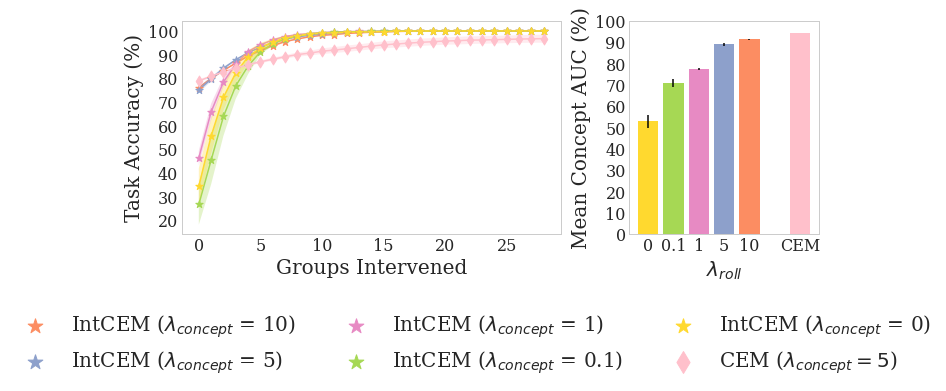

In [22]:
# clrs = sns.color_palette("Set2", 10)
# color_map = {"CEM": "pink", 'CEM ($\\lambda_{concept} = 5$)': 'pink'}
fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 4),
    squeeze=True,
    gridspec_kw={'width_ratios': [2, 1]}
)
method_to_actual_name = {
    'ConceptEmbeddingModel': 'CEM ($\\lambda_{concept} = 5$)',
    'ConceptBottleneckModelLogit': "Joint CBM-Logit",
    'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
    'SequentialConceptBottleneckModel': "Sequential CBM",
    'IndependentConceptBottleneckModel': "Independent CBM",
}
model_names = [
    name for name in concept_weight_results['test_acc_y'].keys()
    if name.startswith("IntAware")
] + ['ConceptEmbeddingModel']
print(model_names)
handles = []
labels = []

# First draw the interventions
ax = axs[0]
for method_idx, method_name in enumerate(model_names):
    marker = model_name_to_marker.get(method_name,'.')
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        human_policy_name, policy_name = "Learnt", "group_random"
        marker = "*"
        config = concept_weight_model_configs[method_name]
        print(config['intervention_task_discount'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($\\lambda_{concept}$ =" + f" {config['concept_loss_weight']}"
        method_to_actual_name[method_name] += ")"
        used_results = concept_weight_results
        key = config['concept_loss_weight']
    else:
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        used_results = other_filtered_results["CUB"]
        key = 'CEM'
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    config = concept_weight_model_configs[method_name]
    
    if policy_name == "group_random" and "IntAware" in method_name:
        human_policy_name = "Learnt"
    means, stds = get_intervention_accuracies(used_results, method_name, policy_name=policy_name)
    print("\t means =", means)
    print("\t stds =", stds)
    method_name = method_to_actual_name.get(method_name, method_name)
    if key not in color_map:
        color_map[key] = clrs[len(color_map)]
    color = color_map[key]
    x_vals = list(range(0, len(means), 1))
    ax.plot(
        x_vals,
        means,
        c=color,
        zorder=1,
    )
    ax.scatter(
        x_vals,
        means,
        s=60,
        label=f'{method_name}',
        color=color,
        zorder=2,
        marker=marker,
    )
    ax.fill_between(
        x_vals,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=color,
    )
handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_yticks(np.arange(20, 101, 10))
ax.set_xlabel(f"Groups Intervened", fontsize=20)
# ax.set_title("IntCEM $\\lambda_{roll}$ Ablation (CUB)", fontsize=20)
ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
ax.grid(False)

# Then draw the concept mean accuracies
ax = axs[1]
means = []
stds = []
colors = []
names = []
for method_idx, method_name in enumerate(model_names):
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        config = concept_weight_model_configs[method_name]
        print(config['intervention_task_discount'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($\\lambda_{concept}$ =" + f" {config['concept_loss_weight']}"
        method_to_actual_name[method_name] += ")"
        names.append(str(config['concept_loss_weight']))
        used_results = concept_weight_results
        key = config['concept_loss_weight']
    else:
        means.append(0)
        stds.append(0)
        colors.append("red")
        names.append("")
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        names.append('CEM')
        key = "CEM"
        used_results = other_filtered_results["CUB"]
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    vals = used_results['test_auc_c'][og_method_name]
    mean, std = np.mean(vals, axis=0), np.std(vals, axis=0)
    means.append(mean * 100)
    stds.append(std * 100)
    method_name = method_to_actual_name.get(method_name, method_name)
    if key not in color_map:
        color_map[key] = clrs[len(color_map)]
    colors.append(color_map[key])
x_vals = list(range(0, len(means), 1))
sort_idx = np.argsort(list(map(lambda x: float(x) if x not in ['', 'CEM'] else float("inf"), names)))
means = np.array(means)[sort_idx]
stds = np.array(stds)[sort_idx]
colors = np.array(colors)[sort_idx]
names = np.array(names)[sort_idx]
print("means = ", means)
ax.bar(
    range(len(means)),
    means,
    zorder=1,
    yerr=2*np.array(stds),
    tick_label=names,
    color=colors,
)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylim((0,100))
ax.set_xlabel("$\\lambda_{roll}$", fontsize=20)
# ax.set_title("Concept Performance", fontsize=20)
ax.set_ylabel(f"Mean Concept AUC (%)", fontsize=20)
ax.grid(False)

# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=20,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=3,
    markerscale=2,
)
plt.tight_layout()
plt.savefig("figures/concept_weight_ablation.pdf", bbox_inches='tight')
plt.savefig("figures/concept_weight_ablation.png", bbox_inches='tight')
plt.show()

## $\gamma$ Ablation

In [23]:
scaling_factor_model_configs = defaultdict(dict)
scaling_factor_results = filter_results(
    ablation_results['conditions'],
    scaling_factor_model_configs,
    CUB_CONDITIONS_ABL_DIR,
    lambda config: not ("task_discount_ablation" in config['extra_name']),
)
scaling_factor_results['test_acc_y']

Removing ['IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_1', 'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.75', 'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.5', 'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.25', 'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0', 'IntAwareConceptEmbeddingModelint_model_layers_ablation_[128, 128, 64, 64]', 'IntAwareConceptEmbeddingModelint_model_layers_ablation_[64, 64, 32, 32]', 'IntAwareConceptEmbeddingModelint_model_layers_ablation_[32, 32, 16, 16]', 'IntAwareConceptEmbeddingModelint_model_layers_ablation_[16, 16, 8, 8]']


defaultdict(list,
            {'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_2': array([0.72333449, 0.71798414, 0.74749744]),
             'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1.5': array([0.73990333, 0.76441145, 0.74974114]),
             'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1.1': array([0.73576111, 0.75543666, 0.75509149]),
             'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1': array([0.74887812, 0.75923371, 0.75509149]),
             'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_0.9': array([0.75077665, 0.76095963, 0.75578183]),
             'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_0.5': array([0.74076629, 0.74732482, 0.76838106])})

['IntAwareConceptEmbeddingModelintervention_task_discount_ablation_2', 'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1.5', 'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1.1', 'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1', 'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_0.9', 'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_0.5', 'ConceptEmbeddingModel']
2 IntAwareConceptEmbeddingModelintervention_task_discount_ablation_2
	 means = [73.22517547 79.36946266 84.19054194 88.4708319  91.49695087 93.97077436
 95.76573467 96.89333794 97.65274422 98.49269359 98.88390289 99.26360603
 99.51674146 99.59728455 99.68933379 99.7928892  99.85041997 99.90795075
 99.93096307 99.93096307 99.95397538 99.97698769 99.98849384 99.97698769
 99.98849384 99.98849384 99.98849384 99.98849384 99.98849384]
	 stds = [1.33996088 0.88425387 0.19728947 0.31384609 0.46851394 0.48188682
 0.35239657 0.40939931 0.41517935 0.1

/tmp/ipykernel_3461383/3647568987.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  colors = np.array(colors)[sort_idx]


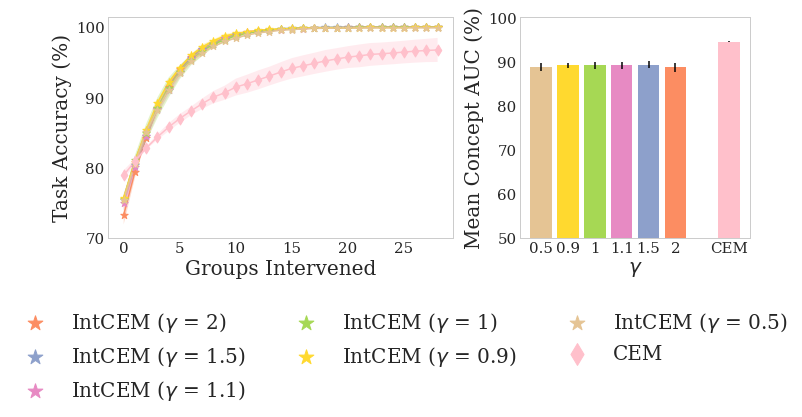

In [24]:
clrs = sns.color_palette("Set2", 10)
color_map = {"CEM": "pink"}
fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 4),
    squeeze=True,
    gridspec_kw={'width_ratios': [1.5, 1]}
)
method_to_actual_name = {
    'ConceptEmbeddingModel': 'CEM',
    'ConceptBottleneckModelLogit': "Joint CBM-Logit",
    'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
    'SequentialConceptBottleneckModel': "Sequential CBM",
    'IndependentConceptBottleneckModel': "Independent CBM",
}
model_names = [
    name for name in scaling_factor_results['test_acc_y'].keys()
    if name.startswith("IntAware")
] + ['ConceptEmbeddingModel']
print(model_names)
handles = []
labels = []

# First draw the interventions
ax = axs[0]
for method_idx, method_name in enumerate(model_names):
    marker = model_name_to_marker.get(method_name,'.')
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        human_policy_name, policy_name = "Learnt", "group_random"
        marker = "*"
        config = scaling_factor_model_configs[method_name]
        print(config['intervention_task_discount'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($\\gamma$ =" + f" {config['intervention_task_discount']}"
        method_to_actual_name[method_name] += ")"
        used_results = scaling_factor_results
        key = config['intervention_task_discount']
    else:
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        used_results = other_filtered_results["CUB"]
        key = 'CEM'
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    config = scaling_factor_model_configs[method_name]
    
    if policy_name == "group_random" and "IntAware" in method_name:
        human_policy_name = "Learnt"
    means, stds = get_intervention_accuracies(used_results, method_name, policy_name=policy_name)
    print("\t means =", means)
    print("\t stds =", stds)
    method_name = method_to_actual_name.get(method_name, method_name)
    if key not in color_map:
        color_map[key] = clrs[len(color_map)]
    color = color_map[key]
    x_vals = list(range(0, len(means), 1))
    ax.plot(
        x_vals,
        means,
        c=color,
        zorder=1,
    )
    ax.scatter(
        x_vals,
        means,
        s=60,
        label=f'{method_name}',
        color=color,
        zorder=2,
        marker=marker,
    )
    ax.fill_between(
        x_vals,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=color,
    )
handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_yticks(np.arange(70, 101, 10))
ax.set_xlabel(f"Groups Intervened", fontsize=20)
# ax.set_title("IntCEM $\\gamma$ Ablation (CUB)", fontsize=20)
ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
ax.grid(False)

# Then draw the concept mean accuracies
ax = axs[1]
means = []
stds = []
colors = []
names = []
for method_idx, method_name in enumerate(model_names):
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        config = scaling_factor_model_configs[method_name]
        print(config['intervention_task_discount'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($\\gamma$ =" + f" {config['intervention_task_discount']}"
        method_to_actual_name[method_name] += ")"
        names.append(str(config['intervention_task_discount']))
        used_results = scaling_factor_results
        key = config['intervention_task_discount']
    else:
        means.append(0)
        stds.append(0)
        colors.append("red")
        names.append("")
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        names.append('CEM')
        key = "CEM"
        used_results = other_filtered_results["CUB"]
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    vals = used_results['test_auc_c'][og_method_name]
    mean, std = np.mean(vals, axis=0), np.std(vals, axis=0)
    means.append(mean * 100)
    stds.append(std * 100)
    method_name = method_to_actual_name.get(method_name, method_name)
    if key not in color_map:
        color_map[key] = clrs[len(color_map)]
    colors.append(color_map[key])
x_vals = list(range(0, len(means), 1))
sort_idx = np.argsort(list(map(lambda x: float(x) if x not in ['', 'CEM'] else float("inf"), names)))
means = np.array(means)[sort_idx]
stds = np.array(stds)[sort_idx]
colors = np.array(colors)[sort_idx]
names = np.array(names)[sort_idx]
print("means = ", means)
ax.bar(
    range(len(means)),
    means,
    zorder=1,
    yerr=2*np.array(stds),
    tick_label=names,
    color=colors,
)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_yticks(np.arange(50, 101, 10))
ax.set_ylim((50,100))
ax.set_xlabel("$\\gamma$", fontsize=20)
# ax.set_title("Concept Performance", fontsize=20)
ax.set_ylabel(f"Mean Concept AUC (%)", fontsize=20)
ax.grid(False)

# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=20,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=3,
    markerscale=2,
)
plt.tight_layout()
plt.savefig("figures/scaling_factor_ablation.pdf", bbox_inches='tight')
plt.savefig("figures/scaling_factor_ablation.png", bbox_inches='tight')
plt.show()

## Mask Prior Ablation

In [25]:
int_prob_model_configs = defaultdict(dict)
int_prob_results = filter_results(
    ablation_results['conditions'],
    int_prob_model_configs,
    CUB_CONDITIONS_ABL_DIR,
    lambda config: not ("training_intervention_prob_ablation" in config['extra_name']),
)
int_prob_results['test_acc_y']

Removing ['IntAwareConceptEmbeddingModelintervention_task_discount_ablation_2', 'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1.5', 'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1.1', 'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_1', 'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_0.9', 'IntAwareConceptEmbeddingModelintervention_task_discount_ablation_0.5', 'IntAwareConceptEmbeddingModelint_model_layers_ablation_[128, 128, 64, 64]', 'IntAwareConceptEmbeddingModelint_model_layers_ablation_[64, 64, 32, 32]', 'IntAwareConceptEmbeddingModelint_model_layers_ablation_[32, 32, 16, 16]', 'IntAwareConceptEmbeddingModelint_model_layers_ablation_[16, 16, 8, 8]']


defaultdict(list,
            {'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_1': array([0.73955816, 0.75008631, 0.75319296]),
             'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.75': array([0.66465306, 0.71297896, 0.72764927]),
             'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.5': array([0.69589227, 0.712116  , 0.6763894 ]),
             'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.25': array([0.73472559, 0.76303071, 0.7483604 ]),
             'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0': array([0.74300998, 0.76665515, 0.76441145])})

['IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_1', 'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.75', 'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.5', 'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0.25', 'IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_0', 'ConceptEmbeddingModel']
1 IntAwareConceptEmbeddingModeltraining_intervention_prob_ablation_1
	 means = [ 74.29524796  75.88309746  77.33287309  78.75963641  80.38200437
  81.88931078  83.53469106  85.07651594  86.85997008  88.51685652
  89.74801519  90.97917386  92.54401105  93.89023127  94.70716834
  95.67368542  96.46761017  97.29605339  97.80232424  98.42365666
  98.6192613   99.0104706   99.20607525  99.51674146  99.65481533
  99.75837073  99.88493844  99.93096307 100.        ]
	 stds = [0.76531074 0.61512214 0.44055206 0.2115381  0.52450909 0.4693609
 0.34171539 0.2115381  0.11390513 0.22606009 0.24408242 0.35464354
 0.22370524

/tmp/ipykernel_3461383/2888359851.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  colors = np.array(colors)[sort_idx]


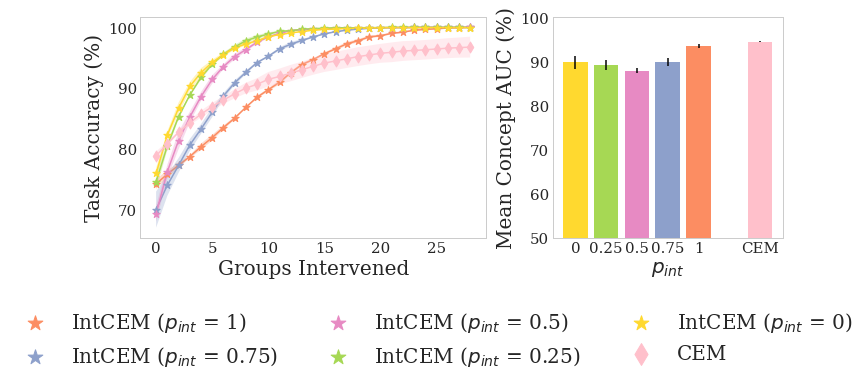

In [26]:
clrs = sns.color_palette("Set2", 10)
color_map = {"CEM": "pink"}
fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 4),
    squeeze=True,
    gridspec_kw={'width_ratios': [1.5, 1]}
)
method_to_actual_name = {
    'ConceptEmbeddingModel': 'CEM',
    'ConceptBottleneckModelLogit': "Joint CBM-Logit",
    'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
    'SequentialConceptBottleneckModel': "Sequential CBM",
    'IndependentConceptBottleneckModel': "Independent CBM",
}
model_names = [
    name for name in int_prob_results['test_acc_y'].keys()
    if name.startswith("IntAware")
] + ['ConceptEmbeddingModel']
print(model_names)
handles = []
labels = []

# First draw the interventions
ax = axs[0]
for method_idx, method_name in enumerate(model_names):
    marker = model_name_to_marker.get(method_name,'.')
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        human_policy_name, policy_name = "Learnt", "group_random"
        marker = "*"
        config = int_prob_model_configs[method_name]
        print(config['training_intervention_prob'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($p_{int}$ =" + f" {config['training_intervention_prob']}"
        method_to_actual_name[method_name] += ")"
        used_results = int_prob_results
        key = config['training_intervention_prob']
    else:
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        used_results = other_filtered_results["CUB"]
        key = 'CEM'
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    config = int_prob_model_configs[method_name]
    
    if policy_name == "group_random" and "IntAware" in method_name:
        human_policy_name = "Learnt"
    means, stds = get_intervention_accuracies(used_results, method_name, policy_name=policy_name)
    print("\t means =", means)
    print("\t stds =", stds)
    method_name = method_to_actual_name.get(method_name, method_name)
    if key not in color_map:
        color_map[key] = clrs[len(color_map)]
    color = color_map[key]
    x_vals = list(range(0, len(means), 1))
    ax.plot(
        x_vals,
        means,
        c=color,
        zorder=1,
    )
    ax.scatter(
        x_vals,
        means,
        s=60,
        label=f'{method_name}',
        color=color,
        zorder=2,
        marker=marker,
    )
    ax.fill_between(
        x_vals,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=color,
    )
handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_yticks(np.arange(70, 101, 10))
ax.set_xlabel(f"Groups Intervened", fontsize=20)
# ax.set_title("IntCEM $p_{int}$ Ablation (CUB)", fontsize=20)
ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
ax.grid(False)

# Then draw the concept mean accuracies
ax = axs[1]
means = []
stds = []
colors = []
names = []
for method_idx, method_name in enumerate(model_names):
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        config = int_prob_model_configs[method_name]
        print(config['training_intervention_prob'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($p_{int}$ =" + f" {config['training_intervention_prob']}"
        method_to_actual_name[method_name] += ")"
        names.append(str(config['training_intervention_prob']))
        used_results = int_prob_results
        key = config['training_intervention_prob']
    else:
        means.append(0)
        stds.append(0)
        colors.append("red")
        names.append("")
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        names.append('CEM')
        key = "CEM"
        used_results = other_filtered_results["CUB"]
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    vals = used_results['test_auc_c'][og_method_name]
    mean, std = np.mean(vals, axis=0), np.std(vals, axis=0)
    means.append(mean * 100)
    stds.append(std * 100)
    method_name = method_to_actual_name.get(method_name, method_name)
    if key not in color_map:
        color_map[key] = clrs[len(color_map)]
    colors.append(color_map[key])
x_vals = list(range(0, len(means), 1))
sort_idx = np.argsort(list(map(lambda x: float(x) if x not in ['', 'CEM'] else float("inf"), names)))
means = np.array(means)[sort_idx]
stds = np.array(stds)[sort_idx]
colors = np.array(colors)[sort_idx]
names = np.array(names)[sort_idx]
print("means = ", means)
ax.bar(
    range(len(means)),
    means,
    zorder=1,
    yerr=2*np.array(stds),
    tick_label=names,
    color=colors,
)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_yticks(np.arange(50, 101, 10))
ax.set_ylim((50,100))
ax.set_xlabel("$p_{int}$", fontsize=20)
# ax.set_title("Concept Performance", fontsize=20)
ax.set_ylabel(f"Mean Concept AUC (%)", fontsize=20)
ax.grid(False)

# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=20,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=3,
    markerscale=2,
)
plt.tight_layout()
plt.savefig("figures/int_prob_ablation.pdf", bbox_inches='tight')
plt.savefig("figures/int_prob_ablation.png", bbox_inches='tight')
plt.show()

## Horizon Prior Ablation

In [27]:
horizon_model_configs = defaultdict(dict)
horizon_results = filter_results(
    ablation_results['rollout'],
    horizon_model_configs,
    CUB_ROLLOUTS_ABL_DIR,
    lambda config: (config['horizon_rate'] != 1.005),
)
horizon_results['test_acc_y']

Removing ['IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.5_max_horizon_15', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.5_max_horizon_10', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.5_max_horizon_5', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.5_max_horizon_1', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.1_max_horizon_15', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.1_max_horizon_10', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.1_max_horizon_5', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.1_max_horizon_1', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1_max_horizon_15', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1_max_horizon_10', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1_max_horizon_5', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_hor

defaultdict(list,
            {'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_15': array([0.75837076, 0.74300998, 0.75578183]),
             'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_10': array([0.76147741, 0.71021748, 0.76164997]),
             'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_5': array([0.75422853, 0.74059373, 0.75405592]),
             'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_1': array([0.78287882, 0.78080773, 0.78063512])})

['IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_15', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_10', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_5', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_1', 'ConceptEmbeddingModel']
15 IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_15
	 means = [75.2732712  80.1403751  83.45414797 86.28466229 89.08065815 91.72707398
 93.82119434 95.48958693 96.9278564  97.99792889 98.60775515 99.07950754
 99.28661834 99.51674146 99.67782764 99.74686457 99.88493844 99.96548153
 99.97698769 99.96548153 99.98849384 99.98849384 99.98849384 99.98849384
 99.98849384 99.98849384 99.98849384 99.98849384 99.98849384]
	 stds = [0.60601515 0.64660091 1.02488786 1.88019176 1.79015965 1.26808069
 1.071      0.87613162 0.66636439 0.40647847 0.3290841  0.25573709
 0.28231145 0.18481623 0.0989

/tmp/ipykernel_3461383/1645357683.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  colors = np.array(colors)[sort_idx]


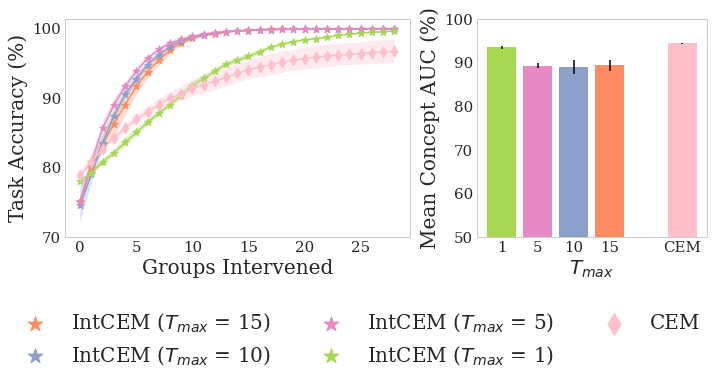

In [28]:
clrs = sns.color_palette("Set2", 10)
color_map = {"CEM": "pink"}
fig, axs = plt.subplots(
    1,
    2,
    figsize=(10, 4),
    squeeze=True,
    gridspec_kw={'width_ratios': [1.5, 1]}
)
method_to_actual_name = {
    'ConceptEmbeddingModel': 'CEM',
    'ConceptBottleneckModelLogit': "Joint CBM-Logit",
    'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
    'SequentialConceptBottleneckModel': "Sequential CBM",
    'IndependentConceptBottleneckModel': "Independent CBM",
}
model_names = [
    name for name in horizon_results['test_acc_y'].keys()
    if name.startswith("IntAware")
] + ['ConceptEmbeddingModel']
print(model_names)
handles = []
labels = []

# First draw the interventions
ax = axs[0]
for method_idx, method_name in enumerate(model_names):
    marker = model_name_to_marker.get(method_name,'.')
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        human_policy_name, policy_name = "Learnt", "group_random"
        marker = "*"
        config = horizon_model_configs[method_name]
        print(config['max_horizon'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($T_{max}$ =" + f" {config['max_horizon']}"
        method_to_actual_name[method_name] += ")"
        used_results = horizon_results
        key = config['max_horizon']
    else:
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        used_results = other_filtered_results["CUB"]
        key = 'CEM'
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    config = horizon_model_configs[method_name]
    
    if policy_name == "group_random" and "IntAware" in method_name:
        human_policy_name = "Learnt"
    means, stds = get_intervention_accuracies(used_results, method_name, policy_name=policy_name)
    print("\t means =", means)
    print("\t stds =", stds)
    method_name = method_to_actual_name.get(method_name, method_name)
    if key not in color_map:
        color_map[key] = clrs[len(color_map)]
    color = color_map[key]
    x_vals = list(range(0, len(means), 1))
    ax.plot(
        x_vals,
        means,
        c=color,
        zorder=1,
    )
    ax.scatter(
        x_vals,
        means,
        s=60,
        label=f'{method_name}',
        color=color,
        zorder=2,
        marker=marker,
    )
    ax.fill_between(
        x_vals,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=color,
    )
handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_yticks(np.arange(70, 101, 10))
ax.set_xlabel(f"Groups Intervened", fontsize=20)
# ax.set_title("IntCEM $T_{max}$ Ablation (CUB)", fontsize=20)
ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
ax.grid(False)

# Then draw the concept mean accuracies
ax = axs[1]
means = []
stds = []
colors = []
names = []
for method_idx, method_name in enumerate(model_names):
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        config = horizon_model_configs[method_name]
        print(config['max_horizon'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($T_{max}$ =" + f" {config['max_horizon']}"
        method_to_actual_name[method_name] += ")"
        names.append(str(config['max_horizon']))
        used_results = horizon_results
        key = config['max_horizon']
    else:
        means.append(0)
        stds.append(0)
        colors.append("red")
        names.append("")
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        names.append('CEM')
        key = "CEM"
        used_results = other_filtered_results["CUB"]
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    vals = used_results['test_auc_c'][og_method_name]
    mean, std = np.mean(vals, axis=0), np.std(vals, axis=0)
    means.append(mean * 100)
    stds.append(std * 100)
    method_name = method_to_actual_name.get(method_name, method_name)
    if key not in color_map:
        color_map[key] = clrs[len(color_map)]
    colors.append(color_map[key])
x_vals = list(range(0, len(means), 1))
sort_idx = np.argsort(list(map(lambda x: float(x) if x not in ['', 'CEM'] else float("inf"), names)))
means = np.array(means)[sort_idx]
stds = np.array(stds)[sort_idx]
colors = np.array(colors)[sort_idx]
names = np.array(names)[sort_idx]
print("means = ", means)
ax.bar(
    range(len(means)),
    means,
    zorder=1,
    yerr=2*np.array(stds),
    tick_label=names,
    color=colors,
)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_yticks(np.arange(50, 101, 10))
ax.set_ylim((50,100))
ax.set_xlabel("$T_{max}$", fontsize=20)
# ax.set_title("Concept Performance", fontsize=20)
ax.set_ylabel(f"Mean Concept AUC (%)", fontsize=20)
ax.grid(False)

# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=20,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=3,
    markerscale=2,
)
plt.tight_layout()
plt.savefig("figures/horizon_ablation.pdf", bbox_inches='tight')
plt.savefig("figures/horizon_ablation.png", bbox_inches='tight')
plt.show()

['IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_15', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_10', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_5', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_1', 'ConceptEmbeddingModel']
1.5 IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_15
	 means = [75.2732712  80.1403751  83.45414797 86.28466229 89.08065815 91.72707398
 93.82119434 95.48958693 96.9278564  97.99792889 98.60775515 99.07950754
 99.28661834 99.51674146 99.67782764 99.74686457 99.88493844 99.96548153
 99.97698769 99.96548153 99.98849384 99.98849384 99.98849384 99.98849384
 99.98849384 99.98849384 99.98849384 99.98849384 99.98849384]
	 stds = [0.60601515 0.64660091 1.02488786 1.88019176 1.79015965 1.26808069
 1.071      0.87613162 0.66636439 0.40647847 0.3290841  0.25573709
 0.28231145 0.18481623 0.098

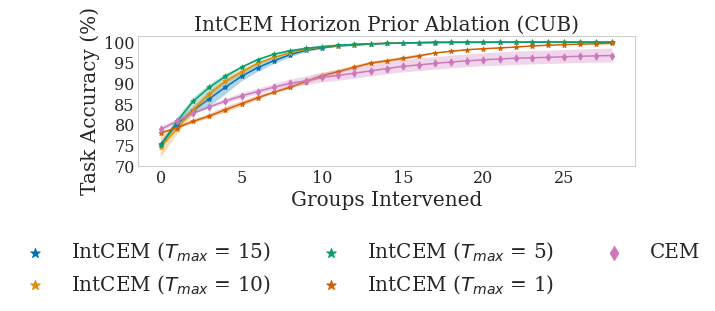

In [ ]:

clrs = sns.color_palette("colorblind", 30)
color_map = {}
fig, ax = plt.subplots(
    1,
    1,
    figsize=(8, 3),
    squeeze=True,
)
method_to_actual_name = {
    'ConceptEmbeddingModel': 'CEM',
    'ConceptBottleneckModelLogit': "Joint CBM-Logit",
    'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
    'SequentialConceptBottleneckModel': "Sequential CBM",
    'IndependentConceptBottleneckModel': "Independent CBM",
}
model_names = [
    name for name in horizon_results['test_acc_y'].keys()
    if name.startswith("IntAware")
] + ['ConceptEmbeddingModel']
print(model_names)
handles = []
labels = []
for method_idx, method_name in enumerate(model_names):
    marker = model_name_to_marker.get(method_name,'.')
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        human_policy_name, policy_name = "Learnt", "group_random"
        marker = "*"
        config = horizon_model_configs[method_name]
        print(config['intervention_task_discount'], method_name)
        method_to_actual_name[method_name] = "IntCEM ($T_{max}$ =" + f" {config['max_horizon']}"
        method_to_actual_name[method_name] += ")"
        used_results = horizon_results
    else:
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        used_results = other_filtered_results["CUB"]
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    config = horizon_model_configs[method_name]
    
    if policy_name == "group_random" and "IntAware" in method_name:
        human_policy_name = "Learnt"
    means, stds = get_intervention_accuracies(used_results, method_name, policy_name=policy_name)
    print("\t means =", means)
    print("\t stds =", stds)
    method_name = method_to_actual_name.get(method_name, method_name)
    if og_method_name not in color_map:
        color_map[og_method_name] = clrs[len(color_map)]
    color = color_map[og_method_name]
    x_vals = list(range(0, len(means), 1))
    ax.plot(
        x_vals,
        means,
        c=color,
        zorder=1,
    )
    ax.scatter(
        x_vals,
        means,
        s=25,
        label=f'{method_name}',
        color=color,
        zorder=2,
        marker=marker,
    )
    ax.fill_between(
        x_vals,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=color,
    )
handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_yticks(np.arange(70, 101, 5))
ax.set_xlabel(f"Groups Intervened", fontsize=20)
ax.set_title("IntCEM Horizon Prior Ablation (CUB)", fontsize=20)
ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
ax.grid(False)
# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=20,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=3,
    markerscale=2,
)
plt.tight_layout()
plt.savefig("figures/horizon_ablation_2.pdf", bbox_inches='tight')
plt.savefig("figures/horizon_ablation_2.png", bbox_inches='tight')
plt.show()

## Annealing Rate Ablation

In [ ]:
anneal_rate_model_configs = defaultdict(dict)
anneal_rate_results = filter_results(
    ablation_results['rollout'],
    anneal_rate_model_configs,
    CUB_ROLLOUTS_ABL_DIR,
    lambda config: (config['max_horizon'] != 10),
)
anneal_rate_results['test_acc_y']

Removing ['IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.5_max_horizon_15', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.5_max_horizon_5', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.5_max_horizon_1', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.1_max_horizon_15', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.1_max_horizon_5', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.1_max_horizon_1', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_15', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_5', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_1', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1_max_horizon_15', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1_max_horizon_5', 'IntAwareConceptEmbeddingModelhorizon_rate_ablati

defaultdict(list,
            {'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.5_max_horizon_10': array([0.74059373, 0.73524338, 0.75716257]),
             'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.1_max_horizon_10': array([0.75526404, 0.7181567 , 0.74974114]),
             'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_10': array([0.76147741, 0.71021748, 0.76164997]),
             'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1_max_horizon_10': array([0.73420781, 0.76907146, 0.77114254])})

['IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.5_max_horizon_10', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.1_max_horizon_10', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.005_max_horizon_10', 'IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1_max_horizon_10', 'ConceptEmbeddingModel']
1.5 IntAwareConceptEmbeddingModelhorizon_rate_ablation_horizon_rate_1.5_max_horizon_10
	 means = [74.39880336 80.0368197  84.25957887 87.55033943 90.58796456 92.87768956
 94.8452422  96.11091934 96.98538718 97.80232424 98.46968128 98.91842136
 99.26360603 99.52824761 99.63180301 99.81590151 99.88493844 99.94246922
 99.94246922 99.96548153 99.98849384 99.98849384 99.98849384 99.98849384
 99.98849384 99.98849384 99.98849384 99.98849384 99.98849384]
	 stds = [0.63669706 0.28231145 0.46567958 0.86610099 0.84568288 0.63544822
 0.52299244 0.33624759 0.18337795 0.12708964 0.17220837 0.19995567
 0.08610419 0.09059956 0.05867011 0.

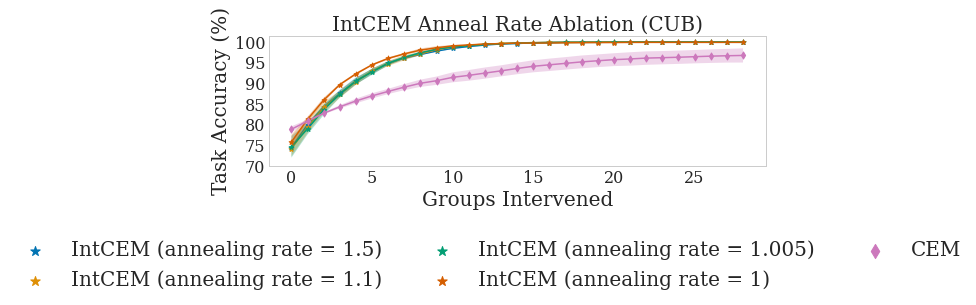

In [ ]:

clrs = sns.color_palette("colorblind", 30)
color_map = {}
fig, ax = plt.subplots(
    1,
    1,
    figsize=(8, 3),
    squeeze=True,
)
method_to_actual_name = {
    'ConceptEmbeddingModel': 'CEM',
    'ConceptBottleneckModelLogit': "Joint CBM-Logit",
    'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
    'SequentialConceptBottleneckModel': "Sequential CBM",
    'IndependentConceptBottleneckModel': "Independent CBM",
}
model_names = [
    name for name in anneal_rate_results['test_acc_y'].keys()
    if name.startswith("IntAware")
] + ['ConceptEmbeddingModel']
print(model_names)
handles = []
labels = []
for method_idx, method_name in enumerate(model_names):
    marker = model_name_to_marker.get(method_name,'.')
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        human_policy_name, policy_name = "Learnt", "group_random"
        marker = "*"
        config = anneal_rate_model_configs[method_name]
        print(config['intervention_task_discount'], method_name)
        method_to_actual_name[method_name] = "IntCEM (annealing rate =" + f" {config['horizon_rate']}"
        method_to_actual_name[method_name] += ")"
        used_results = anneal_rate_results
    else:
        human_policy_name, policy_name = "CooP", "group_coop_no_prior"
        marker = "d"
        used_results = other_filtered_results["CUB"]
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    config = anneal_rate_model_configs[method_name]
    
    if policy_name == "group_random" and "IntAware" in method_name:
        human_policy_name = "Learnt"
    means, stds = get_intervention_accuracies(used_results, method_name, policy_name=policy_name)
    print("\t means =", means)
    print("\t stds =", stds)
    method_name = method_to_actual_name.get(method_name, method_name)
    if og_method_name not in color_map:
        color_map[og_method_name] = clrs[len(color_map)]
    color = color_map[og_method_name]
    x_vals = list(range(0, len(means), 1))
    ax.plot(
        x_vals,
        means,
        c=color,
        zorder=1,
    )
    ax.scatter(
        x_vals,
        means,
        s=25,
        label=f'{method_name}',
        color=color,
        zorder=2,
        marker=marker,
    )
    ax.fill_between(
        x_vals,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=color,
    )
handles, labels = ax.get_legend_handles_labels()
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.set_yticks(np.arange(70, 101, 5))
ax.set_xlabel(f"Groups Intervened", fontsize=20)
ax.set_title("IntCEM Anneal Rate Ablation (CUB)", fontsize=20)
ax.set_ylabel(f"Task Accuracy (%)", fontsize=20)
ax.grid(False)
# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=20,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=3,
    markerscale=2,
)
plt.tight_layout()
plt.savefig("figures/anneal_rate_ablation.pdf", bbox_inches='tight')
plt.savefig("figures/anneal_rate_ablation.png", bbox_inches='tight')
plt.show()

# IntCBM Results

In [15]:
CUB_RED_INTCBM_DIR = os.path.join(
    RESULTS_DIR,
    "cub_subsample_0.25_intcbm_experiments",
)
CUB_RED_INTCBM_RESULTS = joblib.load(os.path.join(CUB_RED_INTCBM_DIR, 'results.joblib'))

sorting_key = 'test_acc_y_group_random_ints'
sorting_fn = lambda x: np.mean([x[len(x)//2] for x in x]) #np.mean
ablation_results = {}
intcbm_model_configs = defaultdict(dict)
model_names = [
    'ConceptEmbeddingModel',
    'IntAwareConceptEmbeddingModel',
    'IntAwareConceptBottleneckModelLogit',
    'IntAwareConceptBottleneckModelSigmoid',
    'ConceptBottleneckModelLogit',
    'ConceptBottleneckModelSigmoid',
    'SequentialConceptBottleneckModel',
    'IndependentConceptBottleneckModel',
]
intcbm_processed_results = process_results(CUB_RED_INTCBM_RESULTS, model_names)

['IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 'ConceptEmbeddingModel', 'IntAwareConceptBottleneckModelSigmoid_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 'ConceptBottleneckModelSigmoid_concept_loss_weight_1', 'IntAwareConceptBottleneckModelLogit_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 'ConceptBottleneckModelLogit']
For CUB-Incomp and method IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1
	means = [74.96720746 78.33620987 81.76734553 85.86123576 88.96099413 91.73627891
 94.49085261 96.52053849]
	stds = [0.63250794 0.34282938 0.14382234 0.29338667 0.2559027  0.18856058
 0.23370812 0.18830765]
For CUB-Incomp and method ConceptEmbeddingModel
	means = [76.02347256 78.02554367 80.12426648 82.77528478 85.09492579 87.43527787
 89.57542285 91.41180532]
	stds = [0.483

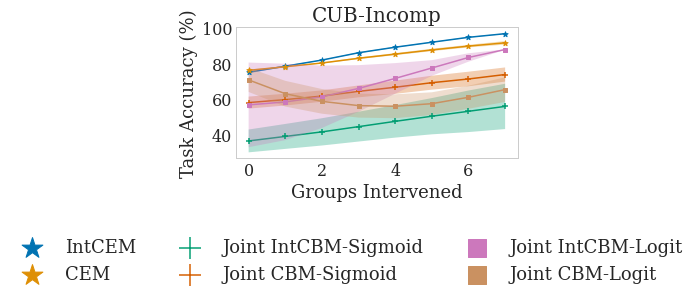

In [47]:

clrs = sns.color_palette("colorblind", 15)
color_map = {}
model_name_to_marker = {
    'IntAwareConceptEmbeddingModel': '*',
    'ConceptBottleneckModelLogit': '.',
    'ConceptBottleneckModelLogit_long': '.',
    'ConceptBottleneckModelSigmoid': 'x',
    'ConceptBottleneckModelSigmoid_long': 'x',
    'ConceptEmbeddingModel': '*',
    'IntAwareConceptBottleneckModelLogit_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1': 's',
    'ConceptBottleneckModelLogit': 's',
    'IntAwareConceptBottleneckModelSigmoid_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1': '+',
    'ConceptBottleneckModelSigmoid_concept_loss_weight_1': '+',
    'IndependentConceptBottleneckModel': 'o',
    'IndependentConceptBottleneckModel_long': 'o',
}
used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random_no_prior"),
}
width = 5
height = 3
label_size = 18
title_size = 20
legend_size = 18
tick_size = 16
marker_size_large = 30
marker_size_small = marker_size_large/1.5
markerscale = 4
fig, axs = plt.subplots(
    1,
    1,
    figsize=(width, height),
    squeeze=False,
)
labels = []
handles = []
dataset_idx = 0
dataset_name = "CUB-Incomp"
dataset_results = intcbm_processed_results
method_to_actual_name = {
    'ConceptEmbeddingModel': 'CEM',
    'ConceptBottleneckModelLogit': "Joint CBM-Logit",
    'ConceptBottleneckModelLogit_long': "Joint CBM-Logit",
    'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
    'ConceptBottleneckModelSigmoid_long': "Joint CBM-Sigmoid",
    "IntAwareConceptBottleneckModelSigmoid_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1": "Joint IntCBM-Sigmoid",
    "ConceptBottleneckModelSigmoid_concept_loss_weight_1": "Joint CBM-Sigmoid",
    "IntAwareConceptBottleneckModelLogit_intervention_weight_1": "Joint IntCBM-Logit",
    "IntAwareConceptBottleneckModelLogit_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1": "Joint IntCBM-Logit",
    "ConceptBottleneckModelLogit_concept_loss_weight_1": "Joint CBM-Logit",
    'SequentialConceptBottleneckModel': "Sequential CBM",
    'SequentialConceptBottleneckModel_long': "Sequential CBM",
    'IndependentConceptBottleneckModel': "Independent CBM",
    'IndependentConceptBottleneckModel_long': "Independent CBM",
}
intcem_models = [
    name for name in dataset_results['test_acc_y'].keys()
    if name.startswith("IntAware")
]
sorted_intcem_models = []
for method_idx, method_name in enumerate(intcem_models):
    marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
    human_policy_name, policy_name = ("Random", "group_random")
    means, stds = get_intervention_accuracies(dataset_results, method_name, policy_name=policy_name)
    area = means[0] * np.trapz(means)
    sorted_intcem_models.append((area, method_name))
    method_name = method_to_actual_name.get(method_name, method_name)
sorted_intcem_models = sorted(sorted_intcem_models, key=lambda x: x[0], reverse=True)
model_names = [sorted_intcem_models[0][1]] + [
    'ConceptEmbeddingModel',
    'IntAwareConceptBottleneckModelSigmoid_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1',
    'ConceptBottleneckModelSigmoid_concept_loss_weight_1',
    'IntAwareConceptBottleneckModelLogit_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1',
    'ConceptBottleneckModelLogit', #_concept_loss_weight_1',
]

print(model_names)
for method_idx, method_name in enumerate(model_names):
    ax = axs[0, dataset_idx]
    marker = model_name_to_marker.get(method_name,'.')
    human_policy_name, policy_name = used_policies.get(
        method_name,
        ("Random", "group_random_no_prior"),
    )
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
        method_to_actual_name[method_name] = "IntCEM"
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    used_results = dataset_results
    if og_method_name.startswith("ConceptBottleneckModelLogit"):
        used_results = all_processed_results["CUB-Incomp"]
    means, stds = get_intervention_accuracies(used_results, og_method_name, policy_name=policy_name)
    method_name = method_to_actual_name.get(method_name, method_name)
    print("For", dataset_name, "and method", og_method_name)
    print("\tmeans =", means)
    print("\tstds =", stds)
    if method_name not in color_map:
        color_map[method_name] = clrs[len(color_map)]
    color = color_map[method_name]
    x_vals = list(range(0, len(means), 1))
    ax.plot(
        x_vals,
        means,
        c=color,
        zorder=1,
    )
    ax.scatter(
        x_vals,
        means,
        s=marker_size_large if marker in ["+", "*"] else marker_size_small,
        label=f'{method_name}', # ({human_policy_name} Policy)',
        color=color,
        zorder=2,
        marker=marker,
    )
    ax.fill_between(
        x_vals,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=color,
    )
    new_handles, new_labels = ax.get_legend_handles_labels()
    for label, handle in zip(new_labels, new_handles):
        if label not in labels:
            labels.append(label)
            handles.append(handle)
ax.xaxis.set_tick_params(labelsize=tick_size)
ax.set_xticks(x_vals[::2] if len(x_vals) < 10 else x_vals[::4])
ax.yaxis.set_tick_params(labelsize=tick_size)
ax.set_xlabel(f"Groups Intervened", fontsize=label_size)
ax.set_title(dataset_name, fontsize=title_size)
if dataset_idx == 0:
    ax.set_ylabel(f"Task Accuracy (%)", fontsize=label_size)
ax.grid(False)
# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=legend_size,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.05),
    ncol=3,
    markerscale=markerscale,
)
plt.tight_layout()
plt.savefig("figures/intcbm_intervention_results_with_random.pdf", bbox_inches='tight')
plt.savefig("figures/intcbm_intervention_results_with_random.png", bbox_inches='tight')
plt.show()

['IntAwareConceptEmbeddingModelRetryNoBackprop_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1']
For CUB-Incomp and method IntAwareConceptEmbeddingModelRetryNoBackprop_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1
	means = [74.54608215 80.96651709 86.10286503 90.20365896 92.94442527 94.77390404
 95.74732482 96.28581291]
	stds = [0.4670082  0.24563958 0.52920312 0.46486009 0.47208342 0.29822038
 0.18956894 0.21457052]
For CUB-Incomp and method IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1
	means = [74.96720746 81.71211598 86.74490853 90.6869175  93.35864688 94.96030376
 96.09941319 96.52053849]
	stds = [0.63250794 0.23145398 0.22896961 0.29725993 0.24757226 0.26106552
 0.19156972 0.18830765]


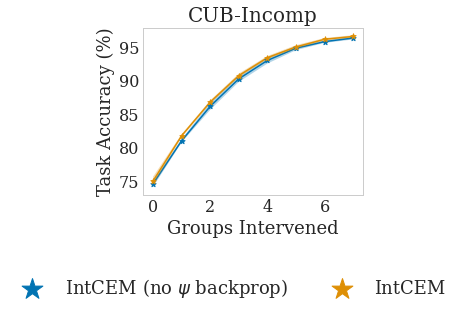

In [67]:

clrs = sns.color_palette("colorblind", 15)
color_map = {}
model_name_to_marker = {
    'IntAwareConceptEmbeddingModel': '*',
    'ConceptBottleneckModelLogit': '.',
    'ConceptBottleneckModelLogit_long': '.',
    'ConceptBottleneckModelSigmoid': 'x',
    'ConceptBottleneckModelSigmoid_long': 'x',
    'ConceptEmbeddingModel': '*',
    'IntAwareConceptBottleneckModelLogit_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1': 's',
    'ConceptBottleneckModelLogit': 's',
    'IntAwareConceptBottleneckModelSigmoid_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1': '+',
    'ConceptBottleneckModelSigmoid_concept_loss_weight_1': '+',
    'IndependentConceptBottleneckModel': 'o',
    'IndependentConceptBottleneckModel_long': 'o',
}
used_policies = {
    'IntAwareConceptEmbeddingModel': ("Random", "group_random_no_prior"),
}
width = 4
height = 3.5
label_size = 18
title_size = 20
legend_size = 18
tick_size = 16
marker_size_large = 30
marker_size_small = marker_size_large/1.5
markerscale = 4
fig, axs = plt.subplots(
    1,
    1,
    figsize=(width, height),
    squeeze=False,
)
labels = []
handles = []
dataset_idx = 0
dataset_name = "CUB-Incomp"
dataset_results = intcbm_processed_results
method_to_actual_name = {
    'ConceptEmbeddingModel': 'CEM',
    'ConceptBottleneckModelLogit': "Joint CBM-Logit",
    'ConceptBottleneckModelLogit_long': "Joint CBM-Logit",
    'ConceptBottleneckModelSigmoid': "Joint CBM-Sigmoid",
    'ConceptBottleneckModelSigmoid_long': "Joint CBM-Sigmoid",
    "IntAwareConceptBottleneckModelSigmoid_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1": "Joint IntCBM-Sigmoid",
    "ConceptBottleneckModelSigmoid_concept_loss_weight_1": "Joint CBM-Sigmoid",
    "IntAwareConceptBottleneckModelLogit_intervention_weight_1": "Joint IntCBM-Logit",
    "IntAwareConceptBottleneckModelLogit_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1": "Joint IntCBM-Logit",
    "ConceptBottleneckModelLogit_concept_loss_weight_1": "Joint CBM-Logit",
    'SequentialConceptBottleneckModel': "Sequential CBM",
    'SequentialConceptBottleneckModel_long': "Sequential CBM",
    'IndependentConceptBottleneckModel': "Independent CBM",
    'IndependentConceptBottleneckModel_long': "Independent CBM",
}
intcem_models = [
    name for name in dataset_results['test_acc_y'].keys()
    if name.startswith("IntAware")
]
model_names = [
    'IntAwareConceptEmbeddingModelRetryNoBackprop_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1',
    'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1',
    # 'ConceptEmbeddingModel',
]

print(model_names)
for method_idx, method_name in enumerate(model_names):
    ax = axs[0, dataset_idx]
    marker = model_name_to_marker.get(method_name,'.')
    human_policy_name, policy_name = used_policies.get(
        method_name,
        ("Random", "group_random_no_prior"),
    )
    if method_name.startswith("IntAwareConceptEmbeddingModel"):
        marker = model_name_to_marker.get('IntAwareConceptEmbeddingModel','.')
        human_policy_name, policy_name = ("Learnt", "group_random")
        if "NoBackprop" in method_name:
            method_to_actual_name[method_name] = "IntCEM (no $\psi$ backprop)"
        else:
            method_to_actual_name[method_name] = "IntCEM"
    if method_name not in method_to_actual_name:
        continue
    og_method_name = method_name
    used_results = dataset_results
    if og_method_name.startswith("ConceptBottleneckModelLogit"):
        used_results = all_processed_results["CUB-Incomp"]
    means, stds = get_intervention_accuracies(used_results, og_method_name, policy_name=policy_name)
    method_name = method_to_actual_name.get(method_name, method_name)
    print("For", dataset_name, "and method", og_method_name)
    print("\tmeans =", means)
    print("\tstds =", stds)
    if method_name not in color_map:
        color_map[method_name] = clrs[len(color_map)]
    color = color_map[method_name]
    x_vals = list(range(0, len(means), 1))
    ax.plot(
        x_vals,
        means,
        c=color,
        zorder=1,
    )
    ax.scatter(
        x_vals,
        means,
        s=marker_size_large if marker in ["+", "*"] else marker_size_small,
        label=f'{method_name}', # ({human_policy_name} Policy)',
        color=color,
        zorder=2,
        marker=marker,
    )
    ax.fill_between(
        x_vals,
        means - stds,
        means + stds,
        alpha=0.3,
        facecolor=color,
    )
    new_handles, new_labels = ax.get_legend_handles_labels()
    for label, handle in zip(new_labels, new_handles):
        if label not in labels:
            labels.append(label)
            handles.append(handle)
ax.xaxis.set_tick_params(labelsize=tick_size)
ax.set_xticks(x_vals[::2] if len(x_vals) < 10 else x_vals[::4])
ax.yaxis.set_tick_params(labelsize=tick_size)
ax.set_xlabel(f"Groups Intervened", fontsize=label_size)
ax.set_title(dataset_name, fontsize=title_size)
if dataset_idx == 0:
    ax.set_ylabel(f"Task Accuracy (%)", fontsize=label_size)
ax.grid(False)
# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=legend_size,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.05),
    ncol=3,
    markerscale=markerscale,
)
plt.tight_layout()
# plt.savefig("figures/intcbm_intervention_results_with_random.pdf", bbox_inches='tight')
# plt.savefig("figures/intcbm_intervention_results_with_random.png", bbox_inches='tight')
plt.show()

In [59]:
intcbm_processed_results['test_acc_y'].keys()

dict_keys(['IntAwareConceptEmbeddingModelRetryNoBackprop_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 'IntAwareConceptBottleneckModelSigmoid_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 'ConceptBottleneckModelSigmoid_concept_loss_weight_1', 'ConceptBottleneckModelLogit_concept_loss_weight_1', 'IntAwareConceptBottleneckModelLogit_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1', 'ConceptEmbeddingModel', 'IntAwareConceptEmbeddingModelRetry_intervention_weight_1_horizon_rate_1.005_intervention_discount_1_task_discount_1.1'])